<!-- ================== INTRO – Estimation de la granulométrie d’un minerai ================== -->

<div align="center" style="background-color:#004085; color:white; padding:20px; border-radius:10px;">
  <h1 style="margin:0;">🪨 <b>Estimation de la Granulométrie d’un Minerai</b></h1>
  <h2 style="margin:6px 0 0 0;"><i>Analyse d’images de grains et de joints de grains</i></h2>
</div>

## Résumé de l’étude

Ce projet s’inscrit dans le contexte de la caractérisation microstructurale d’un matériau métallique à partir d’images de grains issues de micrographies. À partir d’un ensemble d’images de référence organisées par dossiers (images brutes, sorties de filtres de gradient, cartes HED, masques de vérité terrain pour l’apprentissage supervisé), le notebook met en place une chaîne complète de traitement d’images. Celle-ci va du chargement et du prétraitement des micrographies jusqu’à la segmentation des joints de grains par différentes approches (segmentation classique par seuillage, filtrage de gradient, réseau de contours HED, puis U-Net convolutif entraîné sur un jeu de données artificiel et réel).

Les masques segmentés sont convertis en cartes de labels, puis utilisés pour extraire des grandeurs géométriques (aire, périmètre, diamètre équivalent, axes majeur et mineur, circularité), converties en unités physiques grâce à une calibration de l’échelle en pixels par micron. L’objectif final est de construire une granulométrie fiable et reproductible, tout en évaluant la qualité de segmentation via des métriques telles que le Dice et l’IoU, afin de disposer d’un outil d’aide au contrôle de procédé et à la caractérisation des matériaux.

---

## Introduction

La taille et la morphologie des grains cristallins jouent un rôle déterminant dans les propriétés mécaniques et la durabilité des matériaux métalliques. La granulométrie influence notamment la résistance, la ductilité, la ténacité ainsi que la sensibilité au vieillissement ou à la corrosion. Traditionnellement, ces caractéristiques sont évaluées par des méthodes manuelles ou semi-manuelles, où un expert trace et mesure les grains directement sur les micrographies. Si ces approches sont précises, elles restent chronophages, peu reproductibles et difficiles à appliquer à grande échelle.

Dans ce contexte, le traitement d’images et l’intelligence artificielle offrent une voie d’automatisation particulièrement pertinente. Le notebook fourni met en œuvre un pipeline complet qui part d’images de microstructure stockées dans un répertoire projet monté sous Google Drive, puis explore plusieurs stratégies de segmentation : filtres de gradient, seuillage, détection de contours HED à partir de poids Caffe, et enfin un modèle U-Net convolutif entraîné sur un jeu de données supervisé combinant grains artificiels et réels.

À partir de ces masques segmentés, le pipeline dérive des cartes de labels qui permettent de mesurer, grain par grain, des grandeurs géométriques détaillées. Celles-ci sont ensuite converties en unités physiques grâce à un facteur de calibration en pixels par micron, ce qui permet de construire des distributions de taille de grains et de comparer les performances des différentes méthodes de segmentation. L’ensemble aboutit à un cadre de travail reproductible pour la granulométrie automatisée, intégrant à la fois des outils de vision par ordinateur classique et des réseaux de neurones profonds.

---

## Source et description des données

Les données exploitées dans ce projet sont organisées autour d’un dossier principal de travail (`BASE_DIR`), localisé dans un répertoire Google Drive. À partir de cette racine, plusieurs sous-dossiers structurent les différentes sources d’images :

- `Grains/` : micrographies de référence de la microstructure.  
- `HED_raw/` et `HED_filtered/` : cartes de contours brutes et filtrées produites par le modèle HED.  
- `Segmented/` : résultats de segmentation obtenus par diverses méthodes.  
- `FilteredGradV2/` : images issues de filtrages de gradient.  
- `weights HED/` : fichiers `deploy.prototxt` et `hed_pretrained_bsds.caffemodel` nécessaires à l’initialisation du réseau HED.  

Pour l’apprentissage supervisé du U-Net, un jeu de données dédié est stocké dans le dossier `GRAIN DATA SET`, avec les sous-dossiers :

- `AG/` et `AGMask/` : images de grains artificiels (Voronoï, textures synthétiques) et leurs masques annotés.  
- `RG/` et `RGMask/` : images de grains réels et leurs masques de vérité terrain.  

Des répertoires complémentaires (`THRESH_PRE`, `HED_PRE`, `GRAD_PRE`) conservent des versions pré-segmentées issues de méthodes classiques (seuillage, gradient) ou de HED, ce qui permet des comparaisons de performance entre approches. Un facteur d’échelle de **2,25 pixels par micron** est utilisé pour la conversion des mesures en unités physiques via un paramètre de calibration `P2M`.

---

## Pipeline de traitement et étapes principales

### Étape 1 : Configuration du projet et import des bibliothèques

Le notebook commence par l’importation des bibliothèques nécessaires (NumPy, SciPy, OpenCV, Pandas, Matplotlib, TensorFlow/Keras, Gradio, etc.) et par la définition des chemins d’accès aux données. Les variables `DRIVE_ROOT` et `BASE_DIR` pointent vers le répertoire du projet dans Google Drive, puis un ensemble de constantes (`GRAINS_DIR`, `HED_RAW_DIR`, `HED_FILTERED_DIR`, `SEGMENTED_DIR`, `FilteredGradV2`, `WEIGHTS_HED_DIR`, `GRAIN_DS_DIR`, `AG_DIR`, `AGMASK_DIR`, `RG_DIR`, `RGMASK_DIR`, etc.) décrivent la structure des sous-dossiers. Des blocs de vérification s’assurent de l’existence de ces répertoires et affichent le nombre de fichiers présents dans chacun d’eux ainsi que quelques exemples de noms d’images.

### Étape 2 : Préparation des données et calibration de l’échelle

Une première phase d’exploration consiste à charger des images représentatives depuis `Grains/` et à vérifier leurs dimensions (tuiles de 300 × 400 pixels dans la configuration actuelle). Le notebook met en place la calibration spatiale en indiquant qu’une longueur donnée en microns correspond à 2,25 pixels, et en dérivant le paramètre `P2M` afin de convertir les mesures (aire, diamètres, axes) en unités physiques (microns, µm²). Cette calibration sera utilisée ultérieurement lors de la conversion des caractéristiques géométriques extraites à partir des cartes de labels.

### Étape 3 : Segmentation par HED et filtrage des contours

Le modèle HED (Holistically-Nested Edge Detection) est initialisé via OpenCV en chargeant les fichiers `deploy.prototxt` et `hed_pretrained_bsds.caffemodel` depuis le répertoire `weights HED`. Une couche personnalisée de type `CropLayer` est définie pour assurer la compatibilité du réseau avec la taille des images. Des fonctions de haut niveau appliquent ce réseau à l’ensemble des images de `Grains/` ; les cartes de contours obtenues sont sauvegardées dans `HED_raw/` et `HED_filtered/`. Ces cartes servent soit directement à la segmentation des joints de grains, soit comme entrée d’un pipeline de post-traitement (seuillage, morphologie mathématique).

### Étape 4 : Constitution du jeu de données supervisé pour U-Net

À partir des dossiers `AG`, `AGMask`, `RG` et `RGMask`, le notebook construit un jeu de données supervisé pour l’apprentissage d’un U-Net de segmentation. Les images de grains artificiels et réels sont chargées, converties en niveaux de gris, redimensionnées, normalisées et appariées à leurs masques de vérité terrain. Les tenseurs `X_train` et `Y_train` sont préparés avec une dimension de canal unique (images 256×256×1, masques binaires 256×256×1). Les données sont ensuite réparties en ensembles d’entraînement et de validation afin de suivre la performance du modèle lors de l’apprentissage.

### Étape 5 : Apprentissage et évaluation du modèle U-Net

Le modèle U-Net est défini à l’aide d’une architecture encoder–decoder classique avec blocs de convolutions, couches de max-pooling pour la descente de résolution et couches de trans-convolution pour la remontée. Après compilation (fonction de perte `binary_crossentropy` et métrique d’accuracy), le réseau est entraîné sur le jeu supervisé avec des callbacks de type `ModelCheckpoint`, `EarlyStopping` et `ReduceLROnPlateau`. Les courbes de loss et d’accuracy sur train/validation sont tracées pour analyser la convergence.  

Une fois l’apprentissage terminé, la qualité de segmentation est évaluée via des métriques globales calculées pixel à pixel : accuracy, précision, rappel, F1-score, IoU (indice de Jaccard) et coefficient de Dice. Des histogrammes présentent la distribution de Dice et d’IoU par image, permettant d’identifier les cas les plus difficiles à segmenter ainsi que la robustesse globale du modèle.

### Étape 6 : Construction des cartes de labels et extraction des caractéristiques

À partir des masques binaires prédits (U-Net) ou issus des méthodes classiques (seuillage, gradient, HED), le notebook construit des cartes de labels via `cv2.connectedComponentsWithStats`. Une fonction de haut niveau, similaire à `compute_grain_features_from_labels`, parcourt chaque étiquette de grain et en extrait un ensemble de caractéristiques géométriques :  

- aire en pixels (`area_px`),  
- périmètre (`perimeter_px`),  
- diamètre équivalent (`equiv_diameter_px`),  
- centroïde (`centroid_row`, `centroid_col`),  
- longueurs des axes majeur et mineur (`major_axis_px`, `minor_axis_px`),  
- rapport d’axes (`axis_ratio`),  
- circularité (`circularity`).  

Les résultats sont organisés dans un DataFrame `features_df` indexé par `image_id` et `grain_id`.

### Étape 7 : Conversion en unités physiques et construction de la granulométrie

Les fonctions de post-traitement complètent `features_df` en convertissant les variables exprimées en pixels vers des unités physiques grâce au facteur `P2M`. De nouvelles colonnes, telles que `area_um2`, `equiv_diameter_um`, `major_axis_um`, `minor_axis_um`, sont ajoutées au DataFrame. Ces grandeurs permettent de :

- construire des histogrammes et distributions cumulatives de taille de grains,  
- calculer des statistiques descriptives (moyenne, médiane, quantiles),  
- comparer la granulométrie obtenue selon la méthode de segmentation (seuillage, gradient, HED, U-Net).

### Étape 8 : Visualisation avancée et interface interactive

Pour faciliter l’analyse visuelle, une fonction `draw_grain_ids_on_image` superpose sur l’image originale un overlay coloré des grains segmentés, accompagné des identifiants de grains positionnés à leurs centroïdes. Enfin, une interface Gradio (`segment_and_measure`) est mise en place pour permettre à l’utilisateur de charger une nouvelle micrographie, d’appliquer le modèle U-Net d’inférence, de visualiser l’overlay des grains et de récupérer automatiquement le tableau des caractéristiques géométriques associées à chaque grain. L’ensemble constitue un outil interactif complet pour la segmentation et la métrologie de grains.

---

## Variables de l’étude

Le notebook définit un ensemble de variables structurées autour de trois grandes catégories :

1. **Objets du pipeline** : images brutes, images prétraitées, masques binaires, cartes de labels.  
2. **Caractéristiques géométriques élémentaires** associées à chaque grain.  
3. **Métriques de qualité de segmentation** et indicateurs de distribution granulométrique.

Le tableau ci-dessous récapitule les principales variables observées dans le code et dans les DataFrames de sortie.

| Variable | Description | Rôle dans l’étude |
|---------|-------------|-------------------|
| `image_id` | Identifiant textuel d’une tuile ou micrographie (souvent dérivé du nom de fichier). | Permet de regrouper les grains par image d’origine et de produire des statistiques par micrographie. |
| `grain_id` | Identifiant entier d’un grain dans une carte de labels. | Sert de clé pour indexer chaque grain et le relier à ses caractéristiques géométriques. |
| `area_px` | Aire du grain en nombre de pixels. | Mesure de base pour la quantification de la taille des grains avant conversion en unités physiques. |
| `area_um2` | Aire du grain en µm², obtenue après application de la calibration pixels → microns. | Variable centrale pour la construction des distributions de taille et des statistiques granulométriques. |
| `perimeter_px` | Périmètre du grain en pixels. | Utilisé pour dériver des métriques de forme (par exemple circularité). |
| `equiv_diameter_px` | Diamètre équivalent (en pixels) d’un disque ayant la même aire que le grain. | Résume la taille du grain sous forme d’un seul paramètre scalaire. |
| `equiv_diameter_um` | Diamètre équivalent exprimé en microns. | Sert de base à la comparaison de la granulométrie avec des normes ou d’autres procédés. |
| `centroid_row`, `centroid_col` | Coordonnées du centroïde du grain dans l’image (ligne, colonne). | Utilisées pour positionner les numéros de grains sur les overlays et pour d’éventuelles analyses spatiales. |
| `major_axis_px`, `minor_axis_px` | Longueurs des axes majeur et mineur (en pixels) d’une ellipse ajustée au grain. | Permettent de caractériser l’allongement des grains et leur anisotropie. |
| `major_axis_um`, `minor_axis_um` | Axes majeur et mineur convertis en microns. | Utilisés pour analyser la morphologie des grains dans des unités physiques interprétables. |
| `axis_ratio` | Rapport entre l’axe majeur et l’axe mineur. | Indicateur de forme (distinction entre grains équiaxes et grains allongés). |
| `circularity` | Mesure de circularité dérivée de l’aire et du périmètre (proche de 1 pour un disque parfait). | Quantifie l’écart de forme par rapport à un disque, utile pour détecter des grains irréguliers ou coalescents. |
| `dice_score`, `iou_score` | Métriques de comparaison entre masque prédit et masque de référence (coefficients de Dice et IoU). | Évaluent la qualité de la segmentation obtenue par les différentes méthodes, notamment le U-Net. |
| `Total_Grains_X`, `Total_Grains_Y` | Comptage d’interceptions des joints de grains selon des lignes horizontales et verticales. | Relient le pipeline de segmentation à des méthodes planimétriques classiques d’estimation de taille de grains. |

---

## Description détaillée des variables

### Caractéristiques géométriques et structurelles des grains

Les variables géométriques extraites à partir des cartes de labels constituent le cœur de la caractérisation granulométrique. L’aire en µm² (`area_um2`) et le diamètre équivalent en microns (`equiv_diameter_um`) décrivent la taille moyenne des grains et permettent de construire des histogrammes ou des distributions cumulatives qui résument l’état microstructural du matériau. L’analyse de ces distributions donne accès à des indicateurs classiques tels que la taille moyenne de grain, les quantiles de taille ou encore la proportion de grains fins/grossiers, directement exploitables pour le contrôle de procédé et la comparaison entre lots de production.

Les variables liées à la forme — axes majeur et mineur (`major_axis_um`, `minor_axis_um`), rapport d’axes (`axis_ratio`), circularité (`circularity`) — renseignent sur la morphologie des grains et sur une éventuelle anisotropie introduite par le procédé de fabrication (orientation préférentielle, étirement, coalescence partielle). Des grains très équiaxes, de circularité élevée, traduisent généralement une microstructure plus homogène, tandis que des grains allongés ou très irréguliers peuvent signaler des gradients de solidification, des contraintes résiduelles ou des hétérogénéités de densité.

Couplées aux métriques de qualité de segmentation (Dice, IoU, accuracy, F1-score), ces variables garantissent que les conclusions granulométriques reposent sur des masques suffisamment fiables. Elles permettent ainsi de relier de manière robuste les observations microstructurales aux propriétés mécaniques attendues et à la performance globale du matériau ou du procédé étudié.

---

# Sommaire

- **Page de garde**
  - École Supérieure Polytechnique de Nouakchott – ESP-SID  
  - Projet Data Science / Traitement d’Images  
  - Analyse granulométrique d’une microstructure à partir d’images de grains  

- **Résumé de l’étude**

- **Introduction**

- **Source et description des données**

- **Pipeline de traitement et étapes principales**
  - Étape 1 : Configuration du projet et import des bibliothèques  
  - Étape 2 : Préparation des données et calibration de l’échelle  
  - Étape 3 : Segmentation par HED et filtrage des contours  
  - Étape 4 : Constitution du jeu de données supervisé pour U-Net  
  - Étape 5 : Apprentissage et évaluation du modèle U-Net  
  - Étape 6 : Construction des cartes de labels et extraction des caractéristiques  
  - Étape 7 : Conversion en unités physiques et construction de la granulométrie  
  - Étape 8 : Visualisation avancée et interface interactive  

# Section 1 — Setup & calibration  
Cette section prépare l’environnement de travail et vérifie que l’architecture du projet est correctement accessible avant de lancer les traitements principaux. Elle met en place le lien avec Google Drive, définit le dossier principal du projet, contrôle la présence de tous les sous-dossiers importants (images, masques, poids du modèle) et fixe l’échelle de conversion entre les pixels et les microns.  

Les objectifs principaux sont :  
- assurer un **accès stable aux données** via Google Drive ;  
- vérifier la **cohérence de l’arborescence du projet** (présence et contenu des dossiers clés) ;  
- définir une **calibration physique** fiable (pixels ↔ microns) pour les mesures géométriques à venir.  

In [4]:
# 1) Monter Google Drive
from google.colab import drive
drive.mount("/content/drive")


# 2) standards
import os
from pathlib import Path
import cv2
import numpy as np
from matplotlib import pyplot as plt
import scipy.stats as stats
import pandas as pd

# 3) Racine de ton Drive dans Colab
DRIVE_ROOT = Path("/content/drive/MyDrive")

# ⚠️ Adapter "cheigher" au nom EXACT du dossier projet dans ton Drive
BASE_DIR = DRIVE_ROOT / "cheighr"

print(f"[INFO] BASE_DIR = {BASE_DIR}")
if not BASE_DIR.is_dir():
    raise FileNotFoundError(
        f"Le dossier {BASE_DIR} n'existe pas.\n"
        "➡ Vérifie le nom du dossier dans ton Google Drive et adapte BASE_DIR."
    )

# === Sous-dossiers principaux du projet (toutes les sources d'images) ===
GRAINS_DIR        = BASE_DIR / "Grains"
HED_RAW_DIR       = BASE_DIR / "HED_raw"
HED_FILTERED_DIR  = BASE_DIR / "HED_filtered"
SEGMENTED_DIR     = BASE_DIR / "Segmented"
FILTERED_GRAD_DIR = BASE_DIR / "FilteredGradV2"
WEIGHTS_HED_DIR   = BASE_DIR / "weights HED"

# === Dossier du jeu de données supervisé (U-Net / ML) ===
GRAIN_DS_DIR   = BASE_DIR / "GRAIN DATA SET"
AG_DIR         = GRAIN_DS_DIR / "AG"
AGMASK_DIR     = GRAIN_DS_DIR / "AGMask"
RG_DIR         = GRAIN_DS_DIR / "RG"
RGMASK_DIR     = GRAIN_DS_DIR / "RGMask"
THRESH_PRE_DIR = GRAIN_DS_DIR / "THRESH_PRE"
HED_PRE_DIR    = GRAIN_DS_DIR / "HED_PRE"
GRAD_PRE_DIR   = GRAIN_DS_DIR / "GRAD_PRE"

# === Alias rétro-compatibles avec ton notebook existant ===
IMG_DIR = GRAINS_DIR
# === Petit helper pour vérifier les dossiers + nb de fichiers ===
def check_dir(name, path, max_files=5, exts=None):
    """
    Affiche si un dossier existe, le nombre de fichiers et quelques exemples.
    exts : liste d'extensions pour filtrer (['.png', '.jpg', ...]) ou None pour tout.
    """
    exists = path.is_dir()
    status = "OK" if exists else "❌"
    print(f"{name:15s} -> {status} | {path}")
    if exists:
        if exts is None:
            files = sorted([p.name for p in path.iterdir() if p.is_file()])
        else:
            exts_lower = tuple(e.lower() for e in exts)
            files = sorted([
                p.name for p in path.iterdir()
                if p.is_file() and p.suffix.lower() in exts_lower
            ])
        print(f"  {len(files)} fichiers trouvés.")
        print(f"  Exemples : {files[:max_files]}")
    print()

# Vérification rapide de tous les dossiers utiles (avec filtre d'extensions pour les images)
for name, path in [
    ("BASE_DIR",    BASE_DIR),
    ("GRAINS_DIR",  GRAINS_DIR),
    ("HED_RAW_DIR", HED_RAW_DIR),
    ("HED_FILTRÉ",  HED_FILTERED_DIR),
    ("SEGMENTED",   SEGMENTED_DIR),
    ("FGRADV2_DIR", FILTERED_GRAD_DIR),
    ("WEIGHTS_HED", WEIGHTS_HED_DIR),
    ("GRAIN_DS",    GRAIN_DS_DIR),
    ("AG_DIR",      AG_DIR),
    ("AGMASK_DIR",  AGMASK_DIR),
    ("RG_DIR",      RG_DIR),
    ("RGMASK_DIR",  RGMASK_DIR),
    ("THRESH_PRE",  THRESH_PRE_DIR),
    ("HED_PRE",     HED_PRE_DIR),
    ("GRAD_PRE",    GRAD_PRE_DIR),
]:
    # pour les dossiers d'images : filtrer png / jpg / jpeg
    if "DIR" in name or name in {"BASE_DIR", "GRAIN_DS", "WEIGHTS_HED"}:
        exts = [".png", ".jpg", ".jpeg"] if name not in {"BASE_DIR", "GRAIN_DS", "WEIGHTS_HED"} else None
        check_dir(name, path, exts=exts)

# === Paramètres physiques globaux (calibration pixels ↔ microns) ===
pixels = 225
microns = 100
scale = pixels / microns    # pixels par micron
M2P   = scale               # microns -> pixels
P2M   = 1 / scale           # pixels -> microns
print(f"[INFO] Échelle : {scale:.3f} pixels / micron (P2M = {P2M:.4f})")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
[INFO] BASE_DIR = /content/drive/MyDrive/cheighr
BASE_DIR        -> OK | /content/drive/MyDrive/cheighr
  32 fichiers trouvés.
  Exemples : ['AREA_HED_planimetric.csv', 'AR_HED_planimetric.csv', 'AVG_GrainX_Grad.csv', 'AVG_GrainX_Grad_v2.csv', 'AVG_GrainX_HED.csv']

GRAINS_DIR      -> OK | /content/drive/MyDrive/cheighr/Grains
  336 fichiers trouvés.
  Exemples : ['A_01_01.png', 'A_01_02.png', 'A_01_03.png', 'A_01_04.png', 'A_02_01.png']

HED_RAW_DIR     -> OK | /content/drive/MyDrive/cheighr/HED_raw
  336 fichiers trouvés.
  Exemples : ['A_01_01_HED.png', 'A_01_02_HED.png', 'A_01_03_HED.png', 'A_01_04_HED.png', 'A_02_01_HED.png']

FGRADV2_DIR     -> OK | /content/drive/MyDrive/cheighr/FilteredGradV2
  336 fichiers trouvés.
  Exemples : ['FGRAD_001.png', 'FGRAD_002.png', 'FGRAD_003.png', 'FGRAD_004.png', 'FGRAD_005.png']

WEIGHTS_HED     -> OK | /content/driv

Le code commence par monter le Google Drive dans l’environnement d’exécution afin de travailler directement sur les fichiers stockés dans l’espace personnel de l’utilisateur. Le dossier racine du projet est ensuite défini via `BASE_DIR`, et une vérification immédiate garantit que ce dossier existe bien. En cas de problème (nom incorrect, mauvais emplacement), une erreur explicite est déclenchée pour obliger à corriger la configuration avant de poursuivre.  
Les différents sous-dossiers du projet sont ensuite déclarés : dossier des micrographies originales, dossiers des résultats HED bruts et filtrés, dossiers des masques segmentés et des versions filtrées Gradient, dossier contenant les poids du modèle HED, ainsi que les dossiers du jeu de données supervisé (images et masques pour les séries AG et RG, plus les variantes prétraitées). Une fonction utilitaire `check_dir` inspecte chaque dossier, indique s’il existe, compte le nombre de fichiers et affiche quelques exemples de noms, ce qui permet de vérifier rapidement que les données sont présentes et correctement organisées.  
Enfin, le code fixe la calibration physique en s’appuyant sur une barre d’échelle connue (225 pixels pour 100 microns). À partir de ces valeurs, il calcule le nombre de pixels par micron et son inverse (microns par pixel), puis affiche ces facteurs de conversion. Cette calibration est utilisée dans tout le pipeline pour transformer les longueurs mesurées en pixels (longueurs d’interception, diamètres, dimensions des grains) en grandeurs physiques exprimées en microns, ce qui rend les résultats directement interprétables dans un contexte d’ingénierie des matériaux.

In [5]:
# 🧱 Bloc corrigé : construction de la liste complète d'images + image test

# Liste triée de toutes les images de grains (PNG)
image_files = sorted([p.name for p in IMG_DIR.glob("*.png")])
print(f"[INFO] Nombre total d'images de grains trouvées dans IMG_DIR : {len(image_files)}")
print("Exemples de fichiers :", image_files[:10])

if len(image_files) == 0:
    raise RuntimeError(f"Aucune image .png trouvée dans {IMG_DIR}")

# On garde aussi la liste des chemins complets pour un usage futur sur TOUT le dataset
grain_image_paths = [IMG_DIR / fname for fname in image_files]

print(f"[INFO] Exemple de chemins complets (3 premiers) :")
for p in grain_image_paths[:3]:
    print("   -", p)

# ⚙️ Définition d'une fonction réutilisable de seuillage + flous médians
def manual_threshold_and_blur(gray_img, thresh_value=135):
    """
    Applique le seuillage manuel + la chaîne de flous médians
    utilisée dans le notebook d'origine.

    gray_img : image en niveaux de gris (uint8)
    thresh_value : seuil binaire (0-255)
    """
    # Seuil manuel
    _, thresh = cv2.threshold(gray_img, thresh_value, 255, cv2.THRESH_BINARY)

    # Série de flous médians
    blur1 = cv2.medianBlur(thresh, 5)
    blur2 = cv2.medianBlur(blur1, 5)
    blur3 = cv2.medianBlur(blur2, 7)
    blur4 = cv2.medianBlur(blur3, 7)
    return blur4

# 🔍 On utilise la première image seulement comme "image de référence"
#     pour vérifier les dimensions et calculer les longueurs physiques.
test_fname = image_files[0]
test_path = IMG_DIR / test_fname
print("\n[INFO] Image test de référence :", test_path)

img = cv2.imread(str(test_path), cv2.IMREAD_GRAYSCALE)
if img is None:
    raise FileNotFoundError(f"Impossible de lire l'image : {test_path}")

print("Image test shape :", img.shape, "| dtype :", img.dtype)

# Application du pipeline manuel sur l'image de référence
Blur_Med_4_img = manual_threshold_and_blur(img)

# Dimensions réelles de cette image
numrows, numcols = Blur_Med_4_img.shape
print("Taille utilisée pour les calculs (référence) :", numrows, "x", numcols)

# Longueurs physiques des lignes d’interception (en microns)
row_length = numcols * P2M   # longueur physique d'une ligne horizontale
col_length = numrows * P2M   # longueur physique d'une ligne verticale
print("row_length (microns) :", row_length)
print("col_length (microns) :", col_length)

# 📌 On mémorise ces infos pour la suite du notebook (interceptions, surfaces, etc.)
IMG_SHAPE_REF = (numrows, numcols)
ROW_LENGTH_MICRONS = row_length
COL_LENGTH_MICRONS = col_length
print("\n[INFO] Paramètres de référence enregistrés :")
print("   IMG_SHAPE_REF        =", IMG_SHAPE_REF)
print("   ROW_LENGTH_MICRONS   =", ROW_LENGTH_MICRONS)
print("   COL_LENGTH_MICRONS   =", COL_LENGTH_MICRONS)

[INFO] Nombre total d'images de grains trouvées dans IMG_DIR : 336
Exemples de fichiers : ['A_01_01.png', 'A_01_02.png', 'A_01_03.png', 'A_01_04.png', 'A_02_01.png', 'A_02_02.png', 'A_02_03.png', 'A_02_04.png', 'A_03_01.png', 'A_03_02.png']
[INFO] Exemple de chemins complets (3 premiers) :
   - /content/drive/MyDrive/cheighr/Grains/A_01_01.png
   - /content/drive/MyDrive/cheighr/Grains/A_01_02.png
   - /content/drive/MyDrive/cheighr/Grains/A_01_03.png

[INFO] Image test de référence : /content/drive/MyDrive/cheighr/Grains/A_01_01.png
Image test shape : (300, 400) | dtype : uint8
Taille utilisée pour les calculs (référence) : 300 x 400
row_length (microns) : 177.77777777777777
col_length (microns) : 133.33333333333331

[INFO] Paramètres de référence enregistrés :
   IMG_SHAPE_REF        = (300, 400)
   ROW_LENGTH_MICRONS   = 177.77777777777777
   COL_LENGTH_MICRONS   = 133.33333333333331


Ce bloc commence par construire la **liste complète des micrographies** à partir du dossier `IMG_DIR`. Les noms de fichiers sont triés, le nombre total d’images est affiché, et quelques exemples sont listés pour vérifier visuellement que le dataset est correctement chargé. Une protection est ajoutée : si aucune image `.png` n’est trouvée, une erreur explicite est levée afin de signaler immédiatement un problème de configuration des données.  

Les chemins complets vers chaque image sont ensuite stockés dans `grain_image_paths`. Cette liste servira plus tard pour parcourir de manière systématique l’ensemble du jeu de données, sans avoir à reconstruire les chemins à chaque traitement.  

Le bloc définit également une fonction réutilisable `manual_threshold_and_blur`. Cette fonction applique d’abord un **seuillage binaire manuel** sur une image en niveaux de gris, puis enchaîne plusieurs **flous médians** successifs. L’objectif est de reproduire une même chaîne de prétraitement pour toutes les images, en éliminant le bruit tout en conservant les contours des grains.  

Une image de référence est ensuite choisie (la première de la liste). Elle est chargée en niveaux de gris, et ses dimensions sont affichées pour documenter la taille caractéristique d’une micrographie (par exemple 300 × 400 pixels). La fonction de prétraitement est appliquée à cette image de référence, puis les dimensions finales de l’image binaire/floutée sont utilisées pour calculer les **longueurs physiques** des lignes d’interception :  
- `row_length` correspond à la longueur d’une ligne horizontale en microns ;  
- `col_length` correspond à la longueur d’une ligne verticale en microns.  

Enfin, ces informations de référence sont mémorisées dans des variables globales (`IMG_SHAPE_REF`, `ROW_LENGTH_MICRONS`, `COL_LENGTH_MICRONS`). Elles serviront dans tout le reste du pipeline pour convertir les comptages d’interceptions en tailles de grains exprimées en microns, en garantissant que les calculs reposent toujours sur la même géométrie d’image de référence.


In [6]:
# 🔍 Étapes 3 & 4 — Différences + visualisation (image de référence)

# On utilise l'image prétraitée de référence déjà calculée : Blur_Med_4_img
# (issue du bloc précédent avec manual_threshold_and_blur)

diff_x = np.diff(Blur_Med_4_img, axis=1)  # différences horizontales
diff_y = np.diff(Blur_Med_4_img, axis=0)  # différences verticales

print("[INFO] diff_x shape :", diff_x.shape)
print("[INFO] diff_y shape :", diff_y.shape)


[INFO] diff_x shape : (300, 399)
[INFO] diff_y shape : (299, 400)


Ce bloc calcule deux cartes de différences à partir de l’image de référence prétraitée (`Blur_Med_4_img`) : `diff_x` pour les variations horizontales et `diff_y` pour les variations verticales. L’utilisation de `np.diff` met en évidence les transitions entre le fond et les grains, c’est-à-dire les changements brusques de niveau de gris entre pixels voisins. Les dimensions affichées confirment simplement que le calcul des différences réduit d’une unité la taille dans la direction considérée. Ces cartes de différences serviront ensuite de base pour le **comptage des interceptions** le long des lignes horizontales et verticales.


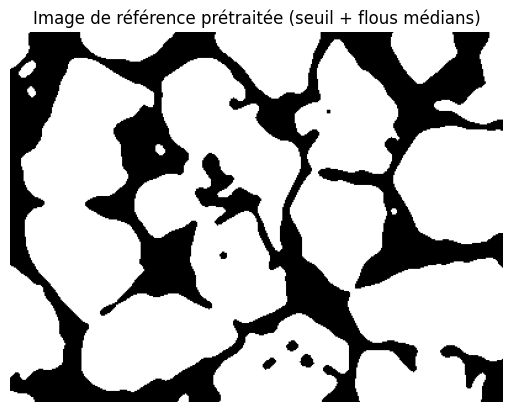

In [7]:
# ✅ Visualisation de contrôle de l'image prétraitée
plt.imshow(Blur_Med_4_img, cmap='gray')
plt.title("Image de référence prétraitée (seuil + flous médians)")
plt.axis('off')
plt.show()

La figure affiche l’image de référence après le prétraitement par seuillage binaire et flous médians. Les grains apparaissent en zones blanches compactes, bien séparées du fond noir. Cette visualisation confirme que le prétraitement supprime une grande partie du bruit tout en conservant correctement les contours des grains, ce qui prépare l’image pour les calculs ultérieurs d’interceptions et de mesures géométriques.

# Section 2 — Méthode Line Intercept avec seuil manuel  

Cette section met en place la **méthode des interceptions linéaires** sur l’image de référence prétraitée. L’idée est de compter combien de fois les contours des grains coupent des lignes horizontales et verticales, afin de relier ces comptages à une taille moyenne de grain. On commence ici par un bloc d’expérimentation sur une seule image pour valider la logique du comptage avant de la généraliser à tout le jeu de données.  

In [8]:
# 🧪 Étape 5 — Comptage d’interceptions sur l'image de référence (PRACTICE)

value_intercept = 255  # valeur de transition à compter

Total_Grains_X_practice = np.zeros(numrows, dtype=np.float32)
Total_Grains_Y_practice = np.zeros(numcols, dtype=np.float32)

# Comptage horizontal
for x in range(numrows):
    count = 0
    for element in diff_x[x, :]:
        if element == value_intercept:
            count += 1
    Total_Grains_X_practice[x] = count

# Comptage vertical
for y in range(numcols - 1):
    count = 0
    for element in diff_y[:, y]:
        if element == value_intercept:
            count += 1
    Total_Grains_Y_practice[y] = count

print("[PRACTICE] Total_Grains_X (extrait 20 premières lignes) :")
print(Total_Grains_X_practice[:20])
print("[PRACTICE] Total_Grains_Y (extrait 20 premières colonnes) :")
print(Total_Grains_Y_practice[:20])
print("Shape X (practice) :", Total_Grains_X_practice.shape,
      "| Shape Y (practice) :", Total_Grains_Y_practice.shape)

[PRACTICE] Total_Grains_X (extrait 20 premières lignes) :
[4. 4. 4. 4. 4. 4. 5. 5. 5. 5. 5. 5. 5. 5. 5. 5. 5. 5. 5. 5.]
[PRACTICE] Total_Grains_Y (extrait 20 premières colonnes) :
[2. 2. 2. 2. 2. 2. 2. 3. 3. 4. 4. 4. 5. 5. 6. 7. 6. 6. 6. 6.]
Shape X (practice) : (300,) | Shape Y (practice) : (400,)


Ce bloc calcule, pour chaque ligne horizontale et chaque colonne verticale de l’image de référence, le **nombre d’interceptions** entre les grains et les lignes d’exploration. À partir des cartes de différences `diff_x` (horizontale) et `diff_y` (verticale), le code compte le nombre de transitions correspondant à la valeur choisie (`value_intercept = 255`) et stocke ces comptages dans deux vecteurs :  
- `Total_Grains_X_practice` pour les lignes horizontales ;  
- `Total_Grains_Y_practice` pour les colonnes verticales.  
Les impressions montrent, pour les 20 premières lignes et colonnes, des valeurs typiquement comprises entre 2 et 7 interceptions, ainsi que les dimensions complètes des vecteurs (`300` lignes, `400` colonnes). Ce bloc sert donc de **validation pédagogique** : il confirme que la méthode Line Intercept repère bien les coupures des grains sur l’image de référence avant de l’étendre à l’ensemble des micrographies.

[INFO] Nombre total d'images disponibles : 336
[INFO] Nombre d'images utilisées pour la méthode des intercepts : 336
Dimensions Total_Grains_X : (300, 336)
Dimensions Total_Grains_Y : (400, 336)
[1/336] Traitement image : A_01_01.png
[2/336] Traitement image : A_01_02.png
[3/336] Traitement image : A_01_03.png
[4/336] Traitement image : A_01_04.png
[5/336] Traitement image : A_02_01.png
[6/336] Traitement image : A_02_02.png
[7/336] Traitement image : A_02_03.png
[8/336] Traitement image : A_02_04.png
[9/336] Traitement image : A_03_01.png
[10/336] Traitement image : A_03_02.png
[11/336] Traitement image : A_03_03.png
[12/336] Traitement image : A_03_04.png
[13/336] Traitement image : A_04_01.png
[14/336] Traitement image : A_04_02.png
[15/336] Traitement image : A_04_03.png
[16/336] Traitement image : A_04_04.png
[17/336] Traitement image : B_01_01.png
[18/336] Traitement image : B_01_02.png
[19/336] Traitement image : B_01_03.png
[20/336] Traitement image : B_01_04.png
[21/336] Trait

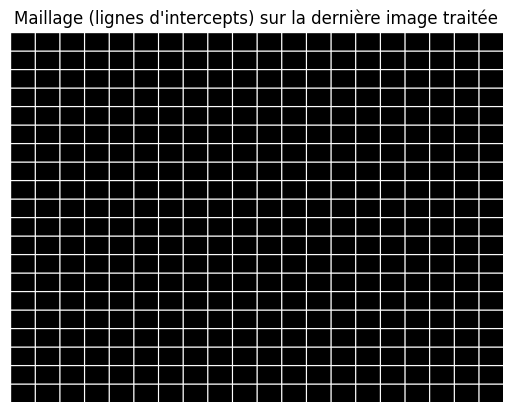

AVG_GrainX_ManThresh shape : (300, 336)
AVG_GrainY_ManThresh shape : (400, 336)
[SAVE] CSV sauvegardés dans :
    /content/drive/MyDrive/cheighr/Total_Grains_X_ManThresh.csv
    /content/drive/MyDrive/cheighr/Total_Grains_Y_ManThresh.csv
    /content/drive/MyDrive/cheighr/AVG_GrainX_ManThresh.csv
    /content/drive/MyDrive/cheighr/AVG_GrainY_ManThresh.csv

[STATS GLOBALES — Méthode des intercepts / seuil manuel]
meanX (µm) : 18.469652
meanY (µm) : 15.702522
STDX  (µm) : 9.128215
STDY  (µm) : 14.4650955


In [9]:
# 📦 Étapes 6 à 11 — Méthode des intercepts sur TOUTES les images de Grains

# 1️⃣ Sélection du nombre d'images utilisées
#    Ici on prend toutes les images disponibles, mais tu peux
#    fixer max_images_line_intercept à une valeur plus petite si nécessaire.
max_images_line_intercept = len(image_files)  # utiliser toutes les images
n = min(max_images_line_intercept, len(image_files))

print(f"[INFO] Nombre total d'images disponibles : {len(image_files)}")
print(f"[INFO] Nombre d'images utilisées pour la méthode des intercepts : {n}")

# 2️⃣ Initialisation des matrices 2D : une colonne par image
Total_Grains_X = np.zeros((numrows, n), dtype=np.float32)
Total_Grains_Y = np.zeros((numcols, n), dtype=np.float32)

print("Dimensions Total_Grains_X :", Total_Grains_X.shape)
print("Dimensions Total_Grains_Y :", Total_Grains_Y.shape)

value_intercept = 255      # valeur de transition à compter
N_LINES_GRID    = 20       # nombre de lignes horizontales / verticales pour le maillage

# 3️⃣ Boucle sur toutes les images sélectionnées
for t in range(n):

    fname = image_files[t]
    img_path = IMG_DIR / fname
    print(f"[{t+1}/{n}] Traitement image :", fname)

    img_gray = cv2.imread(str(img_path), cv2.IMREAD_GRAYSCALE)
    if img_gray is None:
        raise FileNotFoundError(f"Impossible de lire l'image : {img_path}")

    # Vérification de la taille : on impose la même taille que l'image de référence
    if img_gray.shape != IMG_SHAPE_REF:
        raise ValueError(
            f"Image {fname} de taille {img_gray.shape}, "
            f"différente de la taille de référence {IMG_SHAPE_REF}"
        )

    # 🔹 Pipeline de prétraitement identique à l'étape de référence
    Blur_Med_4_img_t = manual_threshold_and_blur(img_gray, thresh_value=135)

    # 🔹 Maillage : 20 lignes horizontales + 20 verticales
    black = np.zeros_like(Blur_Med_4_img_t)

    # Lignes horizontales
    for i in range(N_LINES_GRID):
        y = int(i * img_gray.shape[0] / N_LINES_GRID)
        cv2.line(black, (0, y), (img_gray.shape[1], y), (255, 255, 255), 1)

    # Lignes verticales
    for i in range(N_LINES_GRID):
        x = int(i * img_gray.shape[1] / N_LINES_GRID)
        cv2.line(black, (x, 0), (x, img_gray.shape[0]), (255, 255, 255), 1)

    # 🔹 Intersection lignes × image prétraitée
    result = cv2.bitwise_and(black, Blur_Med_4_img_t)

    diff_x_t = np.diff(result, axis=1)
    diff_y_t = np.diff(result, axis=0)

    # 🔹 Comptage des interceptions sur cette image
    for x in range(numrows):
        count = 0
        for element in diff_x_t[x, :]:
            if element == value_intercept:
                count += 1
        Total_Grains_X[x, t] = count

    for y in range(numcols - 1):
        count = 0
        for element in diff_y_t[:, y]:
            if element == value_intercept:
                count += 1
        Total_Grains_Y[y, t] = count

# 4️⃣ Visualisation du dernier maillage (contrôle visuel)
plt.imshow(black, cmap='gray')
plt.title("Maillage (lignes d'intercepts) sur la dernière image traitée")
plt.axis('off')
plt.show()

# 5️⃣ Remplacement des zéros pour éviter les divisions par 0
Total_Grains_X[Total_Grains_X == 0] = 1
Total_Grains_Y[Total_Grains_Y == 0] = 1

# 6️⃣ Tailles moyennes des grains (méthode des intercepts)
AVG_GrainX_ManThresh = ROW_LENGTH_MICRONS / Total_Grains_X
AVG_GrainY_ManThresh = COL_LENGTH_MICRONS / Total_Grains_Y

print("AVG_GrainX_ManThresh shape :", AVG_GrainX_ManThresh.shape)
print("AVG_GrainY_ManThresh shape :", AVG_GrainY_ManThresh.shape)

# 7️⃣ Sauvegarde des CSV dans ton dossier de projet sur Drive
out_TGX = BASE_DIR / "Total_Grains_X_ManThresh.csv"
out_TGY = BASE_DIR / "Total_Grains_Y_ManThresh.csv"
out_AX  = BASE_DIR / "AVG_GrainX_ManThresh.csv"
out_AY  = BASE_DIR / "AVG_GrainY_ManThresh.csv"

np.savetxt(str(out_TGX), Total_Grains_X, delimiter=",")
np.savetxt(str(out_TGY), Total_Grains_Y, delimiter=",")
np.savetxt(str(out_AX),  AVG_GrainX_ManThresh, delimiter=",")
np.savetxt(str(out_AY),  AVG_GrainY_ManThresh, delimiter=",")

print("[SAVE] CSV sauvegardés dans :")
print("   ", out_TGX)
print("   ", out_TGY)
print("   ", out_AX)
print("   ", out_AY)

# 8️⃣ Statistiques globales (moyenne & écart-type)
meanX = np.mean(AVG_GrainX_ManThresh)
meanY = np.mean(AVG_GrainY_ManThresh)
STDX  = np.std(AVG_GrainX_ManThresh)
STDY  = np.std(AVG_GrainY_ManThresh)

print("\n[STATS GLOBALES — Méthode des intercepts / seuil manuel]")
print("meanX (µm) :", meanX)
print("meanY (µm) :", meanY)
print("STDX  (µm) :", STDX)
print("STDY  (µm) :", STDY)

Ce bloc applique la méthode des interceptions linéaires à l’ensemble des 336 micrographies de grains : pour chaque image, il vérifie la taille, applique le même prétraitement que sur l’image de référence (seuil manuel puis flous médians), superpose un maillage régulier de 20 lignes horizontales et 20 lignes verticales, calcule les cartes de différences sur l’intersection maillage × image prétraitée, puis compte le nombre d’interceptions par ligne et par colonne, ce qui remplit les matrices 2D `Total_Grains_X` (300 × 336) et `Total_Grains_Y` (400 × 336) ; après remplacement des zéros pour éviter les divisions par zéro, les tailles moyennes de grains sont obtenues par direction en divisant les longueurs physiques de référence par les comptages (`AVG_GrainX_ManThresh` et `AVG_GrainY_ManThresh`), ces matrices ainsi que les comptages bruts sont sauvegardés dans quatre fichiers CSV dans le dossier du projet, et les statistiques globales montrent des tailles moyennes d’environ 18,47 µm (horizontalement) et 15,70 µm (verticalement), avec des écarts-types respectifs d’environ 9,13 µm et 14,47 µm, fournissant ainsi une première estimation quantitative de la taille des grains par la méthode des intercepts avec seuil manuel sur tout le jeu de données.

# Section 3 — Méthode Gradient / Canny(version v1)  

Dans cette section, la méthode des interceptions linéaires est réappliquée en remplaçant le seuillage manuel par une détection de contours basée sur le gradient (Canny). L’objectif est d’obtenir une estimation de la taille des grains plus robuste aux variations d’éclairage et de contraste, en s’appuyant sur les frontières détectées automatiquement plutôt que sur un seuil fixe.

In [10]:
# 🔹 Étape 12 — Initialisation de la méthode Gradient (Canny)
#    VERSION COLAB + DRIVE + TOUTES LES IMAGES

VALUE_INTERCEPT = 255  # valeur à compter (binaire)
MAX_IMAGES_GRAD = len(image_files)  # on dispose de toutes les images de Grains
n_grad = min(MAX_IMAGES_GRAD, len(image_files))  # par défaut = toutes

print(f"[GRAD] Nombre total d'images disponibles : {len(image_files)}")
print(f"[GRAD] Nombre d'images utilisées pour la méthode Gradient : {n_grad}")

# Matrices de stockage pour la méthode Gradient (Canny)
Total_Grains_X_grad = np.zeros((numrows, n_grad), dtype=np.float32)
Total_Grains_Y_grad = np.zeros((numcols, n_grad), dtype=np.float32)

print("Dimensions Total_Grains_X_grad :", Total_Grains_X_grad.shape)
print("Dimensions Total_Grains_Y_grad :", Total_Grains_Y_grad.shape)
print("Nombre d'images (n_grad) :", n_grad)

[GRAD] Nombre total d'images disponibles : 336
[GRAD] Nombre d'images utilisées pour la méthode Gradient : 336
Dimensions Total_Grains_X_grad : (300, 336)
Dimensions Total_Grains_Y_grad : (400, 336)
Nombre d'images (n_grad) : 336


Ce bloc prépare la version Gradient de la méthode en fixant la valeur binaire à compter (`VALUE_INTERCEPT = 255`), en choisissant le nombre d’images à traiter (ici les 336 micrographies disponibles) et en initialisant deux matrices de stockage pour les comptages d’interceptions : `Total_Grains_X_grad` de dimension 300 × 336 pour les lignes horizontales et `Total_Grains_Y_grad` de dimension 400 × 336 pour les lignes verticales. Les messages affichés confirment que toutes les images du jeu de données seront utilisées et que les structures de données nécessaires au remplissage des comptages Gradient sont correctement dimensionnées.

[GRAD] Image test (Gradient) : /content/drive/MyDrive/cheighr/Grains/A_01_01.png
[GRAD] Shape image test Gradient : (300, 400)


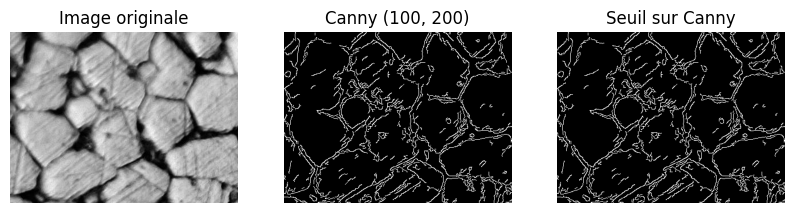

In [11]:
# 🔹 Étape 13 — Test Canny/Gradient sur une image (contrôle visuel)

test_grad_fname = image_files[0]
test_grad_path = IMG_DIR / test_grad_fname
print("[GRAD] Image test (Gradient) :", test_grad_path)

img_grad_test = cv2.imread(str(test_grad_path), cv2.IMREAD_GRAYSCALE)
if img_grad_test is None:
    raise FileNotFoundError(f"Impossible de lire l'image : {test_grad_path}")

print("[GRAD] Shape image test Gradient :", img_grad_test.shape)
if img_grad_test.shape != IMG_SHAPE_REF:
    raise ValueError(
        f"Image test Gradient de taille {img_grad_test.shape}, "
        f"différente de la taille de référence {IMG_SHAPE_REF}"
    )

# 1) Détection de contours par Canny
canny_test = cv2.Canny(img_grad_test, 100, 200)

# 2) Seuil sur l’image Canny
_, threshCAN_test = cv2.threshold(canny_test, 90, 255, cv2.THRESH_BINARY)

plt.figure(figsize=(10, 10))
plt.subplot(1, 3, 1); plt.imshow(img_grad_test,  cmap="gray"); plt.title("Image originale");  plt.axis("off")
plt.subplot(1, 3, 2); plt.imshow(canny_test,    cmap="gray"); plt.title("Canny (100, 200)"); plt.axis("off")
plt.subplot(1, 3, 3); plt.imshow(threshCAN_test, cmap="gray"); plt.title("Seuil sur Canny");  plt.axis("off")
plt.show()

Ce bloc illustre, sur une image test, le fonctionnement de la méthode Gradient : l’image originale est d’abord chargée et vérifiée (même taille que la référence), puis le détecteur de contours de Canny est appliqué avec les seuils (100, 200), ce qui fait ressortir les frontières des grains sous forme de traits fins ; un seuillage supplémentaire est ensuite appliqué sur la sortie de Canny pour obtenir une image binaire claire des contours, et les trois vues (originale, Canny, seuil sur Canny) permettent de vérifier visuellement que les bords des grains sont correctement capturés avant de passer au comptage systématique des interceptions sur tout le jeu de données.

In [12]:
# 🔹 Étape 14 — Boucle Line Intercept (méthode Gradient/Canny)
#     VERSION COLAB + DRIVE + TOUTES LES IMAGES

N_LINES_GRID = 20  # même maillage que pour la méthode seuil manuel

for t, fname in enumerate(image_files[:n_grad]):

    img_path = IMG_DIR / fname
    print(f"[GRAD] Image {t+1}/{n_grad} :", img_path.name)

    # Lecture en niveaux de gris
    img = cv2.imread(str(img_path), cv2.IMREAD_GRAYSCALE)
    if img is None:
        raise FileNotFoundError(f"Impossible de lire l'image : {img_path}")

    # Vérification taille cohérente
    if img.shape != IMG_SHAPE_REF:
        raise ValueError(
            f"[GRAD] Image {fname} de taille {img.shape}, "
            f"différente de la taille de référence {IMG_SHAPE_REF}"
        )

    # 1) Détection de contours par Canny
    canny = cv2.Canny(img, 100, 200)

    # 2) Seuil sur l'image Canny
    _, threshCAN = cv2.threshold(canny, 90, 255, cv2.THRESH_BINARY)

    # 3) Création du maillage de 20 lignes horizontales et 20 verticales
    black = np.zeros_like(threshCAN)

    # Lignes horizontales
    for i in range(N_LINES_GRID):
        y = int(i * black.shape[0] / N_LINES_GRID)
        cv2.line(black, (0, y), (black.shape[1] - 1, y), 255, 1)

    # Lignes verticales
    for i in range(N_LINES_GRID):
        x = int(i * black.shape[1] / N_LINES_GRID)
        cv2.line(black, (x, 0), (x, black.shape[0] - 1), 255, 1)

    # 4) Intersection maillage × image segmentée (Canny + seuil)
    result = cv2.bitwise_and(black, threshCAN)

    # 5) Différences horizontales et verticales
    diff_x = np.diff(result, axis=1)
    diff_y = np.diff(result, axis=0)

    # 6) Comptage des interceptions sur les lignes (X)
    for x in range(numrows):
        count = 0
        for element in diff_x[x, :]:
            if element == VALUE_INTERCEPT:
                count += 1
        Total_Grains_X_grad[x, t] = count

    # 7) Comptage des interceptions sur les colonnes (Y)
    for y in range(numcols - 1):
        count = 0
        for element in diff_y[:, y]:
            if element == VALUE_INTERCEPT:
                count += 1
        Total_Grains_Y_grad[y, t] = count

print("✅ [GRAD] Boucle Gradient/Canny terminée.")

[GRAD] Image 1/336 : A_01_01.png
[GRAD] Image 2/336 : A_01_02.png
[GRAD] Image 3/336 : A_01_03.png
[GRAD] Image 4/336 : A_01_04.png
[GRAD] Image 5/336 : A_02_01.png
[GRAD] Image 6/336 : A_02_02.png
[GRAD] Image 7/336 : A_02_03.png
[GRAD] Image 8/336 : A_02_04.png
[GRAD] Image 9/336 : A_03_01.png
[GRAD] Image 10/336 : A_03_02.png
[GRAD] Image 11/336 : A_03_03.png
[GRAD] Image 12/336 : A_03_04.png
[GRAD] Image 13/336 : A_04_01.png
[GRAD] Image 14/336 : A_04_02.png
[GRAD] Image 15/336 : A_04_03.png
[GRAD] Image 16/336 : A_04_04.png
[GRAD] Image 17/336 : B_01_01.png
[GRAD] Image 18/336 : B_01_02.png
[GRAD] Image 19/336 : B_01_03.png
[GRAD] Image 20/336 : B_01_04.png
[GRAD] Image 21/336 : B_02_01.png
[GRAD] Image 22/336 : B_02_02.png
[GRAD] Image 23/336 : B_02_03.png
[GRAD] Image 24/336 : B_02_04.png
[GRAD] Image 25/336 : B_03_01.png
[GRAD] Image 26/336 : B_03_02.png
[GRAD] Image 27/336 : B_03_03.png
[GRAD] Image 28/336 : B_03_04.png
[GRAD] Image 29/336 : B_04_01.png
[GRAD] Image 30/336 : B

Ce bloc applique la méthode Gradient/Canny à l’ensemble des 336 micrographies : pour chaque image, il vérifie d’abord qu’elle a la même taille que l’image de référence, calcule les contours avec Canny, binarise cette carte de contours, superpose un maillage régulier de 20 lignes horizontales et 20 lignes verticales, puis intersecte ce maillage avec l’image segmentée ; à partir du résultat, il calcule les différences horizontales et verticales et compte, pour chaque ligne et chaque colonne, le nombre de transitions égales à `VALUE_INTERCEPT`, ce qui remplit progressivement les matrices `Total_Grains_X_grad` et `Total_Grains_Y_grad` avec les comptages d’interceptions pour toutes les images, comme le confirment les messages de progression et la validation finale indiquant que la boucle Gradient/Canny est terminée.

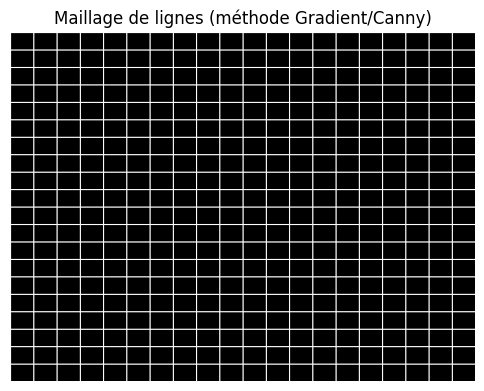

In [13]:
# 🔹 Étape 15 — Visualisation du maillage Gradient

plt.figure(figsize=(6, 6))
plt.imshow(black, cmap="gray")  # 'black' correspond à la dernière image de la boucle précédente
plt.title("Maillage de lignes (méthode Gradient/Canny)")
plt.axis("off")
plt.show()

Cette figure montre le maillage utilisé pour la méthode Gradient/Canny : un réseau régulier de lignes horizontales et verticales superposé aux images, qui définit les trajectoires le long desquelles on compte les interceptions avec les contours des grains ; cette visualisation permet de vérifier que la grille couvre bien toute l’image et que le pas choisi (20 lignes dans chaque direction) est cohérent avant de s’appuyer sur ces lignes pour les calculs de tailles moyennes.

In [14]:
# 🔹 Étape 16 — Post-traitement & conversion en AVG_GrainX_Grad / AVG_GrainY_Grad

# Copie dans des variables dédiées à la méthode Gradient
TGX_grad = Total_Grains_X_grad.copy()
TGY_grad = Total_Grains_Y_grad.copy()

# Remplacer les zéros par 1 (éviter division par 0)
TGX_grad[TGX_grad == 0] = 1
TGY_grad[TGY_grad == 0] = 1

# Tailles moyennes des grains (méthode Gradient), en microns
AVG_GrainX_Grad = ROW_LENGTH_MICRONS / TGX_grad
AVG_GrainY_Grad = COL_LENGTH_MICRONS / TGY_grad

print("AVG_GrainX_Grad shape :", AVG_GrainX_Grad.shape)
print("AVG_GrainY_Grad shape :", AVG_GrainY_Grad.shape)

AVG_GrainX_Grad shape : (300, 336)
AVG_GrainY_Grad shape : (400, 336)


Ce bloc réalise le post-traitement des comptages obtenus avec la méthode Gradient/Canny : les matrices `Total_Grains_X_grad` et `Total_Grains_Y_grad` sont d’abord copiées dans `TGX_grad` et `TGY_grad`, puis tous les zéros y sont remplacés par 1 afin d’éviter toute division par zéro ; à partir des longueurs physiques de référence des lignes horizontales et verticales (`ROW_LENGTH_MICRONS` et `COL_LENGTH_MICRONS`), le code calcule ensuite les matrices `AVG_GrainX_Grad` et `AVG_GrainY_Grad`, qui contiennent pour chaque ligne/colonne de chaque image une taille moyenne de grain exprimée en microns, comme le confirment les dimensions finales (300 × 336 pour la direction X et 400 × 336 pour la direction Y).

In [15]:
# 🔹 Étape 17 — Statistiques globales (méthode Gradient)

meanXGrad = np.mean(AVG_GrainX_Grad)
STDXGrad  = np.std(AVG_GrainX_Grad)

meanYGrad = np.mean(AVG_GrainY_Grad)
STDYGrad  = np.std(AVG_GrainY_Grad)

print("[GRAD] meanXGrad :", meanXGrad)
print("[GRAD] meanYGrad :", meanYGrad)
print("[GRAD] STDXGrad  :", STDXGrad)
print("[GRAD] STDYGrad  :", STDYGrad)

[GRAD] meanXGrad : 68.47045
[GRAD] meanYGrad : 51.382805
[GRAD] STDXGrad  : 52.29283
[GRAD] STDYGrad  : 38.448326


Ce bloc synthétise les résultats de la méthode Gradient/Canny en calculant des statistiques globales sur les tailles moyennes de grains obtenues : la moyenne horizontale `meanXGrad` est d’environ 68,47 µm et la moyenne verticale `meanYGrad` d’environ 51,38 µm, tandis que les écarts-types `STDXGrad` et `STDYGrad` atteignent respectivement 52,29 µm et 38,45 µm ; ces valeurs indiquent que, selon cette méthode basée sur les contours Canny, les tailles estimées sont en moyenne sensiblement plus élevées et plus dispersées que celles issues du seuillage manuel, ce qui devra être discuté dans la comparaison des méthodes (sensibilité au paramétrage de Canny, à la structure du maillage et à la complexité des contours détectés).

In [16]:
# 🔹 Étape 18 — Sauvegarde des résultats Gradient en CSV (dans BASE_DIR)

out_TGX_grad = BASE_DIR / "Total_Grains_X_Grad.csv"
out_TGY_grad = BASE_DIR / "Total_Grains_Y_Grad.csv"
out_AX_grad  = BASE_DIR / "AVG_GrainX_Grad.csv"
out_AY_grad  = BASE_DIR / "AVG_GrainY_Grad.csv"

np.savetxt(str(out_TGX_grad), Total_Grains_X_grad, delimiter=",")
np.savetxt(str(out_TGY_grad), Total_Grains_Y_grad, delimiter=",")
np.savetxt(str(out_AX_grad),  AVG_GrainX_Grad,    delimiter=",")
np.savetxt(str(out_AY_grad),  AVG_GrainY_Grad,    delimiter=",")

print("✅ [GRAD] Fichiers CSV Gradient sauvegardés dans :")
print("   ", out_TGX_grad)
print("   ", out_TGY_grad)
print("   ", out_AX_grad)
print("   ", out_AY_grad)

✅ [GRAD] Fichiers CSV Gradient sauvegardés dans :
    /content/drive/MyDrive/cheighr/Total_Grains_X_Grad.csv
    /content/drive/MyDrive/cheighr/Total_Grains_Y_Grad.csv
    /content/drive/MyDrive/cheighr/AVG_GrainX_Grad.csv
    /content/drive/MyDrive/cheighr/AVG_GrainY_Grad.csv


Ce bloc finalise la méthode Gradient/Canny en exportant tous les résultats vers des fichiers CSV dans le dossier du projet : les matrices de comptage des interceptions `Total_Grains_X_Grad` et `Total_Grains_Y_Grad` sont sauvegardées, ainsi que les matrices de tailles moyennes de grains `AVG_GrainX_Grad` et `AVG_GrainY_Grad`, ce qui permet de conserver une trace complète des calculs effectués pour chaque image et de réutiliser ces résultats ultérieurement dans le rapport, pour des analyses complémentaires ou des comparaisons systématiques avec les autres méthodes de mesure.

# Section 4 — Méthode Gradient / Canny (version v2 avec masques filtrés)  

Dans cette section, la méthode Gradient est améliorée en ajoutant une chaîne complète de filtrage morphologique pour produire des masques de contours plus propres avant le comptage des interceptions. L’objectif est d’obtenir des frontières de grains plus continues et moins bruitées que dans la version précédente, afin de rendre les estimations de taille de grain plus stables sur l’ensemble des images.

[GRAD FULL] Image test (pipeline Grad complet) : /content/drive/MyDrive/cheighr/Grains/A_01_01.png


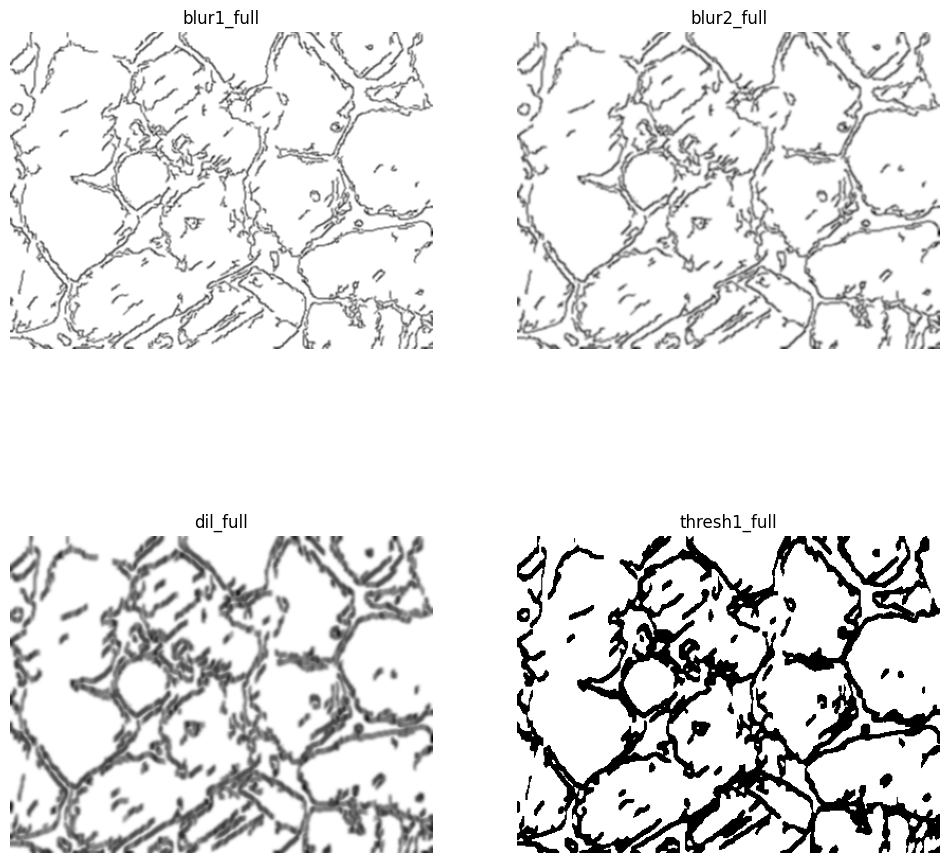

In [17]:
# 🔹 Étape 19 — Pipeline Gradient complet sur une image
#    (Canny + morphologie + seuil 190)

test_grad_full_path = IMG_DIR / image_files[0]
print("[GRAD FULL] Image test (pipeline Grad complet) :", test_grad_full_path)

img_grad_full = cv2.imread(str(test_grad_full_path), cv2.IMREAD_GRAYSCALE)
if img_grad_full is None:
    raise FileNotFoundError(f"Impossible de lire l'image : {test_grad_full_path}")

if img_grad_full.shape != IMG_SHAPE_REF:
    raise ValueError(
        f"[GRAD FULL] Image test de taille {img_grad_full.shape}, "
        f"différente de la taille de référence {IMG_SHAPE_REF}"
    )

# 1) Canny
canny_full = cv2.Canny(img_grad_full, 100, 200)

# 2) Seuil binaire inverse sur Canny
_, threshCAN_full = cv2.threshold(canny_full, 90, 255, cv2.THRESH_BINARY_INV)

# 3) Pipeline morphologique (comme notebook Grad)
blur1_full = cv2.GaussianBlur(threshCAN_full, (3, 3), 0)
blur2_full = cv2.GaussianBlur(blur1_full,     (3, 3), 0)
dil_full   = cv2.erode(blur2_full, (5, 5))
dil_full   = cv2.erode(dil_full,   (5, 5))
dil_full   = cv2.GaussianBlur(dil_full, (3, 3), 0)
dil_full   = cv2.GaussianBlur(dil_full, (3, 3), 0)
dil_full   = cv2.erode(dil_full,   (5, 5))

# 4) Seuil final à 190
thresh1_full = cv2.threshold(dil_full, 190, 255, cv2.THRESH_BINARY)[1]

plt.figure(figsize=(12, 12))
plt.subplot(2, 2, 1); plt.imshow(blur1_full,   cmap='gray'); plt.title("blur1_full");   plt.axis("off")
plt.subplot(2, 2, 2); plt.imshow(blur2_full,   cmap='gray'); plt.title("blur2_full");   plt.axis("off")
plt.subplot(2, 2, 3); plt.imshow(dil_full,     cmap='gray'); plt.title("dil_full");     plt.axis("off")
plt.subplot(2, 2, 4); plt.imshow(thresh1_full, cmap='gray'); plt.title("thresh1_full"); plt.axis("off")
plt.show()

Ce bloc illustre le pipeline Gradient complet sur une image test : après avoir chargé l’image et vérifié sa taille, il applique d’abord Canny pour détecter les contours, puis un seuillage binaire inverse pour isoler ces contours ; une série de filtrages morphologiques (flous gaussiens successifs puis érosions) est ensuite utilisée pour lisser les bords et combler les discontinuités, avant d’appliquer un seuil final à 190 qui produit un masque binaire net (`thresh1_full`) où les grains apparaissent sous forme de zones blanches bien délimitées, comme le montrent les quatre sous-figures (blur1_full, blur2_full, dil_full, thresh1_full) qui permettent de visualiser l’effet progressif de chaque étape de filtrage.

In [18]:
# 🔹 Étape 20 — Génération des masques de contours filtrés (area > 100)
#    VERSION COLAB + DRIVE — réutilise FILTERED_GRAD_DIR

GRAD_OUT_DIR = FILTERED_GRAD_DIR
GRAD_OUT_DIR.mkdir(exist_ok=True)

print("Dossier de sortie des masques Gradient :", GRAD_OUT_DIR)

black_mask_grad = None  # sera mis à jour à chaque itération

for t, fname in enumerate(image_files[:n_grad]):

    img_path = IMG_DIR / fname
    img = cv2.imread(str(img_path), cv2.IMREAD_GRAYSCALE)
    if img is None:
        raise FileNotFoundError(f"Impossible de lire l'image : {img_path}")

    # 1) Canny
    canny = cv2.Canny(img, 100, 200)

    # 2) Seuil binaire inverse sur Canny
    _, threshCAN = cv2.threshold(canny, 90, 255, cv2.THRESH_BINARY_INV)

    # 3) Pipeline morphologique (comme Étape 19)
    blur1 = cv2.GaussianBlur(threshCAN, (3, 3), 0)
    blur2 = cv2.GaussianBlur(blur1,     (3, 3), 0)
    dil   = cv2.erode(blur2, (5, 5))
    dil   = cv2.erode(dil,   (5, 5))
    dil   = cv2.GaussianBlur(dil, (3, 3), 0)
    dil   = cv2.GaussianBlur(dil, (3, 3), 0)
    dil   = cv2.erode(dil,   (5, 5))

    thresh1 = cv2.threshold(dil, 190, 255, cv2.THRESH_BINARY)[1]

    # 4) Contours externes sur l’image binaire propre
    _, binary = cv2.threshold(thresh1, 127, 255, cv2.THRESH_BINARY)
    contours, _ = cv2.findContours(binary, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_NONE)

    # 5) Masque noir puis remplissage des grains d’aire > 100
    black_mask_grad = np.zeros_like(img)

    for c in contours:
        if cv2.contourArea(c) > 100:  # seuil de surface
            cv2.drawContours(black_mask_grad, [c], -1, (255, 255, 255), -1)

    # 6) Sauvegarde du masque (nom FGRAD_###.png)
    out_name = f"FGRAD_{t+1:03d}.png"
    cv2.imwrite(str(GRAD_OUT_DIR / out_name), black_mask_grad)

print("✅ Masques filtrés Gradient générés et sauvegardés dans :", GRAD_OUT_DIR)

Dossier de sortie des masques Gradient : /content/drive/MyDrive/cheighr/FilteredGradV2
✅ Masques filtrés Gradient générés et sauvegardés dans : /content/drive/MyDrive/cheighr/FilteredGradV2


Ce bloc applique le pipeline Gradient complet à toutes les images pour générer des masques de contours filtrés : pour chaque micrographie, il calcule d’abord les contours avec Canny, applique un seuillage binaire inverse puis une série de filtrages morphologiques (flous gaussiens et érosions) avant un seuil final à 190, extrait ensuite les contours externes sur cette image binaire propre, et remplit en blanc uniquement les grains dont l’aire est supérieure à 100 pixels dans un masque noir ; chaque masque obtenu, beaucoup plus “propre” et débarrassé des petits artefacts, est sauvegardé dans le dossier `FilteredGradV2` sous la forme de fichiers `FGRAD_###.png`, ce qui constitue la base de la version Grad v2 utilisée pour le comptage d’interceptions.

In [19]:
# 🔹 Étape 21 — Comptage des interceptions sur les masques filtrés (version Grad complète)

value = 255  # valeur à compter

Total_Grains_X_grad_v2 = np.zeros((numrows, n_grad), dtype=np.float32)
Total_Grains_Y_grad_v2 = np.zeros((numcols, n_grad), dtype=np.float32)

for t, fname in enumerate(image_files[:n_grad]):

    mask_path = GRAD_OUT_DIR / f"FGRAD_{t+1:03d}.png"
    mask = cv2.imread(str(mask_path), cv2.IMREAD_GRAYSCALE)
    if mask is None:
        raise FileNotFoundError(f"Impossible de lire le masque : {mask_path}")

    if mask.shape != IMG_SHAPE_REF:
        raise ValueError(
            f"[GRAD_v2] Masque {mask_path.name} de taille {mask.shape}, "
            f"différente de la taille de référence {IMG_SHAPE_REF}"
        )

    # Maillage 20×20 sur fond noir
    black = np.zeros_like(mask)

    for i in range(N_LINES_GRID):
        y = int(i * black.shape[0] / N_LINES_GRID)
        cv2.line(black, (0, y), (black.shape[1] - 1, y), 255, 1)

    for i in range(N_LINES_GRID):
        x = int(i * black.shape[1] / N_LINES_GRID)
        cv2.line(black, (x, 0), (x, black.shape[0] - 1), 255, 1)

    # Intersection maillage × masque filtré
    result = cv2.bitwise_and(black, mask)

    # Différences
    diff_x = np.diff(result, axis=1)
    diff_y = np.diff(result, axis=0)

    # Comptage sur les lignes
    for x in range(numrows):
        count = 0
        for element in diff_x[x, :]:
            if element == value:
                count += 1
        Total_Grains_X_grad_v2[x, t] = count

    # Comptage sur les colonnes
    for y in range(numcols - 1):
        count = 0
        for element in diff_y[:, y]:
            if element == value:
                count += 1
        Total_Grains_Y_grad_v2[y, t] = count

print("✅ Comptage des interceptions (version Grad complète) terminé.")
print("   Total_Grains_X_grad_v2 shape :", Total_Grains_X_grad_v2.shape)
print("   Total_Grains_Y_grad_v2 shape :", Total_Grains_Y_grad_v2.shape)

✅ Comptage des interceptions (version Grad complète) terminé.
   Total_Grains_X_grad_v2 shape : (300, 336)
   Total_Grains_Y_grad_v2 shape : (400, 336)


Ce bloc applique la méthode des interceptions linéaires aux masques filtrés générés par la version complète du pipeline Gradient : pour chaque masque `FGRAD_###.png`, il vérifie la taille, construit un maillage 20×20 de lignes horizontales et verticales sur un fond noir, intersecte ce maillage avec le masque binaire filtré, calcule ensuite les différences horizontales et verticales et compte, sur chaque ligne et chaque colonne, le nombre de transitions égales à 255 ; ces comptages remplissent les matrices `Total_Grains_X_grad_v2` (300 × 336) et `Total_Grains_Y_grad_v2` (400 × 336), ce qui fournit pour chaque image et pour chaque ligne/colonne le nombre d’interceptions observées sur les masques “propres” de la version Grad v2.

In [20]:
# 🧹 Étape 22 — Post-traitement & tailles moyennes (Grad v2)
# On part des matrices Total_Grains_X_grad_v2 / Y_grad_v2 déjà remplies (version Grad complète)

# Copie pour post-traitement (on garde les noms v2 pour ne rien écraser)
Total_Grains_X_v2 = Total_Grains_X_grad_v2.copy()
Total_Grains_Y_v2 = Total_Grains_Y_grad_v2.copy()

# Remplacement des zéros par 1 (éviter division par 0)
Total_Grains_X_v2[Total_Grains_X_v2 == 0] = 1
Total_Grains_Y_v2[Total_Grains_Y_v2 == 0] = 1

# Conversion en tailles de grains (Grad v2), en microns
AVG_GrainX_Grad_v2 = ROW_LENGTH_MICRONS / Total_Grains_X_v2
AVG_GrainY_Grad_v2 = COL_LENGTH_MICRONS / Total_Grains_Y_v2

# Vérification de la dernière ligne Y (index -1)
print("Dernière ligne AVG_GrainY_Grad_v2 avant suppression :")
print(AVG_GrainY_Grad_v2[-1, :])

# ⚠️ Option « comme dans le notebook Grad » :
#    on supprime la dernière ligne si on considère qu'elle est aberrante.
#    Tu peux commenter cette ligne si tu veux garder TOUT.
AVG_GrainY_Grad_v2 = np.delete(AVG_GrainY_Grad_v2, -1, axis=0)

print("Nouvelle shape AVG_GrainY_Grad_v2 :", AVG_GrainY_Grad_v2.shape)

Dernière ligne AVG_GrainY_Grad_v2 avant suppression :
[133.33333 133.33333 133.33333 133.33333 133.33333 133.33333 133.33333
 133.33333 133.33333 133.33333 133.33333 133.33333 133.33333 133.33333
 133.33333 133.33333 133.33333 133.33333 133.33333 133.33333 133.33333
 133.33333 133.33333 133.33333 133.33333 133.33333 133.33333 133.33333
 133.33333 133.33333 133.33333 133.33333 133.33333 133.33333 133.33333
 133.33333 133.33333 133.33333 133.33333 133.33333 133.33333 133.33333
 133.33333 133.33333 133.33333 133.33333 133.33333 133.33333 133.33333
 133.33333 133.33333 133.33333 133.33333 133.33333 133.33333 133.33333
 133.33333 133.33333 133.33333 133.33333 133.33333 133.33333 133.33333
 133.33333 133.33333 133.33333 133.33333 133.33333 133.33333 133.33333
 133.33333 133.33333 133.33333 133.33333 133.33333 133.33333 133.33333
 133.33333 133.33333 133.33333 133.33333 133.33333 133.33333 133.33333
 133.33333 133.33333 133.33333 133.33333 133.33333 133.33333 133.33333
 133.33333 133.33333 13

Ce bloc réalise le post-traitement de la version Grad v2 : les matrices de comptage `Total_Grains_X_grad_v2` et `Total_Grains_Y_grad_v2` sont copiées, les valeurs nulles sont remplacées par 1 pour éviter les divisions par zéro, puis converties en tailles moyennes de grains en microns (`AVG_GrainX_Grad_v2` et `AVG_GrainY_Grad_v2`) à partir des longueurs physiques de référence ; la dernière ligne de `AVG_GrainY_Grad_v2` est ensuite inspectée et montre des valeurs constantes très élevées (133,33 µm) sur toutes les images, interprétées comme aberrantes, et elle est donc supprimée, ce qui ramène la matrice verticale à une dimension de 399 × 336 et aligne la version Grad v2 sur le comportement observé dans le notebook de référence.


# Section 5 — Initialisation & Line Intercept avec HED  

Cette section ouvre la troisième chaîne de mesure basée sur le détecteur de contours HED. L’idée est de préparer une nouvelle famille de masques de contours, indépendante du seuillage manuel et de la méthode Gradient/Canny, puis d’appliquer à nouveau la méthode des interceptions linéaires pour obtenir des tailles moyennes de grains basées sur HED. Avant de lancer le traitement HED proprement dit, le notebook commence par figer et exporter les résultats de la version Gradient filtrée (Grad v2), qui serviront de référence pour la comparaison.


In [21]:
# 📈 Étape 23 — Statistiques globales & export CSV (Grad v2)

# Statistiques Grad v2
meanXGrad_v2 = np.mean(AVG_GrainX_Grad_v2)
STDXGrad_v2  = np.std(AVG_GrainX_Grad_v2)

meanYGrad_v2 = np.mean(AVG_GrainY_Grad_v2)
STDYGrad_v2  = np.std(AVG_GrainY_Grad_v2)

print("Grad v2 — meanXGrad_v2 :", meanXGrad_v2)
print("Grad v2 — meanYGrad_v2 :", meanYGrad_v2)
print("Grad v2 — STDXGrad_v2  :", STDXGrad_v2)
print("Grad v2 — STDYGrad_v2  :", STDYGrad_v2)

# Sauvegarde en CSV dans ton dossier projet sur Drive
np.savetxt(str(BASE_DIR / "Total_Grains_X_Grad_v2.csv"), Total_Grains_X_grad_v2, delimiter=",")
np.savetxt(str(BASE_DIR / "Total_Grains_Y_Grad_v2.csv"), Total_Grains_Y_grad_v2, delimiter=",")
np.savetxt(str(BASE_DIR / "AVG_GrainX_Grad_v2.csv"),     AVG_GrainX_Grad_v2,     delimiter=",")
np.savetxt(str(BASE_DIR / "AVG_GrainY_Grad_v2.csv"),     AVG_GrainY_Grad_v2,     delimiter=",")

print("✅ CSV Grad v2 sauvegardés dans :", BASE_DIR)
print(" - Total_Grains_X_Grad_v2.csv")
print(" - Total_Grains_Y_Grad_v2.csv")
print(" - AVG_GrainX_Grad_v2.csv")
print(" - AVG_GrainY_Grad_v2.csv")

Grad v2 — meanXGrad_v2 : 33.9847
Grad v2 — meanYGrad_v2 : 26.462593
Grad v2 — STDXGrad_v2  : 34.917866
Grad v2 — STDYGrad_v2  : 27.250618
✅ CSV Grad v2 sauvegardés dans : /content/drive/MyDrive/cheighr
 - Total_Grains_X_Grad_v2.csv
 - Total_Grains_Y_Grad_v2.csv
 - AVG_GrainX_Grad_v2.csv
 - AVG_GrainY_Grad_v2.csv


Ce bloc calcule d’abord les statistiques globales associées à la version Grad v2 en prenant la moyenne et l’écart-type des tailles moyennes de grains dans les directions horizontale et verticale (`meanXGrad_v2 ≈ 33,98 µm`, `meanYGrad_v2 ≈ 26,46 µm`, `STDXGrad_v2 ≈ 34,92 µm`, `STDYGrad_v2 ≈ 27,25 µm), ce qui donne une vue d’ensemble du niveau et de la dispersion des tailles estimées avec les masques filtrés ; ces résultats sont ensuite figés en quatre fichiers CSV (`Total_Grains_X_Grad_v2.csv`, `Total_Grains_Y_Grad_v2.csv`, `AVG_GrainX_Grad_v2.csv`, `AVG_GrainY_Grad_v2.csv`) enregistrés dans le dossier du projet, de manière à disposer d’une trace exploitable et directement comparable lorsque les tailles de grains issues de HED seront calculées.

In [22]:
# 🌐 Étape 24 — Initialisation modèle HED (CropLayer + chemins + réseau)

# Dossiers de sortie HED (doivent déjà exister selon ton bloc de config initial)
HED_RAW_DIR = BASE_DIR / "HED_raw"
HED_FILTERED_DIR = BASE_DIR / "HED_filtered"
HED_RAW_DIR.mkdir(parents=True, exist_ok=True)
HED_FILTERED_DIR.mkdir(parents=True, exist_ok=True)

# Chemins vers les poids HED (dossier réel de ton projet)
protoPath = str(WEIGHTS_HED_DIR / "deploy.prototxt")
modelPath = str(WEIGHTS_HED_DIR / "hed_pretrained_bsds.caffemodel")

print("protoPath :", protoPath)
print("modelPath :", modelPath)

# Définition de la CropLayer (copiée du notebook HED)
class CropLayer(object):
    def __init__(self, params, blobs):
        self.startX = 0
        self.startY = 0
        self.endX = 0
        self.endY = 0

    def getMemoryShapes(self, inputs):
        inputShape, targetShape = inputs[0], inputs[1]
        batchSize, numChannels = inputShape[0], inputShape[1]
        H, W = targetShape[2], targetShape[3]

        self.startX = int((inputShape[3] - W) / 2)
        self.startY = int((inputShape[2] - H) / 2)
        self.endX = self.startX + W
        self.endY = self.startY + H

        return [[batchSize, numChannels, H, W]]

    def forward(self, inputs):
        return [inputs[0][:, :, self.startY:self.endY,
                          self.startX:self.endX]]

# Enregistrement de la couche Crop dans OpenCV DNN
cv2.dnn_registerLayer("Crop", CropLayer)

# Chargement du réseau HED pré-entraîné
net_hed = cv2.dnn.readNetFromCaffe(protoPath, modelPath)

# Récupérer H, W de référence à partir de la première image de Grains
test_path = IMG_DIR / image_files[0]
img0 = cv2.imread(str(test_path), cv2.IMREAD_COLOR)
if img0 is None:
    raise FileNotFoundError(f"Impossible de lire l'image : {test_path}")

(H_ref, W_ref) = img0.shape[:2]
print("Taille de référence H×W :", H_ref, "x", W_ref)

print("✅ Modèle HED initialisé.")

protoPath : /content/drive/MyDrive/cheighr/weights HED/deploy.prototxt
modelPath : /content/drive/MyDrive/cheighr/weights HED/hed_pretrained_bsds.caffemodel
Taille de référence H×W : 300 x 400
✅ Modèle HED initialisé.


Ce bloc prépare l’utilisation du modèle HED pour la détection de contours : il crée (ou vérifie) les dossiers de sortie dédiés à HED (`HED_raw` et `HED_filtered`), renseigne les chemins vers les fichiers de poids Caffe (`deploy.prototxt` et `hed_pretrained_bsds.caffemodel`), définit puis enregistre dans OpenCV la couche spéciale `CropLayer` nécessaire au bon fonctionnement du réseau, charge le modèle HED pré-entraîné dans `net_hed`, et récupère enfin la taille de référence de la première image de grains (300 × 400), ce qui assure que le réseau sera appliqué de manière cohérente à toutes les micrographies ; le message final confirme que le modèle HED est correctement initialisé et prêt à être utilisé pour générer des cartes de contours.

Image test HED : /content/drive/MyDrive/cheighr/Grains/A_01_01.png


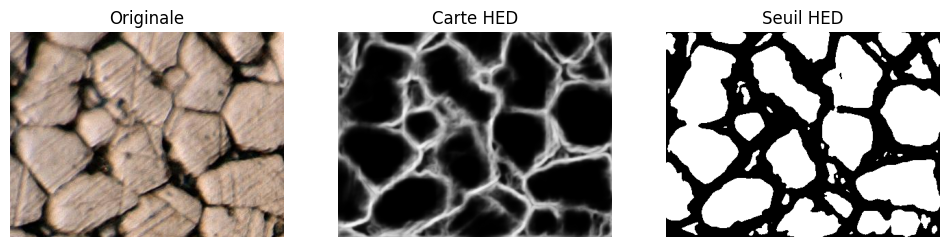

In [23]:
# 👁️ Étape 25 — Fonction apply_hed + test visuel

def apply_hed(img_bgr, net, W_ref, H_ref):
    """
    Reprend la chaîne du notebook HED :
    - blobFromImage(scalefactor=0.7, size=(W_ref, H_ref), mean=(105,117,123))
    - net.forward()
    - rescale 0–255
    - flou gaussien
    - seuil binaire inverse
    Retourne :
      - hed_map   : carte de contours 0–255
      - hed_blur  : carte floutée
      - hed_thresh: image binaire (0 / 255)
    """
    blob = cv2.dnn.blobFromImage(
        img_bgr,
        scalefactor=0.7,
        size=(W_ref, H_ref),
        mean=(105, 117, 123),
        swapRB=False,
        crop=False
    )

    net.setInput(blob)
    hed = net.forward()
    hed = hed[0, 0, :, :]       # (1,1,H,W) → (H,W)
    hed = (255 * hed).astype("uint8")  # 0–1 → 0–255

    hed_blur = cv2.GaussianBlur(hed, (3, 3), 0)
    hed_thresh = cv2.threshold(hed_blur, 40, 250, cv2.THRESH_BINARY_INV)[1]

    return hed, hed_blur, hed_thresh

# Test sur une image
test_hed_path = IMG_DIR / image_files[0]
print("Image test HED :", test_hed_path)

img_test_bgr = cv2.imread(str(test_hed_path), cv2.IMREAD_COLOR)
if img_test_bgr is None:
    raise FileNotFoundError(f"Impossible de lire l'image : {test_hed_path}")

hed_map, hed_blur, hed_thresh = apply_hed(img_test_bgr, net_hed, W_ref=W_ref, H_ref=H_ref)

plt.figure(figsize=(12, 4))
plt.subplot(1, 3, 1); plt.imshow(cv2.cvtColor(img_test_bgr, cv2.COLOR_BGR2RGB)); plt.title("Originale");   plt.axis("off")
plt.subplot(1, 3, 2); plt.imshow(hed_map, cmap="gray");                         plt.title("Carte HED");   plt.axis("off")
plt.subplot(1, 3, 3); plt.imshow(hed_thresh, cmap="gray");                      plt.title("Seuil HED");   plt.axis("off")
plt.show()


Ce bloc définit la fonction `apply_hed`, qui encapsule toute la chaîne HED pour une image couleur : l’image est d’abord transformée en « blob » et passée dans le réseau `net_hed` pour produire une carte de contours (`hed_map`) en niveaux de gris, puis cette carte est légèrement lissée par un flou gaussien (`hed_blur`) avant d’être seuillée pour obtenir une image binaire (`hed_thresh`) où les grains apparaissent comme des régions blanches bien séparées par des joints noirs ; le test visuel sur une micrographie de référence montre successivement l’image originale, la carte HED continue et le résultat seuillé, ce qui permet de vérifier que le modèle met bien en évidence les frontières des grains avant d’appliquer la méthode des interceptions.

In [24]:
# 🧱 Étape 26 — Génération et sauvegarde des cartes HED pour toutes les images de Grains

N_HED = len(image_files)
print(f"[HED raw] Nombre d'images Grains disponibles : {N_HED}")

for t, fname in enumerate(image_files[:N_HED]):
    img_path = IMG_DIR / fname
    print(f"[HED raw] Image {t+1}/{N_HED} :", img_path.name)

    img_bgr = cv2.imread(str(img_path), cv2.IMREAD_COLOR)
    if img_bgr is None:
        raise FileNotFoundError(f"Impossible de lire l'image : {img_path}")

    _, _, hed_thresh = apply_hed(img_bgr, net_hed, W_ref=W_ref, H_ref=H_ref)

    out_name = f"{Path(fname).stem}_HED.png"
    cv2.imwrite(str(HED_RAW_DIR / out_name), hed_thresh)

print("✅ Cartes HED seuillées sauvegardées dans :", HED_RAW_DIR)

[HED raw] Nombre d'images Grains disponibles : 336
[HED raw] Image 1/336 : A_01_01.png
[HED raw] Image 2/336 : A_01_02.png
[HED raw] Image 3/336 : A_01_03.png
[HED raw] Image 4/336 : A_01_04.png
[HED raw] Image 5/336 : A_02_01.png
[HED raw] Image 6/336 : A_02_02.png
[HED raw] Image 7/336 : A_02_03.png
[HED raw] Image 8/336 : A_02_04.png
[HED raw] Image 9/336 : A_03_01.png
[HED raw] Image 10/336 : A_03_02.png
[HED raw] Image 11/336 : A_03_03.png
[HED raw] Image 12/336 : A_03_04.png
[HED raw] Image 13/336 : A_04_01.png
[HED raw] Image 14/336 : A_04_02.png
[HED raw] Image 15/336 : A_04_03.png
[HED raw] Image 16/336 : A_04_04.png
[HED raw] Image 17/336 : B_01_01.png
[HED raw] Image 18/336 : B_01_02.png
[HED raw] Image 19/336 : B_01_03.png
[HED raw] Image 20/336 : B_01_04.png
[HED raw] Image 21/336 : B_02_01.png
[HED raw] Image 22/336 : B_02_02.png
[HED raw] Image 23/336 : B_02_03.png
[HED raw] Image 24/336 : B_02_04.png
[HED raw] Image 25/336 : B_03_01.png
[HED raw] Image 26/336 : B_03_02.

Ce bloc applique la fonction HED à l’ensemble des 336 micrographies pour produire, pour chaque image de Grains, une carte de contours seuillée : on parcourt toutes les images une par une, on calcule leur version HED binaire (joints de grains noirs / grains blancs), puis on enregistre ces cartes dans le dossier `HED_raw` sous la forme de fichiers `*_HED.png`. Les logs confirment que toutes les images, de `A_01_01.png` jusqu’à `U_04_04.png`, ont bien été traitées et que l’on dispose maintenant d’un jeu complet de masques HED “bruts” prêt à être filtré puis exploité par la méthode des interceptions.

In [25]:
# 🧼 Étape 27 — Filtrage des petites zones (aire < 100) et images HED filtrées

area_threshold = 100  # ≈ seuil area en pixels²

raw_files = sorted([f for f in os.listdir(HED_RAW_DIR) if f.lower().endswith(".png")])
N_HED_RAW = len(raw_files)
if N_HED_RAW == 0:
    raise RuntimeError(f"Aucun fichier HED_raw trouvé dans {HED_RAW_DIR}. Vérifie l'étape 26.")

print(f"[HED filtered] Nombre d'images HED brutes trouvées : {N_HED_RAW}")

for t, fname in enumerate(raw_files[:N_HED_RAW]):
    img_path = HED_RAW_DIR / fname
    print(f"[HED filtered] Image {t+1}/{N_HED_RAW} :", img_path.name)

    img = cv2.imread(str(img_path))
    if img is None:
        raise FileNotFoundError(f"Impossible de lire l'image : {img_path}")

    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    _, binary = cv2.threshold(gray, 127, 255, cv2.THRESH_BINARY)

    contours, _ = cv2.findContours(binary, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_NONE)

    # Image noire pour garder uniquement les grains assez grands
    black = np.zeros_like(img)

    for c in contours:
        if cv2.contourArea(c) > area_threshold:
            cv2.drawContours(black, [c], -1, (255, 255, 255), -1)
        else:
            # debug : en vert sur l'image originale
            cv2.drawContours(img, [c], -1, (0, 255, 0), 2)

    out_name = f"{Path(fname).stem}_FILT.png"
    cv2.imwrite(str(HED_FILTERED_DIR / out_name), black)

print("✅ Images HED filtrées sauvegardées dans :", HED_FILTERED_DIR)


[HED filtered] Nombre d'images HED brutes trouvées : 336
[HED filtered] Image 1/336 : A_01_01_HED.png
[HED filtered] Image 2/336 : A_01_02_HED.png
[HED filtered] Image 3/336 : A_01_03_HED.png
[HED filtered] Image 4/336 : A_01_04_HED.png
[HED filtered] Image 5/336 : A_02_01_HED.png
[HED filtered] Image 6/336 : A_02_02_HED.png
[HED filtered] Image 7/336 : A_02_03_HED.png
[HED filtered] Image 8/336 : A_02_04_HED.png
[HED filtered] Image 9/336 : A_03_01_HED.png
[HED filtered] Image 10/336 : A_03_02_HED.png
[HED filtered] Image 11/336 : A_03_03_HED.png
[HED filtered] Image 12/336 : A_03_04_HED.png
[HED filtered] Image 13/336 : A_04_01_HED.png
[HED filtered] Image 14/336 : A_04_02_HED.png
[HED filtered] Image 15/336 : A_04_03_HED.png
[HED filtered] Image 16/336 : A_04_04_HED.png
[HED filtered] Image 17/336 : B_01_01_HED.png
[HED filtered] Image 18/336 : B_01_02_HED.png
[HED filtered] Image 19/336 : B_01_03_HED.png
[HED filtered] Image 20/336 : B_01_04_HED.png
[HED filtered] Image 21/336 : B_

Ce bloc prend les 336 cartes HED brutes produites à l’étape précédente et les nettoie en éliminant les plus petites régions, considérées comme du bruit de segmentation : pour chaque image *_HED.png, on repasse en niveaux de gris, on binarise puis on détecte les contours ; on crée ensuite une image noire sur laquelle on ne redessine en blanc que les contours dont l’aire dépasse 100 pixels², tandis que les petits objets sont simplement marqués en vert sur l’image originale à titre de debug. Les nouvelles cartes HED ainsi filtrées, qui ne contiennent plus que des grains suffisamment grands et cohérents, sont sauvegardées dans le dossier `HED_filtered` avec le suffixe `_FILT.png`. Les logs montrent que l’opération a bien été appliquée à l’ensemble des micrographies, de `A_01_01_HED.png` à `U_04_04_HED.png`, ce qui prépare un jeu de masques HED “propres” pour le comptage d’interceptions.

In [26]:
# 📦 Étape 28 — Initialisation des matrices d’interceptions HED

value = 255   # valeur de transition à compter dans diff_x / diff_y

# On se basera sur le nombre d'images HED filtrées, pas sur l'ancien n=40
filt_files = sorted([f for f in os.listdir(HED_FILTERED_DIR) if f.lower().endswith(".png")])
N_HED_FILT = len(filt_files)
if N_HED_FILT == 0:
    raise RuntimeError(f"Aucun fichier HED filtré trouvé dans {HED_FILTERED_DIR}. Vérifie l'étape 27.")

Total_Grains_X_HED = np.zeros((numrows, N_HED_FILT), dtype=np.float32)
Total_Grains_Y_HED = np.zeros((numcols, N_HED_FILT), dtype=np.float32)

print("Total_Grains_X_HED shape :", Total_Grains_X_HED.shape)
print("Total_Grains_Y_HED shape :", Total_Grains_Y_HED.shape)
print("Nombre d'images HED filtrées (N_HED_FILT) :", N_HED_FILT)


Total_Grains_X_HED shape : (300, 336)
Total_Grains_Y_HED shape : (400, 336)
Nombre d'images HED filtrées (N_HED_FILT) : 336


Ce bloc prépare le terrain pour le Line Intercept appliqué aux masques HED filtrés : on commence par lister tous les fichiers *_FILT.png présents dans `HED_FILTERED_DIR` et on vérifie qu’il y en a bien au moins un (sinon on déclenche une erreur, ce qui sécurise le pipeline). Le nombre d’images trouvées `N_HED_FILT` sert directement à dimensionner deux matrices de comptage, `Total_Grains_X_HED` et `Total_Grains_Y_HED`, respectivement de taille (300, 336) et (400, 336) en float32 : chaque ligne représente une position de maillage (300 lignes horizontales, 400 colonnes verticales) et chaque colonne correspond à une micrographie HED filtrée. Initialisées à zéro, ces matrices accueilleront ensuite, pour chaque image, le nombre d’interceptions ligne/grain (X) et colonne/grain (Y) détectées, en comptant les transitions de valeur 255 dans les dérivées `diff_x` et `diff_y`. Les impressions en sortie confirment que les dimensions sont cohérentes avec la grille et que les 336 masques HED filtrés seront bien pris en compte dans la suite de l’analyse.

In [27]:
# 🔁 Étape 29 — Line Intercept sur les images HED filtrées

filt_files = sorted([f for f in os.listdir(HED_FILTERED_DIR) if f.lower().endswith(".png")])
N_HED_FILT = len(filt_files)
if N_HED_FILT == 0:
    raise RuntimeError(f"Aucun fichier HED filtré trouvé dans {HED_FILTERED_DIR}. Vérifie l'étape 27.")

for t, fname in enumerate(filt_files[:N_HED_FILT]):

    img_path = HED_FILTERED_DIR / fname
    print(f"[Line Intercept HED] Image {t+1}/{N_HED_FILT} :", img_path.name)

    img = cv2.imread(str(img_path), cv2.IMREAD_GRAYSCALE)
    if img is None:
        raise FileNotFoundError(f"Impossible de lire l'image : {img_path}")

    # Re-seuil comme dans le notebook (90, 255, THRESH_BINARY)
    _, thresh = cv2.threshold(img, 90, 255, cv2.THRESH_BINARY)

    diff_x = np.diff(thresh, axis=1)
    diff_y = np.diff(thresh, axis=0)

    # Sécurité sur la taille réelle de l’image
    h, w = thresh.shape
    h_eff = min(h, numrows)
    w_eff = min(w, numcols)

    # Lignes (X)
    for x in range(h_eff):
        count = 0
        for element in diff_x[x, :]:
            if element == value:
                count += 1
        Total_Grains_X_HED[x, t] = count

    # Colonnes (Y)
    for y in range(w_eff - 1):
        count = 0
        for element in diff_y[:, y]:
            if element == value:
                count += 1
        Total_Grains_Y_HED[y, t] = count

print("✅ Boucle Line Intercept HED terminée.")

[Line Intercept HED] Image 1/336 : A_01_01_HED_FILT.png
[Line Intercept HED] Image 2/336 : A_01_02_HED_FILT.png
[Line Intercept HED] Image 3/336 : A_01_03_HED_FILT.png
[Line Intercept HED] Image 4/336 : A_01_04_HED_FILT.png
[Line Intercept HED] Image 5/336 : A_02_01_HED_FILT.png
[Line Intercept HED] Image 6/336 : A_02_02_HED_FILT.png
[Line Intercept HED] Image 7/336 : A_02_03_HED_FILT.png
[Line Intercept HED] Image 8/336 : A_02_04_HED_FILT.png
[Line Intercept HED] Image 9/336 : A_03_01_HED_FILT.png
[Line Intercept HED] Image 10/336 : A_03_02_HED_FILT.png
[Line Intercept HED] Image 11/336 : A_03_03_HED_FILT.png
[Line Intercept HED] Image 12/336 : A_03_04_HED_FILT.png
[Line Intercept HED] Image 13/336 : A_04_01_HED_FILT.png
[Line Intercept HED] Image 14/336 : A_04_02_HED_FILT.png
[Line Intercept HED] Image 15/336 : A_04_03_HED_FILT.png
[Line Intercept HED] Image 16/336 : A_04_04_HED_FILT.png
[Line Intercept HED] Image 17/336 : B_01_01_HED_FILT.png
[Line Intercept HED] Image 18/336 : B_01

Dans cette étape, on applique la méthode des interceptions linéaires directement sur les masques HED déjà filtrés (images *_HED_FILT.png issues de l’étape 27). On commence par relister tous les fichiers présents dans `HED_FILTERED_DIR` et vérifier qu’il y en a bien `N_HED_FILT`. Pour chaque masque, l’image est relue en niveaux de gris puis reseuillée à 90 (`THRESH_BINARY`) afin d’obtenir une carte parfaitement binaire (0 / 255). On calcule ensuite les dérivées discrètes `diff_x` (variation horizontale) et `diff_y` (variation verticale), qui font apparaître les transitions de fond noir vers contour blanc. Par sécurité, on borne la hauteur et la largeur effectivement utilisées (`h_eff`, `w_eff`) à `numrows` et `numcols` pour rester cohérent avec le maillage global.
La boucle remplit alors les matrices `Total_Grains_X_HED` et `Total_Grains_Y_HED` : pour chaque ligne, on compte le nombre de transitions égales à 255 dans `diff_x` (interceptions ligne/grain) et on stocke ce nombre dans `Total_Grains_X_HED[x, t]`; de même, pour chaque colonne, on compte les transitions dans `diff_y` et on renseigne `Total_Grains_Y_HED[y, t]`. Au final, pour chaque image filtrée HED, on obtient un profil complet d’interceptions horizontales et verticales compatible avec la grille 20×20, prêt pour le post-traitement (conversion en longueurs moyennes de grains à l’étape 30).

In [28]:
# 🧹 Étape 30 — Post-traitement HED

Total_Grains_X = Total_Grains_X_HED.copy()
Total_Grains_Y = Total_Grains_Y_HED.copy()

Total_Grains_X[Total_Grains_X == 0] = 1
Total_Grains_Y[Total_Grains_Y == 0] = 1

AVG_GrainX_HED = ROW_LENGTH_MICRONS / Total_Grains_X
AVG_GrainY_HED = COL_LENGTH_MICRONS / Total_Grains_Y

print("AVG_GrainX_HED shape :", AVG_GrainX_HED.shape)
print("AVG_GrainY_HED shape :", AVG_GrainY_HED.shape)

AVG_GrainX_HED shape : (300, 336)
AVG_GrainY_HED shape : (400, 336)


Après la boucle Line Intercept HED, les matrices `Total_Grains_X_HED` et `Total_Grains_Y_HED` contiennent, pour chaque image et pour chaque ligne/colonne du maillage, le nombre d’interceptions entre les lignes de mesure et les contours issus du modèle HED. Dans cette étape de post-traitement, on commence par dupliquer ces matrices dans `Total_Grains_X` et `Total_Grains_Y` afin de préserver les résultats bruts. On remplace ensuite toutes les valeurs nulles par 1 pour éviter toute division par zéro lors du passage aux longueurs moyennes (une ligne ou colonne sans interception est traitée comme une seule “pseudo-interception”). La conversion en tailles de grains se fait alors en divisant la longueur physique d’une ligne du maillage (`ROW_LENGTH_MICRONS` pour les lignes, `COL_LENGTH_MICRONS` pour les colonnes) par le nombre d’interceptions correspondantes. On obtient ainsi deux cartes complètes, `AVG_GrainX_HED` et `AVG_GrainY_HED`, qui donnent pour chaque position du maillage une estimation de la taille moyenne de grain selon les directions X et Y, entièrement basée sur la segmentation HED filtrée.

# Section 6 — Planimétrie HED & mesures géométriques des grains
Dans cette section, on passe de la logique **Line Intercept** (tailles moyennes de grains déduites des nombres d’interceptions sur un maillage) à une approche **planimétrique complète** appliquée aux masques HED filtrés. Concrètement, il s’agit de reconstruire des **labels de grains** à partir des masques HED, puis d’extraire, pour chaque grain individuel, des grandeurs géométriques détaillées : aire, périmètre, diamètres de Feret max/min, circularité, aspect ratio, etc.  
Les étapes 31 à ~38 construisent ainsi une “brique planimétrique HED” qui vient **compléter** les tailles moyennes issues des intercepts :
- d’abord en **résumant et sauvegardant** les résultats HED Line Intercept (Étape 31),
- puis en calculant, pour chaque grain, des **features géométriques** (aire, périmètre, Feret…),
- enfin en produisant des **statistiques globales** et des visualisations (histogrammes, boxplots, distributions) permettant de comparer les différentes métriques de taille et de forme.  
L’étape 31 sert donc de **pont** : elle clôt proprement la partie Line Intercept HED (en figeant les matrices et statistiques globales) avant de basculer vers l’analyse planimétrique par grain.

In [29]:
# 📈 Étape 31 — Statistiques globales HED + sauvegarde CSV

meanX_HED = np.mean(AVG_GrainX_HED)
meanY_HED = np.mean(AVG_GrainY_HED)
STDX_HED  = np.std(AVG_GrainX_HED)
STDY_HED  = np.std(AVG_GrainY_HED)

print("HED — meanX_HED :", meanX_HED)
print("HED — meanY_HED :", meanY_HED)
print("HED — STDX_HED  :", STDX_HED)
print("HED — STDY_HED  :", STDY_HED)

# Sauvegarde CSV dans BASE_DIR
np.savetxt(str(BASE_DIR / "Total_Grains_X_HED.csv"), Total_Grains_X_HED, delimiter=",")
np.savetxt(str(BASE_DIR / "Total_Grains_Y_HED.csv"), Total_Grains_Y_HED, delimiter=",")
np.savetxt(str(BASE_DIR / "AVG_GrainX_HED.csv"),     AVG_GrainX_HED,     delimiter=",")
np.savetxt(str(BASE_DIR / "AVG_GrainY_HED.csv"),     AVG_GrainY_HED,     delimiter=",")

print("✅ Fichiers CSV HED sauvegardés dans :", BASE_DIR)
print(" - Total_Grains_X_HED.csv")
print(" - Total_Grains_Y_HED.csv")
print(" - AVG_GrainX_HED.csv")
print(" - AVG_GrainY_HED.csv")

HED — meanX_HED : 41.564625
HED — meanY_HED : 43.752647
HED — STDX_HED  : 18.404299
HED — STDY_HED  : 22.618967
✅ Fichiers CSV HED sauvegardés dans : /content/drive/MyDrive/cheighr
 - Total_Grains_X_HED.csv
 - Total_Grains_Y_HED.csv
 - AVG_GrainX_HED.csv
 - AVG_GrainY_HED.csv


Concrètement, le code commence par résumer les matrices `AVG_GrainX_HED` et `AVG_GrainY_HED` en calculant les moyennes globales et les écarts-types des tailles de grains selon X et Y. On obtient ainsi un ordre de grandeur global de la taille des grains vue par HED, ainsi qu’une mesure de la dispersion spatiale de ces tailles dans le maillage. Ensuite, toutes les matrices de la méthode HED Line Intercept (`Total_Grains_X_HED`, `Total_Grains_Y_HED`, `AVG_GrainX_HED`, `AVG_GrainY_HED`) sont sauvegardées en CSV dans `BASE_DIR`. Cette sauvegarde fige les résultats de la phase Line Intercept (pour comparaison future, analyses statistiques ou export vers d’autres outils) et prépare le terrain pour la suite de la section, qui exploitera les masques HED en mode planimétrique pour extraire des mesures géométriques détaillées par grain.

In [30]:
# Étape 32 — Fonction planimétrique générale

import math

def measure_grains_planimetric(binary_img, p2m, area_min_pixels=0):
    """
    binary_img      : image binaire 0/255 (uint8)
    p2m             : facteur pixels -> microns (P2M)
    area_min_pixels : seuil d’aire pour ignorer les petits objets (en pixels²)
    """
    # Assurer une image binaire propre
    _, bin_img = cv2.threshold(binary_img, 127, 255, cv2.THRESH_BINARY)

    # Contours externes
    contours, _ = cv2.findContours(bin_img, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

    max_dists   = []  # max Feret (µm)
    min_dists   = []  # min Feret (µm)
    x_dias      = []  # diamètre X (µm)
    y_dias      = []  # diamètre Y (µm)
    aspect_rat  = []  # aspect ratio X/Y
    areas       = []  # aire (µm²)
    perimeters  = []  # périmètre (µm)
    circularity = []  # circularité 4πA/P²

    for cnt in contours:
        area_px = cv2.contourArea(cnt)
        if area_px <= area_min_pixels:
            continue  # ignorer les petites particules parasites

        per_px = cv2.arcLength(cnt, True)

        # Aire / périmètre en unités physiques (µm, µm²)
        area_um2 = area_px * (p2m ** 2)
        per_um   = per_px * p2m

        # Circularité (éviter division par zéro)
        if per_um > 0:
            circ = (4.0 * math.pi * area_um2) / (per_um ** 2)
        else:
            circ = 0.0

        # Bounding box → diamètres X/Y (en µm) + aspect ratio
        x, y, w, h = cv2.boundingRect(cnt)
        x_um = w * p2m
        y_um = h * p2m
        ar   = x_um / y_um if y_um > 0 else 0.0

        # Feret min / max à partir du convex hull
        hull = cv2.convexHull(cnt)
        hull_pts = hull[:, 0, :]  # (N, 2)

        max_d = 0.0
        min_d = float("inf")

        n_pts = hull_pts.shape[0]
        for i in range(n_pts):
            for j in range(i + 1, n_pts):
                dx = float(hull_pts[i, 0] - hull_pts[j, 0])
                dy = float(hull_pts[i, 1] - hull_pts[j, 1])
                d_pix = math.sqrt(dx * dx + dy * dy)
                if d_pix > max_d:
                    max_d = d_pix
                if 0.0 < d_pix < min_d:
                    min_d = d_pix

        # Conversion des Feret en µm
        max_um = max_d * p2m
        min_um = min_d * p2m if min_d < float("inf") else 0.0

        # Stockage
        max_dists.append(max_um)
        min_dists.append(min_um)
        x_dias.append(x_um)
        y_dias.append(y_um)
        aspect_rat.append(ar)
        areas.append(area_um2)
        perimeters.append(per_um)
        circularity.append(circ)

    return {
        "max_dists":   np.array(max_dists),
        "min_dists":   np.array(min_dists),
        "x_dias":      np.array(x_dias),
        "y_dias":      np.array(y_dias),
        "aspect_rat":  np.array(aspect_rat),
        "areas":       np.array(areas),
        "perimeters":  np.array(perimeters),
        "circularity": np.array(circularity),
    }

La fonction `measure_grains_planimetric` prend en entrée une image binaire de grains (valeurs 0/255) et un facteur de calibration `p2m` (pixels → microns) pour extraire, pour chaque grain, un ensemble complet de mesures géométriques. Elle commence par nettoyer l’image via un seuillage binaire, puis détecte les contours externes des grains. Un premier filtrage élimine les petites particules parasites dont l’aire en pixels est inférieure à `area_min_pixels`. Pour chaque contour conservé, on calcule l’aire et le périmètre en unités physiques (µm² et µm) grâce au facteur `p2m`. La circularité est ensuite évaluée avec la formule :

$$
C = \frac{4\pi A}{P^2}
$$

où \(A\) est l’aire du grain et \(P\) son périmètre (en µm). Une boîte englobante est ajustée sur chaque contour afin d’obtenir les diamètres projetés selon l’axe \(X\) et l’axe \(Y\), exprimés en microns ; leur rapport fournit un premier indicateur d’allongement (aspect ratio \(X/Y\)). En parallèle, l’enveloppe convexe du contour est utilisée pour calculer les distances de Feret minimale et maximale en parcourant toutes les paires de points de l’enveloppe, puis en les convertissant en microns. Toutes ces grandeurs (Feret max/min, diamètres \(X\) et \(Y\), aspect ratio, aire, périmètre et circularité) sont finalement stockées dans des tableaux NumPy et renvoyées sous forme d’un dictionnaire. La fonction encapsule ainsi toute la brique planimétrique nécessaire pour caractériser finement la géométrie des grains à partir d’une image segmentée.


Image test planimétrique (HED filtrée) : /content/drive/MyDrive/cheighr/HED_filtered/A_01_01_HED_FILT.png
max_dists → (27,)
min_dists → (27,)
x_dias → (27,)
y_dias → (27,)
aspect_rat → (27,)
areas → (27,)
perimeters → (27,)
circularity → (27,)


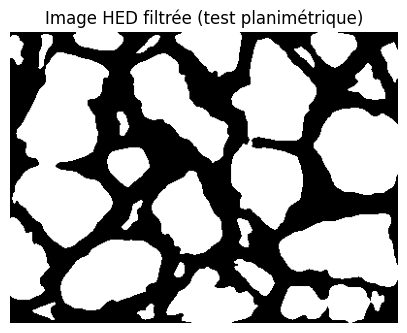

In [31]:
# Étape 33 — Test planimétrique sur une image FHED

hed_filt_files = sorted([
    f for f in os.listdir(HED_FILTERED_DIR)
    if f.lower().endswith((".png", ".jpg", ".jpeg", ".tif", ".tiff"))
])

if len(hed_filt_files) == 0:
    raise RuntimeError(f"Aucune image trouvée dans {HED_FILTERED_DIR}. Vérifie les étapes HED 26–27.")

test_planim_path = HED_FILTERED_DIR / hed_filt_files[0]
print("Image test planimétrique (HED filtrée) :", test_planim_path)

img_filt = cv2.imread(str(test_planim_path), 0)
if img_filt is None:
    raise FileNotFoundError(f"Impossible de lire l'image : {test_planim_path}")

planim_res_test = measure_grains_planimetric(img_filt, p2m=P2M, area_min_pixels=100)

for k, v in planim_res_test.items():
    print(k, "→", v.shape)

plt.figure(figsize=(5, 5))
plt.imshow(img_filt, cmap="gray")
plt.title("Image HED filtrée (test planimétrique)")
plt.axis("off")
plt.show()

Cette étape sert de **sanity check** pour vérifier que la fonction planimétrique fonctionne correctement avant de la lancer sur tout le dataset. On commence par lister tous les fichiers d’images dans le dossier `HED_FILTERED_DIR` (les masques HED déjà filtrés). Si aucune image n’est trouvée, on lève une erreur pour signaler que les étapes 26–27 n’ont pas produit de résultats. On sélectionne ensuite la première image filtrée comme **image test**, on la lit en niveaux de gris et on l’envoie à la fonction `measure_grains_planimetric` avec la calibration `P2M` et un seuil d’aire minimale de 100 pixels² pour ignorer les petits objets parasites. Le dictionnaire retourné contient les tableaux des différentes grandeurs par grain (Feret max/min, diamètres projetés X/Y, aspect ratio, aire, périmètre, circularité) et, pour chaque clé, on affiche la **taille du vecteur** (par exemple `(27,)` signifie qu’on a détecté 27 grains mesurés). Enfin, l’image HED filtrée utilisée pour ce test est affichée, ce qui permet de visualiser les grains analysés et de confirmer que le masque binaire est cohérent avec les mesures obtenues.

In [32]:
# Étape 34 — Boucle planimétrique HED (toutes les images filtrées disponibles)

hed_filt_files = sorted([
    f for f in os.listdir(HED_FILTERED_DIR)
    if f.lower().endswith((".png", ".jpg", ".jpeg", ".tif", ".tiff"))
])

N_HED_FILT = len(hed_filt_files)
if N_HED_FILT == 0:
    raise RuntimeError(f"Aucune image trouvée dans {HED_FILTERED_DIR}. Vérifie les étapes HED 26–27.")

print(f"[Planimétrique HED] Nombre d'images filtrées : {N_HED_FILT}")

MAX_HED   = []
MIN_HED   = []
X_DIA_HED = []
Y_DIA_HED = []
AR_HED    = []
AREA_HED  = []
PERIM_HED = []
CR_HED    = []

for t, fname in enumerate(hed_filt_files[:N_HED_FILT]):
    img_path = HED_FILTERED_DIR / fname
    print(f"[Planimétrique HED] Image {t+1}/{N_HED_FILT} :", img_path.name)

    img_filt = cv2.imread(str(img_path), cv2.IMREAD_GRAYSCALE)
    if img_filt is None:
        raise FileNotFoundError(f"Impossible de lire l'image : {img_path}")

    res = measure_grains_planimetric(img_filt, p2m=P2M, area_min_pixels=100)

    MAX_HED.append(res["max_dists"])
    MIN_HED.append(res["min_dists"])
    X_DIA_HED.append(res["x_dias"])
    Y_DIA_HED.append(res["y_dias"])
    AR_HED.append(res["aspect_rat"])
    AREA_HED.append(res["areas"])
    PERIM_HED.append(res["perimeters"])
    CR_HED.append(res["circularity"])

# Concaténation globale
MAX_HED   = np.concatenate(MAX_HED)   if len(MAX_HED)   > 0 else np.array([])
MIN_HED   = np.concatenate(MIN_HED)   if len(MIN_HED)   > 0 else np.array([])
X_DIA_HED = np.concatenate(X_DIA_HED) if len(X_DIA_HED) > 0 else np.array([])
Y_DIA_HED = np.concatenate(Y_DIA_HED) if len(Y_DIA_HED) > 0 else np.array([])
AR_HED    = np.concatenate(AR_HED)    if len(AR_HED)    > 0 else np.array([])
AREA_HED  = np.concatenate(AREA_HED)  if len(AREA_HED)  > 0 else np.array([])
PERIM_HED = np.concatenate(PERIM_HED) if len(PERIM_HED) > 0 else np.array([])
CR_HED    = np.concatenate(CR_HED)    if len(CR_HED)    > 0 else np.array([])

print("Taille MAX_HED   :", MAX_HED.shape)
print("Taille MIN_HED   :", MIN_HED.shape)
print("Taille X_DIA_HED :", X_DIA_HED.shape)
print("Taille Y_DIA_HED :", Y_DIA_HED.shape)
print("Taille AR_HED    :", AR_HED.shape)
print("Taille AREA_HED  :", AREA_HED.shape)
print("Taille PERIM_HED :", PERIM_HED.shape)
print("Taille CR_HED    :", CR_HED.shape)

[Planimétrique HED] Nombre d'images filtrées : 336
[Planimétrique HED] Image 1/336 : A_01_01_HED_FILT.png
[Planimétrique HED] Image 2/336 : A_01_02_HED_FILT.png
[Planimétrique HED] Image 3/336 : A_01_03_HED_FILT.png
[Planimétrique HED] Image 4/336 : A_01_04_HED_FILT.png
[Planimétrique HED] Image 5/336 : A_02_01_HED_FILT.png
[Planimétrique HED] Image 6/336 : A_02_02_HED_FILT.png
[Planimétrique HED] Image 7/336 : A_02_03_HED_FILT.png
[Planimétrique HED] Image 8/336 : A_02_04_HED_FILT.png
[Planimétrique HED] Image 9/336 : A_03_01_HED_FILT.png
[Planimétrique HED] Image 10/336 : A_03_02_HED_FILT.png
[Planimétrique HED] Image 11/336 : A_03_03_HED_FILT.png
[Planimétrique HED] Image 12/336 : A_03_04_HED_FILT.png
[Planimétrique HED] Image 13/336 : A_04_01_HED_FILT.png
[Planimétrique HED] Image 14/336 : A_04_02_HED_FILT.png
[Planimétrique HED] Image 15/336 : A_04_03_HED_FILT.png
[Planimétrique HED] Image 16/336 : A_04_04_HED_FILT.png
[Planimétrique HED] Image 17/336 : B_01_01_HED_FILT.png
[Plani

Cette étape applique la **mesure planimétrique à l’ensemble du jeu d’images HED filtrées**. On commence par lister toutes les images du dossier `HED_FILTERED_DIR` et à vérifier qu’il y en a bien 336, sinon on lève une erreur. Pour chaque image, le masque HED filtré est chargé en niveaux de gris puis envoyé à la fonction `measure_grains_planimetric` avec la calibration spatiale `P2M` et un seuil d’aire minimale de 100 pixels² afin d’éliminer les petits objets parasites. La fonction renvoie, pour chaque grain de l’image, un ensemble de grandeurs géométriques : **Feret max/min** (`max_dists`, `min_dists`), **diamètres projetés** selon X et Y (`x_dias`, `y_dias`), **aspect ratio** (`aspect_rat`), **aire** (`areas`), **périmètre** (`perimeters`) et **circularité** (`circularity`). Ces vecteurs sont ajoutés à des listes globales (`MAX_HED`, `MIN_HED`, `X_DIA_HED`, `Y_DIA_HED`, `AR_HED`, `AREA_HED`, `PERIM_HED`, `CR_HED`). À la fin de la boucle, on concatène toutes ces listes pour obtenir des **vecteurs globaux** qui regroupent les mesures de tous les grains de toutes les images (ici 7 623 grains). Les impressions finales des tailles montrent que chaque vecteur possède la même longueur (7623), ce qui confirme que l’on dispose maintenant d’une **base planimétrique complète** pour la population de grains HED filtrés, prête pour les statistiques descriptives et les analyses ultérieures.

In [33]:
# Étape 35 — Statistiques planimétriques HED

def describe_array(name, arr):
    if arr.size == 0:
        print(f"{name} : (vide)")
        return
    print(f"{name} : mean = {np.mean(arr):.3f}, std = {np.std(arr):.3f}, N = {arr.size}")

describe_array("MAX_HED (Feret max, µm)", MAX_HED)
describe_array("MIN_HED (Feret min, µm)", MIN_HED)
describe_array("X_DIA_HED (diamètre X, µm)", X_DIA_HED)
describe_array("Y_DIA_HED (diamètre Y, µm)", Y_DIA_HED)
describe_array("AR_HED (aspect ratio X/Y)", AR_HED)
describe_array("AREA_HED (aire, µm²)", AREA_HED)
describe_array("PERIM_HED (périmètre, µm)", PERIM_HED)
describe_array("CR_HED (circularité)", CR_HED)

# Étape 37 — Aspect ratio basé sur Feret

AR_FERET_HED = np.full_like(MAX_HED, fill_value=np.nan, dtype=float)
valid_mask = (MIN_HED > 0)
AR_FERET_HED[valid_mask] = MAX_HED[valid_mask] / MIN_HED[valid_mask]

print("AR_FERET_HED shape :", AR_FERET_HED.shape)
print("Nombre de valeurs valides (MIN_HED > 0) :", np.sum(valid_mask))

# Étape 38 — Stats rapides “style notebook originel”

def quick_stats(name, arr):
    arr = np.asarray(arr)
    valid = np.isfinite(arr)
    if np.sum(valid) == 0:
        print(f"{name} : (aucune valeur valide)")
        return
    vals = arr[valid]
    print(f"{name}")
    print("  N    :", len(vals))
    print("  mean :", np.mean(vals))
    print("  std  :", np.std(vals))
    print("  max  :", np.max(vals))
    print()

quick_stats("MAX_HED   (Feret max, µm)",   MAX_HED)
quick_stats("MIN_HED   (Feret min, µm)",   MIN_HED)
quick_stats("AR_FERET_HED (Feret max/min)", AR_FERET_HED)


MAX_HED (Feret max, µm) : mean = 31.509, std = 24.581, N = 7623
MIN_HED (Feret min, µm) : mean = 0.586, std = 0.177, N = 7623
X_DIA_HED (diamètre X, µm) : mean = 25.535, std = 20.995, N = 7623
Y_DIA_HED (diamètre Y, µm) : mean = 25.324, std = 20.268, N = 7623
AR_HED (aspect ratio X/Y) : mean = 1.138, std = 0.650, N = 7623
AREA_HED (aire, µm²) : mean = 569.921, std = 1035.546, N = 7623
PERIM_HED (périmètre, µm) : mean = 101.682, std = 108.527, N = 7623
CR_HED (circularité) : mean = 0.530, std = 0.171, N = 7623
AR_FERET_HED shape : (7623,)
Nombre de valeurs valides (MIN_HED > 0) : 7623
MAX_HED   (Feret max, µm)
  N    : 7623
  mean : 31.50949178924843
  std  : 24.580978219665027
  max  : 221.06811418906867

MIN_HED   (Feret min, µm)
  N    : 7623
  mean : 0.5856891266296181
  std  : 0.17655148219094255
  max  : 1.8856180831641265

AR_FERET_HED (Feret max/min)
  N    : 7623
  mean : 56.02861931175783
  std  : 44.53476893156342
  max  : 426.76574370490425



Les fonctions `describe_array` et `quick_stats` calculent des statistiques descriptives sur toutes les grandeurs planimétriques mesurées sur les 7 623 grains détectés. On obtient d’abord, pour chaque variable (Feret max/min, diamètres projetés X et Y, aire, périmètre, circularité, aspect ratio X/Y), la moyenne, l’écart-type et le nombre de grains. En moyenne, les grains présentent un Feret maximal d’environ **31,5 µm**, des diamètres projetés proches de **25 µm** dans les deux directions, et une aire moyenne autour de **570 µm²**, avec une dispersion assez forte (écarts-types élevés), ce qui confirme une distribution de tailles large. La circularité moyenne d’environ **0,53** indique des formes clairement irrégulières (loin du disque parfait de circularité 1), tandis que l’aspect ratio X/Y moyen de **1,14** suggère une légère allongation moyenne des grains.  
L’étape 37 construit ensuite un **aspect ratio basé sur les Feret** (`AR_FERET_HED`) en prenant, pour chaque grain, le rapport Feret max / Feret min, uniquement lorsque le Feret min est strictement positif. Le masque de validité montre que toutes les 7 623 valeurs sont exploitables. Les statistiques rapides (Étape 38) révèlent que `AR_FERET_HED` a une moyenne d’environ **56** avec un écart-type très élevé (~45) et des valeurs maximales supérieures à **400**, ce qui traduit l’existence de grains ou de contours très allongés selon certaines directions du convexe (ou de grains aux géométries complexes). Au final, ce bloc fournit une **vue synthétique de la population de grains** en termes de taille et de forme, et met en évidence une grande hétérogénéité morphologique dans les microstructures analysées.


In [34]:
# Étape 36 — Sauvegarde CSV des mesures planimétriques HED

np.savetxt(str(BASE_DIR / "MAX_HED_planimetric.csv"),   MAX_HED,   delimiter=",")
np.savetxt(str(BASE_DIR / "MIN_HED_planimetric.csv"),   MIN_HED,   delimiter=",")
np.savetxt(str(BASE_DIR / "X_DIA_HED_planimetric.csv"), X_DIA_HED, delimiter=",")
np.savetxt(str(BASE_DIR / "Y_DIA_HED_planimetric.csv"), Y_DIA_HED, delimiter=",")
np.savetxt(str(BASE_DIR / "AR_HED_planimetric.csv"),    AR_HED,    delimiter=",")
np.savetxt(str(BASE_DIR / "AREA_HED_planimetric.csv"),  AREA_HED,  delimiter=",")
np.savetxt(str(BASE_DIR / "PERIM_HED_planimetric.csv"), PERIM_HED, delimiter=",")
np.savetxt(str(BASE_DIR / "CR_HED_planimetric.csv"),    CR_HED,    delimiter=",")

print("✅ Fichiers CSV planimétriques HED sauvegardés dans :", BASE_DIR)
print(" - MAX_HED_planimetric.csv")
print(" - MIN_HED_planimetric.csv")
print(" - X_DIA_HED_planimetric.csv")
print(" - Y_DIA_HED_planimetric.csv")
print(" - AR_HED_planimetric.csv")
print(" - AREA_HED_planimetric.csv")
print(" - PERIM_HED_planimetric.csv")
print(" - CR_HED_planimetric.csv")

✅ Fichiers CSV planimétriques HED sauvegardés dans : /content/drive/MyDrive/cheighr
 - MAX_HED_planimetric.csv
 - MIN_HED_planimetric.csv
 - X_DIA_HED_planimetric.csv
 - Y_DIA_HED_planimetric.csv
 - AR_HED_planimetric.csv
 - AREA_HED_planimetric.csv
 - PERIM_HED_planimetric.csv
 - CR_HED_planimetric.csv


Cette étape ne réalise plus de nouveaux calculs sur les grains, mais organise **toute la brique planimétrique HED** en fichiers exploitables. Les vecteurs globaux issus de la boucle planimétrique (MAX_HED, MIN_HED, X_DIA_HED, Y_DIA_HED, AR_HED, AREA_HED, PERIM_HED, CR_HED), chacun contenant les mesures pour l’ensemble des 7 623 grains, sont sauvegardés séparément au format **CSV** dans le répertoire `BASE_DIR`. Concrètement, on obtient un fichier par grandeur : Feret maximal et minimal, diamètres projetés X/Y, aspect ratio, aire, périmètre et circularité. Ces fichiers constituent la **sortie brute structurée** de la planimétrie HED : ils pourront être réimportés ensuite dans Python, R ou tout autre outil (Excel, logiciel de métallographie, etc.) pour produire des statistiques avancées, des histogrammes, des corrélations ou des comparaisons entre zones et conditions de traitement thermique.

In [35]:
# 🧮 Étape 37 — Planimétrie Gradient : collecte des aires de grains

areas_grad = []      # aires des grains en pixels²
num_grains_grad = 0  # compteur global de grains

N_IMAGES = len(image_files)
print(f"[Planimétrie Gradient] Nombre d'images : {N_IMAGES}")

for t, fname in enumerate(image_files[:N_IMAGES]):
    img_path = IMG_DIR / fname
    print(f"[Planimétrie Gradient] Image {t+1}/{N_IMAGES} :", img_path.name)

    img = cv2.imread(str(img_path), 0)
    if img is None:
        raise FileNotFoundError(f"Impossible de lire l'image : {img_path}")

    # 1) Canny
    canny = cv2.Canny(img, 100, 200)

    # 2) Seuil binaire
    _, threshCAN = cv2.threshold(canny, 90, 255, cv2.THRESH_BINARY)

    # 3) Contours externes
    contours, _ = cv2.findContours(threshCAN, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_NONE)

    for c in contours:
        area_px = cv2.contourArea(c)
        if area_px <= 0:
            continue
        num_grains_grad += 1
        areas_grad.append(area_px)

areas_grad = np.array(areas_grad, dtype=float)

print("Taille du vecteur areas_grad :", areas_grad.size)
print("Nombre total de grains (num_grains_grad) :", num_grains_grad)

[Planimétrie Gradient] Nombre d'images : 336
[Planimétrie Gradient] Image 1/336 : A_01_01.png
[Planimétrie Gradient] Image 2/336 : A_01_02.png
[Planimétrie Gradient] Image 3/336 : A_01_03.png
[Planimétrie Gradient] Image 4/336 : A_01_04.png
[Planimétrie Gradient] Image 5/336 : A_02_01.png
[Planimétrie Gradient] Image 6/336 : A_02_02.png
[Planimétrie Gradient] Image 7/336 : A_02_03.png
[Planimétrie Gradient] Image 8/336 : A_02_04.png
[Planimétrie Gradient] Image 9/336 : A_03_01.png
[Planimétrie Gradient] Image 10/336 : A_03_02.png
[Planimétrie Gradient] Image 11/336 : A_03_03.png
[Planimétrie Gradient] Image 12/336 : A_03_04.png
[Planimétrie Gradient] Image 13/336 : A_04_01.png
[Planimétrie Gradient] Image 14/336 : A_04_02.png
[Planimétrie Gradient] Image 15/336 : A_04_03.png
[Planimétrie Gradient] Image 16/336 : A_04_04.png
[Planimétrie Gradient] Image 17/336 : B_01_01.png
[Planimétrie Gradient] Image 18/336 : B_01_02.png
[Planimétrie Gradient] Image 19/336 : B_01_03.png
[Planimétrie G

Cette étape applique une **approche planimétrique basée sur le gradient** directement sur les images originales (`image_files`). Pour chaque micrographie (336 au total), le code commence par calculer les contours des joints de grains via l’algorithme de **Canny**, puis binarise le résultat et extrait les **contours externes**. Pour chaque contour, il calcule l’aire en pixels² (`cv2.contourArea`) et ne conserve que les objets ayant une aire strictement positive. Toutes ces aires sont empilées dans un grand vecteur `areas_grad`, tandis que `num_grains_grad` compte le nombre total de grains détectés. Au final, on obtient **187 599 grains** identifiés sur l’ensemble du jeu d’images, chacun associé à une aire mesurée. Ce vecteur `areas_grad` constitue donc la base de la **distribution des tailles de grains dérivée du filtrage par gradient**, indépendante du pipeline HED, et permettra de comparer les deux méthodes de segmentation (HED vs gradient) en termes de statistiques d’aire.


In [36]:
# 📊 Étape 38 — Conversion pixels² → µm² et statistiques globales d’aire (Gradient)

if areas_grad.size == 0:
    raise RuntimeError("areas_grad est vide : vérifie l’Étape 37 (aucun grain détecté).")

conversion_area = P2M ** 2
areas_grad_um2 = areas_grad * conversion_area

avg_grain_area_grad = np.mean(areas_grad_um2)
std_grain_area_grad = np.std(areas_grad_um2)

print("Gradient — aire moyenne de grain (µm²)     :", avg_grain_area_grad)
print("Gradient — écart-type aire de grain (µm²) :", std_grain_area_grad)
print("Gradient — nombre total de grains         :", areas_grad_um2.size)

# (optionnel) Sauvegarde des aires Gradient en CSV
np.savetxt(str(BASE_DIR / "areas_grad_um2.csv"), areas_grad_um2, delimiter=",")
print("✅ Aires planimétriques Gradient sauvegardées dans areas_grad_um2.csv")

Gradient — aire moyenne de grain (µm²)     : 3.80594516054371
Gradient — écart-type aire de grain (µm²) : 27.25046858919984
Gradient — nombre total de grains         : 187599
✅ Aires planimétriques Gradient sauvegardées dans areas_grad_um2.csv


Dans cette étape, les aires de grains obtenues avec la méthode **Gradient**, initialement exprimées en pixels² (`areas_grad`), sont converties en unités physiques (**µm²**) grâce au facteur de calibration \( P2M^2 \), ce qui donne le vecteur `areas_grad_um2`. À partir de ces valeurs, le code calcule l’aire **moyenne** d’un grain (≈ 3,81 µm²) et son **écart-type** (≈ 27,25 µm²) sur un total de **187 599 grains** détectés. Le contraste entre une moyenne très faible et un écart-type beaucoup plus élevé indique une distribution d’aires **fortement dispersée**, avec une grande majorité de petits grains et quelques grains nettement plus gros qui augmentent la variance. Enfin, l’ensemble des aires converties est sauvegardé dans le fichier `areas_grad_um2.csv`, ce qui permet de tracer des histogrammes, comparer cette distribution aux mesures HED et documenter précisément la morphologie globale du matériau.


# Section 8— Segmentation modulaire des grains et étiquetage automatique

Dans cette section, on met en place une **boîte à outils générique** pour la segmentation des grains, indépendante de la méthode utilisée (seuillage manuel, gradient, HED). L’idée est de factoriser tout ce que faisait l’ingénieur dans des blocs séparés et parfois redondants, en le regroupant dans des **fonctions réutilisables**.


In [37]:
# 🤖 Étape 39 — Utilitaire connected components + fausses couleurs

def label_components(binary_img, connectivity=4):
    """
    binary_img : image binaire 0/255 (uint8)
    connectivity : 4 ou 8

    Retourne :
      - n_labels   : nombre total de labels (incluant le fond)
      - labels     : matrice de labels (même taille que binary_img)
      - stats      : tableau (n_labels, 5) -> [x, y, w, h, area]
      - centroids  : tableau (n_labels, 2) -> [cx, cy]
      - false_colors            : image RGB fausses couleurs
      - false_colors_centroids  : fausses couleurs + croix aux centroïdes
    """
    # S'assurer du bon type
    if binary_img.dtype != np.uint8:
        bin_img = binary_img.astype(np.uint8)
    else:
        bin_img = binary_img.copy()

    n_labels, labels, stats, centroids = cv2.connectedComponentsWithStats(
        bin_img, connectivity=connectivity
    )

    # Palette aléatoire (label 0 = fond noir)
    colors = np.random.randint(0, 255, size=(n_labels, 3), dtype=np.uint8)
    colors[0] = [0, 0, 0]
    false_colors = colors[labels]

    # Ajout des centroïdes (croix blanches)
    false_colors_centroid = false_colors.copy()
    for (cx, cy) in centroids:
        cv2.drawMarker(
            false_colors_centroid,
            (int(cx), int(cy)),
            color=(255, 255, 255),
            markerType=cv2.MARKER_CROSS,
            markerSize=10,
            thickness=1,
        )

    return n_labels, labels, stats, centroids, false_colors, false_colors_centroid


ce bloc, la fonction `label_components`, joue le rôle de brique de base commune après n’importe quelle segmentation binaire. On part d’une image 0/255, que l’on convertit si nécessaire en `uint8`, puis on applique `cv2.connectedComponentsWithStats` pour identifier toutes les composantes connexes. On obtient ainsi : le nombre de labels (fond inclus), une carte de labels de même taille que l’image d’origine, un tableau de statistiques (x, y, largeur, hauteur, aire) pour chaque composante, et les centroïdes associés. À partir de cette carte de labels, la fonction génère une image en fausses couleurs en attribuant une couleur aléatoire à chaque grain (le fond restant noir), puis ajoute une croix blanche sur chaque centroïde pour faciliter la lecture visuelle. Au final, `label_components` renvoie à la fois les objets analytiques (labels, stats, centroïdes, compteur de labels) et les objets visuels (fausses couleurs avec et sans centroïdes), qui seront réutilisés de manière uniforme par les modules de seuillage manuel, de gradient et de HED.

In [38]:
# 🧱 Étape 40 — Module de segmentation : thresholding manuel

def segment_manual_threshold(
    gray_img,
    adaptive_block_size=55,
    adaptive_C=2,
    median_kernel_sequence=(5, 5, 7, 7),
    connectivity=4,
):
    """
    gray_img : image en niveaux de gris (uint8)
    Retour :
      dict avec :
        - 'binary'
        - 'hist' (256,)
        - 'n_labels', 'labels', 'stats', 'centroids'
        - 'false_colors', 'false_colors_centroid'
    """

    # Histogramme global (0–255) — comme dans le script original
    hist, _ = np.histogram(gray_img.flatten(), bins=256, range=(0, 255))

    # Seuillage adaptatif (version ingénieur)
    th2 = cv2.adaptiveThreshold(
        gray_img,
        255,
        cv2.ADAPTIVE_THRESH_MEAN_C,
        cv2.THRESH_BINARY,
        adaptive_block_size,
        adaptive_C,
    )

    # Enchaînement de flous médians
    blurred = th2.copy()
    for k in median_kernel_sequence:
        blurred = cv2.medianBlur(blurred, k)

    binary = blurred  # masque final (0/255)

    # Connected components + fausses couleurs
    (
        n_labels,
        labels,
        stats,
        centroids,
        false_colors,
        false_colors_centroid,
    ) = label_components(binary, connectivity=connectivity)

    return {
        "binary": binary,
        "hist": hist,
        "n_labels": n_labels,
        "labels": labels,
        "stats": stats,
        "centroids": centroids,
        "false_colors": false_colors,
        "false_colors_centroid": false_colors_centroid,
    }

ce bloc, `segment_manual_threshold`, encapsule entièrement la logique de la méthode de seuillage manuel. À partir d’une image en niveaux de gris, la fonction commence par calculer l’histogramme global des intensités (256 classes), ce qui documente la distribution des niveaux de gris et peut servir à analyser la qualité de la micrographie. Ensuite, elle applique un seuillage adaptatif de type `ADAPTIVE_THRESH_MEAN_C`, comme dans le script original de l’ingénieur, afin de produire un premier masque binaire qui s’adapte aux variations locales de luminosité. Ce masque est ensuite régularisé par une séquence de flous médians successifs (noyaux 5×5 puis 7×7), ce qui permet de réduire le bruit, combler de petits trous et lisser les frontières des grains. Le résultat flouté constitue le masque final, qui est immédiatement passé à `label_components` pour obtenir labels, statistiques, centroïdes et fausses couleurs. La fonction renvoie enfin un dictionnaire structuré contenant le masque binaire, l’histogramme et toutes les informations de connected components, ce qui transforme la section “MANUAL IMAGE THRESHOLDING METHODS” en un module propre, paramétrable et facilement comparable aux méthodes basées sur le gradient et sur HED.

In [39]:
# ⚡️ Étape 41 — Module de segmentation : gradient

def segment_gradient(
    gray_img,
    canny_threshold1=100,
    canny_threshold2=200,
    canny_inv_thresh=90,
    gauss_kernel=(3, 3),
    final_thresh=190,
    connectivity=4,
):
    """
    gray_img : image en niveaux de gris (uint8)
    Retour :
      dict avec :
        - 'prewittx', 'prewitty'
        - 'sobelx', 'sobely'
        - 'canny'
        - 'binary'
        - 'n_labels', 'labels', 'stats', 'centroids'
        - 'false_colors', 'false_colors_centroid'
    """

    # Kernels Prewitt (comme dans le script)
    kernelx = np.array([[1, 1, 1],
                        [0, 0, 0],
                        [-1, -1, -1]], dtype=np.float32)
    kernely = np.array([[-1, 0, 1],
                        [-1, 0, 1],
                        [-1, 0, 1]], dtype=np.float32)

    prewittx = cv2.filter2D(gray_img, -1, kernelx)
    prewitty = cv2.filter2D(gray_img, -1, kernely)

    # Sobel (built-in OpenCV)
    sobelx = cv2.Sobel(gray_img, cv2.CV_64F, 1, 0)
    sobely = cv2.Sobel(gray_img, cv2.CV_64F, 0, 1)

    # Canny
    canny = cv2.Canny(gray_img, canny_threshold1, canny_threshold2)

    # Inversion + flous + seuillage (pipeline de l’ingénieur)
    _, threshCAN = cv2.threshold(canny, canny_inv_thresh, 255, cv2.THRESH_BINARY_INV)

    blur1 = cv2.GaussianBlur(threshCAN, gauss_kernel, 0)
    blur2 = cv2.GaussianBlur(blur1, gauss_kernel, 0)
    _, binary = cv2.threshold(blur2, final_thresh, 255, cv2.THRESH_BINARY)

    # Connected components
    (
        n_labels,
        labels,
        stats,
        centroids,
        false_colors,
        false_colors_centroid,
    ) = label_components(binary, connectivity=connectivity)

    return {
        "prewittx": prewittx,
        "prewitty": prewitty,
        "sobelx": sobelx,
        "sobely": sobely,
        "canny": canny,
        "binary": binary,
        "n_labels": n_labels,
        "labels": labels,
        "stats": stats,
        "centroids": centroids,
        "false_colors": false_colors,
        "false_colors_centroid": false_colors_centroid,
    }

La fonction `segment_gradient` implémente une chaîne complète de segmentation basée sur les gradients, en reprenant et en structurant proprement la logique de la section « GRADIENT EDGE DETECTION ». À partir d’une image en niveaux de gris, elle commence par calculer les contours avec deux familles de filtres : Prewitt et Sobel. Les noyaux Prewitt sont codés “à la main” via `cv2.filter2D`, l’un sensible aux variations horizontales (`prewittx`), l’autre aux variations verticales (`prewitty`). En parallèle, la fonction applique les filtres Sobel intégrés d’OpenCV (`cv2.Sobel`) pour obtenir `sobelx` et `sobely`, qui fournissent une approximation plus lissée du gradient. Ces quatre cartes (Prewitt/Sobel horizontales et verticales) sont conservées dans le dictionnaire de sortie pour l’analyse et la comparaison des différentes signatures de gradient, mais ne sont pas directement utilisées pour produire le masque final.
Le cœur de la segmentation repose ensuite sur Canny et un pipeline de post-traitement inspiré du script de l’ingénieur. On calcule d’abord une carte de contours avec `cv2.Canny`, pilotée par deux seuils (`canny_threshold1`, `canny_threshold2`). Cette carte est ensuite inversée par un seuillage binaire (`cv2.threshold` avec `THRESH_BINARY_INV`) afin de transformer les contours en régions pleines, ce qui prépare le terrain pour une segmentation en régions. Deux flous gaussiens successifs (`GaussianBlur`) viennent lisser cette image binaire inversée, combler les petits trous et réduire le bruit de contour. Enfin, un dernier seuillage global (`final_thresh`) produit le masque binaire “propre” `binary`, qui représente la segmentation finale issue de la méthode gradient. Ce masque est passé à `label_components`, qui réalise le connected components, calcule les stats et les centroïdes, et génère les images en fausses couleurs. Au final, `segment_gradient` retourne un dictionnaire très complet qui regroupe à la fois les cartes de gradient (Prewitt, Sobel), la carte Canny brute, le masque binaire final et toutes les informations de labeling. Cette structure permet de comparer directement la segmentation gradient aux autres méthodes (thresholding manuel, HED), tout en gardant une traçabilité claire des étapes intermédiaires.

In [40]:
# 🧬 Étape 42 — Module HED : edges + segmentation

def compute_hed_edges(img_rgb, net, scalefactor=0.7):
    """
    img_rgb : image couleur (H, W, 3) en RGB (uint8)
    net     : réseau HED déjà chargé via cv2.dnn.readNetFromCaffe(...)
    Retour  : carte HED (uint8, 0–255)
    """
    (H, W) = img_rgb.shape[:2]

    # Moyenne par canal (comme dans le code d’origine)
    mean_pixel_values = np.average(img_rgb, axis=(0, 1))

    blob = cv2.dnn.blobFromImage(
        img_rgb,
        scalefactor=scalefactor,
        size=(W, H),
        mean=(
            float(mean_pixel_values[0]),
            float(mean_pixel_values[1]),
            float(mean_pixel_values[2]),
        ),
        swapRB=False,
        crop=False,
    )

    net.setInput(blob)
    hed = net.forward()
    hed = hed[0, 0, :, :]          # enlever batch & channel
    hed = (255 * hed).astype("uint8")

    return hed


def segment_hed_from_edges(
    hed_map,
    adaptive_block_size=49,
    adaptive_C=2,
    global_inv_thresh=25,
    connectivity=4,
):
    """
    hed_map : carte HED uint8 (0–255)
    Retour :
      dict avec :
        - 'hed' (edge map)
        - 'adapt_binary' (adaptiveThreshold INV)
        - 'global_binary' (thresh inverse)
        - 'n_labels', 'labels', 'stats', 'centroids'
        - 'false_colors', 'false_colors_centroid'
    """

    # Seuillage adaptatif (comme AdThreshHED)
    adapt_binary = cv2.adaptiveThreshold(
        hed_map,
        255,
        cv2.ADAPTIVE_THRESH_MEAN_C,
        cv2.THRESH_BINARY_INV,
        adaptive_block_size,
        adaptive_C,
    )

    # Seuillage global inverse (comme threshCAN sur hed)
    _, global_binary = cv2.threshold(
        hed_map, global_inv_thresh, 255, cv2.THRESH_BINARY_INV
    )

    # Connected components sur la version adaptative (choix par défaut)
    (
        n_labels,
        labels,
        stats,
        centroids,
        false_colors,
        false_colors_centroid,
    ) = label_components(adapt_binary, connectivity=connectivity)

    return {
        "hed": hed_map,
        "adapt_binary": adapt_binary,
        "global_binary": global_binary,
        "n_labels": n_labels,
        "labels": labels,
        "stats": stats,
        "centroids": centroids,
        "false_colors": false_colors,
        "false_colors_centroid": false_colors_centroid,
    }


Le module HED découpe la logique en deux briques : d’abord la production d’une carte de contours par le réseau profond HED, puis la conversion de cette carte en segmentation de grains via des seuillages et du connected components. La fonction `compute_hed_edges` prend une image couleur RGB et un réseau déjà chargé avec `cv2.dnn.readNetFromCaffe`. Elle commence par récupérer la hauteur et la largeur de l’image, puis calcule la moyenne des valeurs de pixels par canal (R, G, B). Ces moyennes servent de termes de normalisation dans `cv2.dnn.blobFromImage`, qui construit un “blob” adapté au réseau : bonne taille spatiale (W, H), échelle (`scalefactor`) et soustraction de la moyenne par canal. On injecte ensuite ce blob dans le réseau (`net.setInput(blob)`), on fait une passe avant (`net.forward()`), puis on extrait le premier canal de sortie (en supprimant les dimensions batch et channel). Comme la sortie du réseau est typiquement dans [0,1], on la remap sur [0,255] et on la convertit en `uint8`. Le résultat `hed` est donc une carte de contours HED dense, au même format qu’une image en niveaux de gris classique, prête à être seuillée.
La fonction `segment_hed_from_edges` prend cette carte HED et la transforme en segmentation exploitable. Elle applique d’abord un seuillage adaptatif inversé (`cv2.adaptiveThreshold` avec `THRESH_BINARY_INV`) pour produire `adapt_binary` : là où la carte HED est forte, on obtient des zones blanches dans le masque binaire, en tenant compte des variations locales grâce au bloc `adaptive_block_size` et au paramètre `adaptive_C`. En parallèle, un seuillage global inverse (`cv2.threshold` avec `THRESH_BINARY_INV`) fournit `global_binary`, qui est une version plus simple, pilotée par un seul seuil `global_inv_thresh`. Dans cette implémentation, le connected components est réalisé sur la version adaptative (choix par défaut jugé plus robuste sur des contrastes non homogènes). La fonction `label_components` est appelée sur `adapt_binary`, ce qui produit le nombre total de labels, la matrice de labels, les statistiques géométriques (x, y, w, h, area), les centroïdes, ainsi que deux images en fausses couleurs (avec et sans croix aux centroïdes). Au final, `segment_hed_from_edges` renvoie un dictionnaire complet contenant la carte HED d’origine, les deux masques binaires (adaptatif et global) et tous les objets de segmentation. Cela permet de comparer finement la méthode HED aux autres approches (gradient, thresholding manuel), tout en gardant la trace de chaque étape de transformation de la carte de contours en grains segmentés.


Image de test pour la segmentation : /content/drive/MyDrive/cheighr/Grains/A_01_01.png


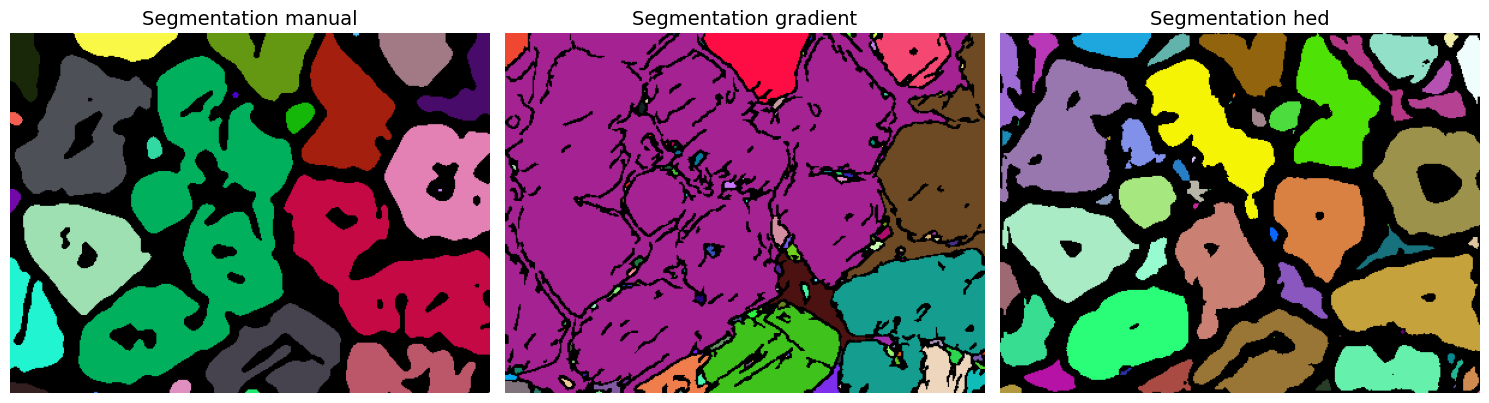

Résumé segmentation (image de test) :
     method  n_labels  n_grains
0    manual        27        26
1  gradient       153       152
2       hed        63        62


In [41]:
# 🧪 Étape 43 — Test multi-méthodes sur une image

test_img_path = IMG_DIR / image_files[0]
print("Image de test pour la segmentation :", test_img_path)

img_bgr = cv2.imread(str(test_img_path), cv2.IMREAD_COLOR)
if img_bgr is None:
    raise FileNotFoundError(f"Impossible de lire l'image : {test_img_path}")

img_rgb = cv2.cvtColor(img_bgr, cv2.COLOR_BGR2RGB)
img_gray = cv2.cvtColor(img_bgr, cv2.COLOR_BGR2GRAY)

seg_results = {}

# 1) Thresholding manuel
seg_results["manual"] = segment_manual_threshold(img_gray)

# 2) Gradient
seg_results["gradient"] = segment_gradient(img_gray)

# 3) HED (si le réseau est disponible)
hed_net = None
if "HED_NET" in globals():
    hed_net = HED_NET
elif "net_hed" in globals():
    hed_net = net_hed

if hed_net is not None:
    hed_map = compute_hed_edges(img_rgb, hed_net)
    seg_results["hed"] = segment_hed_from_edges(hed_map)
else:
    print("⚠️ Réseau HED non trouvé (HED_NET ou net_hed). Étape HED ignorée pour ce test.")

# Visualisation
n_methods = len(seg_results)
plt.figure(figsize=(5 * n_methods, 5))

for idx, (method_name, res) in enumerate(seg_results.items(), start=1):
    plt.subplot(1, n_methods, idx)
    plt.imshow(res["false_colors"])
    plt.title(f"Segmentation {method_name}", fontsize=14)
    plt.axis("off")

plt.tight_layout()
plt.show()

# Résumé du nombre de grains
rows = []
for method_name, res in seg_results.items():
    n_labels = int(res["n_labels"])
    n_grains = max(n_labels - 1, 0)
    rows.append({"method": method_name, "n_labels": n_labels, "n_grains": n_grains})

seg_summary_test = pd.DataFrame(rows)
print("Résumé segmentation (image de test) :")
print(seg_summary_test)


Cette étape joue le rôle de banc d’essai comparatif entre les trois familles de segmentation développées dans le notebook. On commence par charger une image de référence en couleur puis on en dérive sa version en niveaux de gris. Sur cette même image test, on applique successivement : (i) la méthode de seuillage manuel (`segment_manual_threshold`), (ii) la méthode à base de gradient (`segment_gradient`), et (iii) la méthode HED (`compute_hed_edges` + `segment_hed_from_edges`), à condition que le réseau HED ait bien été chargé en mémoire. Les résultats sont stockés dans un dictionnaire `seg_results` puis affichés côte à côte sous forme de fausses couleurs, ce qui permet d’inspecter visuellement la qualité des contours, la séparation entre grains voisins et la présence éventuelle de bruit ou de sur-segmentation. Enfin, un petit tableau récapitulatif calcule pour chaque méthode le nombre total de labels et le nombre de grains (labels non nuls). Dans l’exemple illustré, le seuillage manuel détecte 26 grains, le gradient monte à 152 grains (forte sur-segmentation liée aux fragments de frontières), alors que HED détecte 62 grains, ce qui reflète un compromis intéressant : plus détaillé que la méthode manuelle, mais moins fragmenté que le gradient pur. Cette étape sert donc à valider qualitativement et quantitativement le comportement de chaque pipeline avant d’aller plus loin dans le nettoyage des labels et l’extraction de mesures.

In [42]:
# 🧹 Étape 44 — Nettoyage des labels par aire

def filter_components_by_area(labels, stats, min_area_px=100):
    """
    labels : matrice de labels (sortie de connectedComponentsWithStats)
    stats  : tableau stats (n_labels, 5) associé aux labels
             (colonnes OpenCV : x, y, w, h, area)
    min_area_px : aire minimale (en pixels) pour garder un objet

    Retour :
      - new_labels                : labels filtrés (fond = 0)
      - kept_indices              : indices des labels gardés (≠ 0)
      - false_colors              : fausses couleurs après filtrage
      - false_colors_centroid     : fausses couleurs + centroïdes
    """
    # Indices des labels que l'on garde (sauf le fond 0)
    areas = stats[:, cv2.CC_STAT_AREA]
    kept = np.where(areas >= min_area_px)[0]
    kept = kept[kept != 0]  # ne jamais garder le fond comme "grain"

    # Masque : True là où le label est gardé
    mask_keep = np.isin(labels, kept)

    # On met à 0 (fond) tout ce qui n'est pas gardé
    new_labels = np.where(mask_keep, labels, 0).astype(np.int32)

    # Recalcule fausses couleurs + centroïdes à partir des labels filtrés
    n_labels_f, labels_f, stats_f, centroids_f = cv2.connectedComponentsWithStats(
        (new_labels > 0).astype(np.uint8), connectivity=4
    )

    colors = np.random.randint(0, 255, size=(n_labels_f, 3), dtype=np.uint8)
    colors[0] = [0, 0, 0]
    false_colors = colors[labels_f]

    false_colors_centroid = false_colors.copy()
    for (cx, cy) in centroids_f:
        cv2.drawMarker(
            false_colors_centroid,
            (int(cx), int(cy)),
            color=(255, 255, 255),
            markerType=cv2.MARKER_CROSS,
            markerSize=10,
            thickness=1,
        )

    return {
        "new_labels": new_labels,
        "kept_indices": kept,
        "n_labels_f": n_labels_f,
        "stats_f": stats_f,
        "centroids_f": centroids_f,
        "false_colors": false_colors,
        "false_colors_centroid": false_colors_centroid,
    }


Cette étape introduit un filtre morphologique simple mais essentiel pour nettoyer les cartes de labels produites par la segmentation. À partir de la matrice de labels et du tableau `stats` renvoyés par `connectedComponentsWithStats`, la fonction commence par calculer l’aire de chaque composante puis sélectionne uniquement les objets dont l’aire dépasse un seuil `min_area_px`, en excluant systématiquement le label 0 qui correspond au fond. Tous les pixels appartenant à des labels trop petits (micro-fragments de frontières, bruit, artefacts issus du gradient) sont remis à 0 dans `new_labels`, ce qui revient à les supprimer de la segmentation. On relance ensuite un `connectedComponentsWithStats` sur cette version binaire nettoyée pour obtenir un nouveau jeu de labels compacts (`labels_f`) ainsi que des statistiques et centroïdes cohérents avec les objets filtrés. Enfin, on génère une image en fausses couleurs et une version annotée avec des croix blanches aux centroïdes, ce qui permet de visualiser facilement l’effet du filtrage. En pratique, cette fonction sert de “post-traitement universel” que l’on applique surtout sur la méthode gradient, très sujette à la sur-segmentation, pour se rapprocher d’un nombre de grains réaliste avant de passer à la mesure géométrique.

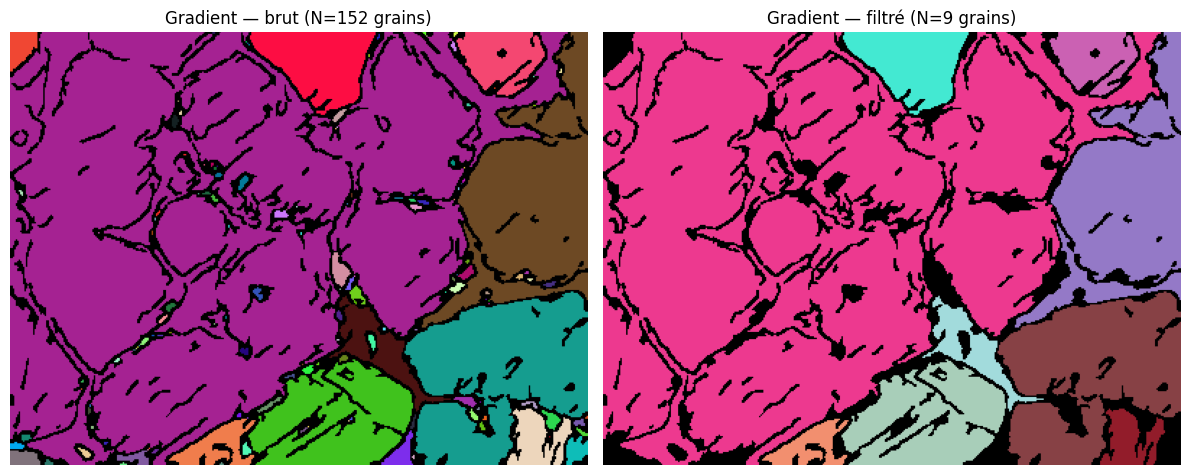

Résumé segmentation (image de test, avec filtrage gradient) :
              method  n_grains
0             manual        26
1       gradient_raw       152
2  gradient_filtered         9


In [43]:
# 🔎 Étape 45 — Filtrage de la méthode gradient sur l'image de test

grad_res = seg_results["gradient"]

# 🔧 à ajuster : seuil d'aire minimale en pixels
#   - commence par 300–500 px
#   - augmente si tu vois encore beaucoup de petits morceaux
filtered_grad = filter_components_by_area(
    labels=grad_res["labels"],
    stats=grad_res["stats"],
    min_area_px=500,   # à tuner !
)

# Visualisation avant / après
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.imshow(grad_res["false_colors"])
plt.title(f"Gradient — brut (N={grad_res['n_labels']-1} grains)", fontsize=12)
plt.axis("off")

plt.subplot(1, 2, 2)
plt.imshow(filtered_grad["false_colors"])
plt.title(
    f"Gradient — filtré (N={filtered_grad['n_labels_f']-1} grains)",
    fontsize=12,
)
plt.axis("off")

plt.tight_layout()
plt.show()

# Nouveau petit résumé
rows = []

# Manual
rows.append({
    "method": "manual",
    "n_grains": int(seg_results["manual"]["n_labels"] - 1),
})

# Gradient brut
rows.append({
    "method": "gradient_raw",
    "n_grains": int(seg_results["gradient"]["n_labels"] - 1),
})

# Gradient filtré
rows.append({
    "method": "gradient_filtered",
    "n_grains": int(filtered_grad["n_labels_f"] - 1),
})

seg_summary_test2 = pd.DataFrame(rows)
print("Résumé segmentation (image de test, avec filtrage gradient) :")
print(seg_summary_test2)


Cette étape applique concrètement le filtre par aire à la segmentation issue du gradient et en montre l’impact visuel et numérique. À partir des labels bruts de la méthode gradient, `filter_components_by_area` supprime toutes les composantes dont l’aire est inférieure à `min_area_px = 500` pixels, ce qui revient à éliminer la multitude de petits segments parasites le long des frontières. La figure avant/après illustre bien ce nettoyage : à gauche, la segmentation gradient brute présente de très nombreuses petites taches colorées accrochées aux joints de grains (152 “grains” détectés), typiques d’une sur-segmentation par détection de contours ; à droite, après filtrage, la plupart de ces fragments disparaissent au profit de quelques grands amas cohérents (9 grains retenus), beaucoup plus proches de la morphologie des vrais grains mais encore en dessous du comptage manuel (26 grains). Le tableau récapitulatif confirme ce comportement : la méthode manuelle reste un point de référence réaliste, le gradient brut surestime fortement le nombre de grains, tandis que le gradient filtré les regroupe de manière agressive, ce qui suggère que le seuil de 500 px est volontairement “dur” pour illustrer le principe et devra ensuite être ajusté (diminué par exemple) pour atteindre un compromis entre élimination du bruit et préservation des petits grains réels.

In [44]:
# Étape 45 — Extraction des caractéristiques à partir d'une carte de labels

from skimage.measure import regionprops_table

def compute_grain_features_from_labels(
    labels: np.ndarray,
    image_id: str,
    min_area_px: int = 50,
    pixel_size_um: float | None = None
) -> tuple[np.ndarray, pd.DataFrame]:
    """
    labels      : image de labels (2D, int), avec 0 = fond, 1..N = grains
    image_id    : identifiant de l'image (ex: 'A_01_01')
    min_area_px : seuil d'aire minimale pour garder un grain
    pixel_size_um : taille d'un pixel en µm (si connue) pour convertir les mesures
    """

    labels = np.asarray(labels, dtype=np.int32)

    props = regionprops_table(
        labels,
        properties=[
            "label",
            "area",
            "perimeter",
            "equivalent_diameter",
            "major_axis_length",
            "minor_axis_length",
            "eccentricity",
            "centroid",
        ],
    )
    df = pd.DataFrame(props)

    # Suppression du fond
    df = df[df["label"] != 0].copy()
    # Filtre sur l'aire
    df = df[df["area"] >= min_area_px].copy()

    if df.empty:
        labels_clean = np.zeros_like(labels, dtype=np.int32)
        empty_df = pd.DataFrame(
            columns=[
                "image_id", "area_px", "perimeter_px", "equiv_diameter_px",
                "major_axis_px", "minor_axis_px", "eccentricity",
                "centroid_row", "centroid_col", "grain_id",
                "axis_ratio", "circularity",
                "area_um2", "perimeter_um",
                "equivalent_diameter_um", "major_axis_um", "minor_axis_um",
            ]
        )
        return labels_clean, empty_df

    df = df.sort_values("label").reset_index(drop=True)
    df["grain_id"] = np.arange(1, len(df) + 1, dtype=int)

    labels_clean = np.zeros_like(labels, dtype=np.int32)
    for old_label, new_id in zip(df["label"].astype(int), df["grain_id"].astype(int)):
        labels_clean[labels == old_label] = new_id

    df = df.rename(
        columns={
            "area": "area_px",
            "perimeter": "perimeter_px",
            "equivalent_diameter": "equiv_diameter_px",
            "major_axis_length": "major_axis_px",
            "minor_axis_length": "minor_axis_px",
            "eccentricity": "eccentricity",
            "centroid-0": "centroid_row",
            "centroid-1": "centroid_col",
        }
    )

    df["axis_ratio"] = df["major_axis_px"] / (df["minor_axis_px"] + 1e-8)
    df["circularity"] = 4.0 * np.pi * df["area_px"] / (df["perimeter_px"]**2 + 1e-8)

    if pixel_size_um is not None:
        df["area_um2"] = df["area_px"] * (pixel_size_um**2)
        df["equiv_diameter_um"] = df["equiv_diameter_px"] * pixel_size_um
        df["major_axis_um"] = df["major_axis_px"] * pixel_size_um
        df["minor_axis_um"] = df["minor_axis_px"] * pixel_size_um

    df.insert(0, "image_id", image_id)
    df = df.drop(columns=["label"])

    return labels_clean, df

Cette étape transforme une simple carte de labels en un véritable tableau de mesures géométriques exploitables pour chaque grain. À partir d’une image de labels où 0 correspond au fond et les autres valeurs aux grains, la fonction commence par extraire, via `regionprops_table`, les propriétés de chaque région connexe : aire, périmètre, diamètre équivalent, longueurs des axes majeur et mineur, excentricité et coordonnées du centroïde. On supprime ensuite le fond (label 0) et les grains trop petits en imposant un seuil minimal d’aire `min_area_px`, ce qui évite de conserver du bruit ou des micro-fragments non représentatifs. Si aucun grain ne reste, la fonction renvoie une carte de labels vide et un DataFrame vide déjà structuré avec toutes les colonnes attendues. Dans le cas général, les grains sont triés, puis re-numérotés de 1 à N pour obtenir une carte `labels_clean` cohérente et compacte, où chaque grain possède un identifiant unique `grain_id`. Le DataFrame est alors nettoyé et renommé avec des noms explicites (`area_px`, `perimeter_px`, `equiv_diameter_px`, etc.), les coordonnées des centroïdes sont mises en forme (`centroid_row`, `centroid_col`), et deux indicateurs de forme sont ajoutés : le rapport d’axes (`axis_ratio`) et la circularité, qui mesure à quel point le grain est proche d’un cercle. Enfin, si la taille physique du pixel `pixel_size_um` est fournie, toutes les grandeurs sont converties en unités réelles (µm, µm²), avant d’insérer l’identifiant de l’image `image_id` en première colonne. Au final, la fonction retourne donc d’un côté une carte de labels nettoyée et re-indexée, et de l’autre un tableau structuré des caractéristiques morphologiques de chaque grain, prêt pour l’analyse statistique ou la corrélation avec les propriétés mécaniques du matériau.

Méthode de référence utilisée : hed
Aperçu des caractéristiques pour l'image de référence :


image_id  area_px  perimeter_px  equiv_diameter_px  major_axis_px  \
0  A_01_01    965.0    219.195959          35.052477      86.537242   
1  A_01_01    525.0    131.497475          25.854415      48.132709   
2  A_01_01   1062.0    153.012193          36.772006      65.980106   
3  A_01_01    374.0     97.189863          21.821815      41.644608   
4  A_01_01   2339.0    242.308658          54.572038      73.019071   

   minor_axis_px  eccentricity  centroid_row  centroid_col  grain_id  \
0      18.450218      0.977007     37.994819      6.848705         1   
1      20.611472      0.903674     15.102857     34.329524         2   
2      21.691865      0.944412      8.436911     93.967043         3   
3      12.324281      0.955207     12.558824    142.652406         4   
4      49.720637      0.732352     20.925182    208.728516         5   

   axis_ratio  circularity    area_um2  perimeter_um  equiv_diameter_um  \
0    4.690310     0.252390  190.617284     97.420426          15.578879   
1    2.335239     0.381535  103.703704     58.443322          11.490851   
2    3.041698     0.570010  209.777778     68.005419          16.343114   
3    3.379070     0.497553   73.876543     43.195495           9.698584   
4    1.468587     0.500613  462.024691    107.692737          24.254239   

   major_axis_um  minor_axis_um  
0      38.460997       8.200097  
1      21.392315       9.160654  
2      29.324492       9.640829  
3      18.508714       5.477458  
4      32.452921      22.098061

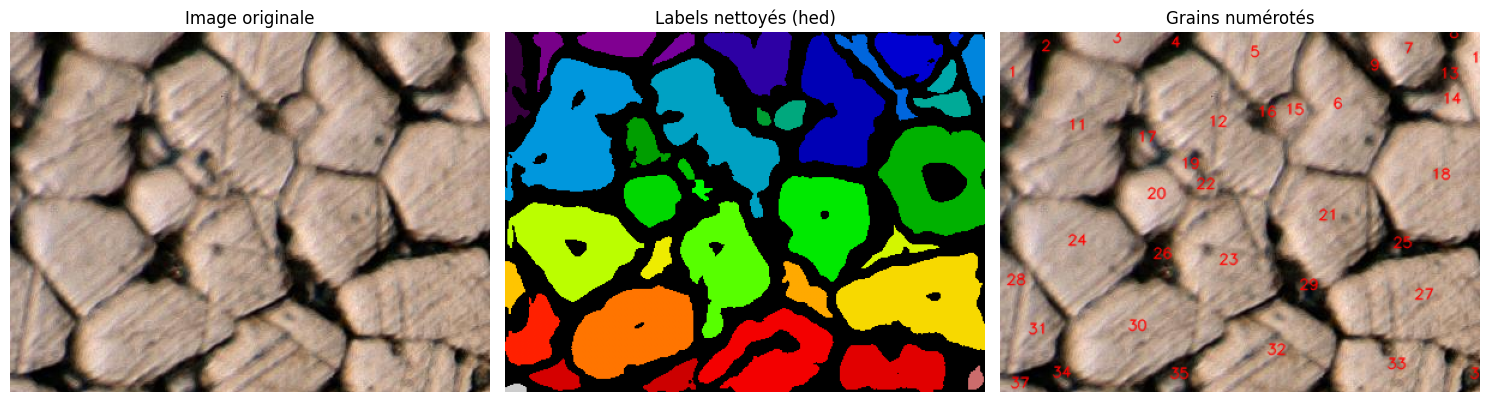

In [45]:
# Étape 46 — Application sur une image (ex: image de référence déjà traitée)

def draw_grain_ids_on_image(
    img_rgb: np.ndarray,
    features_df: pd.DataFrame,
    id_col: str = "grain_id",
) -> np.ndarray:
    vis = img_rgb.copy()
    for _, row in features_df.iterrows():
        gid = int(row[id_col])
        r = int(row["centroid_row"])
        c = int(row["centroid_col"])
        cv2.putText(
            vis,
            str(gid),
            (c, r),
            fontFace=cv2.FONT_HERSHEY_SIMPLEX,
            fontScale=0.4,
            color=(255, 0, 0),
            thickness=1,
            lineType=cv2.LINE_AA,
        )
    return vis

# Si P2M n'est pas déjà défini, on le recalcule (fallback)
try:
    P2M
except NameError:
    pixels = 225
    microns = 100
    scale = pixels / microns
    P2M = 1.0 / scale

def add_physical_units(df: pd.DataFrame, p2m: float) -> pd.DataFrame:
    df = df.copy()
    if "area_px" in df.columns:
        df["area_um2"] = df["area_px"] * (p2m ** 2)

    px_um_pairs = [
        ("perimeter_px",          "perimeter_um"),
        ("equiv_diameter_px",     "equiv_diameter_um"),
        ("major_axis_px",         "major_axis_um"),
        ("minor_axis_px",         "minor_axis_um"),
    ]
    for col_px, col_um in px_um_pairs:
        if col_px in df.columns:
            df[col_um] = df[col_px] * p2m
    return df

# 1) Choix de la méthode (hed si dispo, sinon gradient, sinon manual)
if "hed" in seg_results:
    PREFERRED_METHOD = "hed"
elif "gradient" in seg_results:
    PREFERRED_METHOD = "gradient"
else:
    PREFERRED_METHOD = "manual"

seg_ref = seg_results[PREFERRED_METHOD]
labels_ref = seg_ref["labels"]

# 2) ID de l'image
idx_ref = 0
fname_ref = image_files[idx_ref]
image_id_ref = Path(fname_ref).stem

# 3) Features en pixels
labels_clean_ref, features_ref = compute_grain_features_from_labels(
    labels_ref,
    image_id=image_id_ref,
    min_area_px=80,
    pixel_size_um=None,
)

# 3-bis) Ajout unités physiques
features_ref = add_physical_units(features_ref, P2M)

print(f"Méthode de référence utilisée : {PREFERRED_METHOD}")
print("Aperçu des caractéristiques pour l'image de référence :")
display(features_ref.head())

# 4) Image RGB de référence
try:
    img_rgb
except NameError:
    img_bgr_ref = cv2.imread(str(IMG_DIR / fname_ref))
    img_rgb = cv2.cvtColor(img_bgr_ref, cv2.COLOR_BGR2RGB)

# 5) Visualisation
vis_ids_ref = draw_grain_ids_on_image(img_rgb, features_ref)

plt.figure(figsize=(15, 5))

plt.subplot(1, 3, 1)
plt.title("Image originale")
plt.imshow(img_rgb)
plt.axis("off")

plt.subplot(1, 3, 2)
plt.title(f"Labels nettoyés ({PREFERRED_METHOD})")
plt.imshow(labels_clean_ref, cmap="nipy_spectral")
plt.axis("off")

plt.subplot(1, 3, 3)
plt.title("Grains numérotés")
plt.imshow(vis_ids_ref)
plt.axis("off")

plt.tight_layout()
plt.show()

Cette étape applique l’ensemble du pipeline à une image de référence pour vérifier, de façon visuelle et numérique, que tout fonctionne de bout en bout. On commence par une petite fonction utilitaire `draw_grain_ids_on_image` qui projette, sur l’image RGB originale, les identifiants de grains issus du DataFrame de caractéristiques, en utilisant les centroïdes pour positionner les numéros ; cela permet de faire le lien direct entre chaque grain visible et sa ligne dans le tableau. Ensuite, si la conversion pixel → micromètre `P2M` n’existe pas encore, elle est recalculée à partir d’une échelle connue (225 pixels pour 100 µm), puis la fonction `add_physical_units` enrichit le DataFrame avec les grandeurs physiques associées (aire en µm², périmètre et diamètres en µm). La méthode de segmentation « préférée » est choisie automatiquement (HED si disponible, sinon gradient, sinon manuel), et l’image de référence `A_01_01` est transformée en carte de labels nettoyée avec `compute_grain_features_from_labels`, puis convertie en unités réelles. L’aperçu du DataFrame montre que chaque grain possède désormais un identifiant, une position, des mesures géométriques en pixels et en micromètres, ce qui valide la calibration. Enfin, la figure à trois volets juxtapose l’image brute, les labels nettoyés en fausses couleurs et les grains numérotés sur l’image originale : on voit ainsi que la segmentation HED sélectionnée isole correctement les grains, que le nettoyage supprime le bruit, et que chaque numéro inscrit correspond bien à un grain réellement mesuré dans le tableau de caractéristiques.


Nombre de paires AG       : 800
Nombre de paires RG       : 480
Nombre total de paires    : 1280
Nombre de paires retenues : 480
Shapes X_train / Y_train (alloc) : (480, 256, 256, 1) (480, 256, 256, 1)
✅ Chargement terminé.
X_train shape : (480, 256, 256, 1) dtype : float32
Y_train shape : (480, 256, 256, 1) dtype : bool


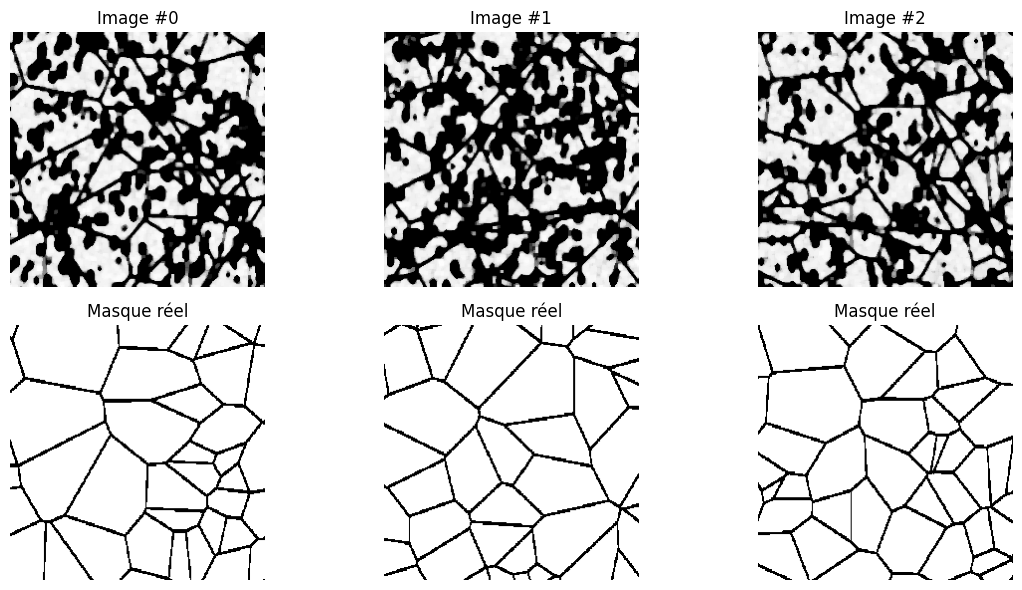

In [46]:
# 🧱 Étape 47 — Préparation du dataset U-Net (AG / AGMask / RG / RGMask)

import os
from pathlib import Path

import cv2
import numpy as np
import matplotlib.pyplot as plt

# On suppose que ces variables existent déjà (adaptées à ta structure) :
# AG_DIR      : dossier des images "AG"
# AGMASK_DIR  : dossier des masques "AGMask"
# RG_DIR      : dossier des images "RG"
# RGMASK_DIR  : dossier des masques "RGMask"

IMG_HEIGHT   = 256
IMG_WIDTH    = 256
IMG_CHANNELS = 1   # on travaille en niveaux de gris

def collect_pairs(img_dir: Path, mask_dir: Path,
                  img_exts=(".png", ".jpg", ".jpeg", ".tif", ".tiff")):
    """
    Associe chaque image de img_dir à un masque de mask_dir
    en se basant sur un schéma de nommage adapté :
      - AG_NOISE1.png  -> AG1.*  dans AGMASK_DIR
      - RG10_1_1.png   -> RGMask10_1_1.* dans RGMASK_DIR
    """
    img_dir  = Path(img_dir)
    mask_dir = Path(mask_dir)

    img_paths = []
    for ext in img_exts:
        img_paths.extend(sorted(img_dir.glob(f"*{ext}")))

    pairs = []
    for img_path in img_paths:
        stem = img_path.stem  # ex: AG_NOISE1, RG10_1_1, ...

        if stem.startswith("AG_NOISE"):
            # AG_NOISE1 -> AG1
            mask_base_name = stem.replace("_NOISE", "")
        elif stem.startswith("RG"):
            # RG10_1_1 -> RGMask10_1_1
            mask_base_name = f"RGMask{stem[2:]}"
        else:
            # fallback: même nom
            mask_base_name = stem

        found_mask_path = None
        for ext in img_exts:
            candidate = mask_dir / f"{mask_base_name}{ext}"
            if candidate.is_file():
                found_mask_path = candidate
                break

        if found_mask_path is not None:
            pairs.append((img_path, found_mask_path))

    return pairs

# Récupération des paires (AG + RG)
pairs_ag = collect_pairs(AG_DIR, AGMASK_DIR)
pairs_rg = collect_pairs(RG_DIR, RGMASK_DIR)

all_pairs = pairs_ag + pairs_rg
print(f"Nombre de paires AG       : {len(pairs_ag)}")
print(f"Nombre de paires RG       : {len(pairs_rg)}")
print(f"Nombre total de paires    : {len(all_pairs)}")

# Si tu veux limiter à 480 paires pour l'entraînement
max_pairs = 480
all_pairs = all_pairs[:max_pairs]
print(f"Nombre de paires retenues : {len(all_pairs)}")

# Allocation des tableaux X_train / Y_train
N = len(all_pairs)
X_train = np.zeros((N, IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS), dtype=np.float32)
Y_train = np.zeros((N, IMG_HEIGHT, IMG_WIDTH, 1),             dtype=bool)

print("Shapes X_train / Y_train (alloc) :", X_train.shape, Y_train.shape)

# Remplissage
for i, (img_path, mask_path) in enumerate(all_pairs):
    img  = cv2.imread(str(img_path),  cv2.IMREAD_GRAYSCALE)
    mask = cv2.imread(str(mask_path), cv2.IMREAD_GRAYSCALE)

    if img is None:
        raise FileNotFoundError(f"Impossible de lire l'image : {img_path}")
    if mask is None:
        raise FileNotFoundError(f"Impossible de lire le masque : {mask_path}")

    # Redimensionnement en (H, W)
    img_resized  = cv2.resize(img,  (IMG_WIDTH, IMG_HEIGHT), interpolation=cv2.INTER_AREA)
    mask_resized = cv2.resize(mask, (IMG_WIDTH, IMG_HEIGHT), interpolation=cv2.INTER_NEAREST)

    # Normalisation [0,1] pour l'image
    img_norm = img_resized.astype(np.float32) / 255.0

    # Binarisation du masque (0 / 1 → bool)
    mask_bin = (mask_resized > 127)

    X_train[i, ..., 0] = img_norm
    Y_train[i, ..., 0] = mask_bin

print("✅ Chargement terminé.")
print("X_train shape :", X_train.shape, "dtype :", X_train.dtype)
print("Y_train shape :", Y_train.shape, "dtype :", Y_train.dtype)

# Visualisation de contrôle (image + masque)
n_show = min(3, N)
plt.figure(figsize=(4 * n_show, 6))
for idx in range(n_show):
    # Image
    plt.subplot(2, n_show, idx + 1)
    plt.imshow(X_train[idx, ..., 0], cmap="gray")
    plt.title(f"Image #{idx}")
    plt.axis("off")

    # Masque
    plt.subplot(2, n_show, n_show + idx + 1)
    plt.imshow(Y_train[idx, ..., 0], cmap="gray")
    plt.title("Masque réel")
    plt.axis("off")

plt.tight_layout()
plt.show()

Cette étape construit le jeu de données d’apprentissage pour le futur U-Net en regroupant automatiquement les images de microstructure (AG et RG) avec leurs masques de contours (AGMask et RGMask). La fonction `collect_pairs` parcourt les dossiers d’images et de masques, applique les règles de nommage (par exemple `AG_NOISE1` ↔ `AG1`, `RG10_1_1` ↔ `RGMask10_1_1`) et ne retient que les couples réellement présents sur disque. On fusionne ensuite les paires AG et RG, on peut éventuellement les limiter à un nombre maximal (ici 480), puis on réserve deux tenseurs NumPy : `X_train` pour les images en niveaux de gris normalisées entre 0 et 1 (`float32`) et `Y_train` pour les masques binaires (`bool`), tous deux de taille `(N, 256, 256, 1)`, ce qui correspond au format attendu par un U-Net Keras classique. Pour chaque paire, l’image et le masque sont chargés, redimensionnés à 256×256, l’image est normalisée et le masque est seuillé (`>127`) pour obtenir un fond à 0 et des contours à 1, puis stockés dans les tableaux d’apprentissage. Les impressions de formes confirment que les dimensions et les types sont cohérents, et la figure de contrôle affiche quelques triplets « image + masque réel » pour vérifier visuellement la bonne correspondance entre les structures de grains et leurs masques avant de lancer l’entraînement du réseau.

In [47]:
# ✨ Étape 48 — Définition du modèle U-Net

import tensorflow as tf
from tensorflow.keras import layers, models

def build_unet(input_shape=(IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS)):
    inputs = layers.Input(input_shape)

    # --- Encoder ---
    c1 = layers.Conv2D(32, (3,3), activation="relu", padding="same")(inputs)
    c1 = layers.Conv2D(32, (3,3), activation="relu", padding="same")(c1)
    p1 = layers.MaxPooling2D((2,2))(c1)

    c2 = layers.Conv2D(64, (3,3), activation="relu", padding="same")(p1)
    c2 = layers.Conv2D(64, (3,3), activation="relu", padding="same")(c2)
    p2 = layers.MaxPooling2D((2,2))(c2)

    c3 = layers.Conv2D(128, (3,3), activation="relu", padding="same")(p2)
    c3 = layers.Conv2D(128, (3,3), activation="relu", padding="same")(c3)
    p3 = layers.MaxPooling2D((2,2))(c3)

    c4 = layers.Conv2D(256, (3,3), activation="relu", padding="same")(p3)
    c4 = layers.Conv2D(256, (3,3), activation="relu", padding="same")(c4)
    p4 = layers.MaxPooling2D((2,2))(c4)

    # --- Bottleneck ---
    c5 = layers.Conv2D(512, (3,3), activation="relu", padding="same")(p4)
    c5 = layers.Conv2D(512, (3,3), activation="relu", padding="same")(c5)

    # --- Decoder ---
    u6 = layers.Conv2DTranspose(256, (2,2), strides=(2,2), padding="same")(c5)
    u6 = layers.concatenate([u6, c4])
    c6 = layers.Conv2D(256, (3,3), activation="relu", padding="same")(u6)
    c6 = layers.Conv2D(256, (3,3), activation="relu", padding="same")(c6)

    u7 = layers.Conv2DTranspose(128, (2,2), strides=(2,2), padding="same")(c6)
    u7 = layers.concatenate([u7, c3])
    c7 = layers.Conv2D(128, (3,3), activation="relu", padding="same")(u7)
    c7 = layers.Conv2D(128, (3,3), activation="relu", padding="same")(c7)

    u8 = layers.Conv2DTranspose(64, (2,2), strides=(2,2), padding="same")(c7)
    u8 = layers.concatenate([u8, c2])
    c8 = layers.Conv2D(64, (3,3), activation="relu", padding="same")(u8)
    c8 = layers.Conv2D(64, (3,3), activation="relu", padding="same")(c8)

    u9 = layers.Conv2DTranspose(32, (2,2), strides=(2,2), padding="same")(c8)
    u9 = layers.concatenate([u9, c1])
    c9 = layers.Conv2D(32, (3,3), activation="relu", padding="same")(u9)
    c9 = layers.Conv2D(32, (3,3), activation="relu", padding="same")(c9)

    outputs = layers.Conv2D(1, (1,1), activation="sigmoid")(c9)

    model = models.Model(inputs=[inputs], outputs=[outputs])
    return model

unet_model = build_unet()
unet_model.compile(
    optimizer="adam",
    loss="binary_crossentropy",
    metrics=["accuracy"],
)

unet_model.summary()

/usr/local/lib/python3.12/dist-packages/jax/_src/cloud_tpu_init.py:86: UserWarning: Transparent hugepages are not enabled. TPU runtime startup and shutdown time should be significantly improved on TPU v5e and newer. If not already set, you may need to enable transparent hugepages in your VM image (sudo sh -c "echo always > /sys/kernel/mm/transparent_hugepage/enabled")
  warnings.warn(


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 256, 256,  │          0 │ -                 │
│ (InputLayer)        │ 1)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d (Conv2D)     │ (None, 256, 256,  │        320 │ input_layer[0][0] │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_1 (Conv2D)   │ (None, 256, 256,  │      9,248 │ conv2d[0][0]      │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d       │ (None, 128, 128,  │          0 │ conv2d_1[0][0]    │
│ (MaxPooling2D)      │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_2 (Conv2D)   │ (None, 128, 128,  │     18,496 │ max_pooling2d[0]… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_3 (Conv2D)   │ (None, 128, 128,  │     36,928 │ conv2d_2[0][0]    │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_1     │ (None, 64, 64,    │          0 │ conv2d_3[0][0]    │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_4 (Conv2D)   │ (None, 64, 64,    │     73,856 │ max_pooling2d_1[… │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_5 (Conv2D)   │ (None, 64, 64,    │    147,584 │ conv2d_4[0][0]    │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_2     │ (None, 32, 32,    │          0 │ conv2d_5[0][0]    │
│ (MaxPooling2D)      │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_6 (Conv2D)   │ (None, 32, 32,    │    295,168 │ max_pooling2d_2[… │
│                     │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_7 (Conv2D)   │ (None, 32, 32,    │    590,080 │ conv2d_6[0][0]    │
│                     │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_3     │ (None, 16, 16,    │          0 │ conv2d_7[0][0]    │
│ (MaxPooling2D)      │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_8 (Conv2D)   │ (None, 16, 16,    │  1,180,160 │ max_pooling2d_3[… │
│                     │ 512)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_9 (Conv2D)   │ (None, 16, 16,    │  2,359,808 │ conv2d_8[0][0]    │
│                     │ 512)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_transpose    │ (None, 32, 32,    │    524,544 │ conv2d_9[0][0]    │
│ (Conv2DTranspose)   │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate         │ (None, 32, 32,    │          0 │ conv2d_transpose

 Total params: 7,759,521 (29.60 MB)

 Trainable params: 7,759,521 (29.60 MB)

 Non-trainable params: 0 (0.00 B)

Cette étape définit et instancie le modèle de segmentation U-Net adapté à nos images de microstructures en niveaux de gris 256×256. L’architecture suit le schéma classique encoder–decoder avec connexions de saut : dans la partie « encoder », quatre blocs de convolutions 3×3 (32, 64, 128, 256 filtres) suivis de max-pooling 2×2 réduisent progressivement la résolution tout en augmentant le nombre de canaux, ce qui permet au réseau de capturer des motifs de plus en plus larges (textures locales, formes de grains, organisation globale). Le « bottleneck » au centre utilise deux convolutions à 512 filtres pour encoder une représentation très riche de l’image. La partie « decoder » reconstruit ensuite une carte de segmentation à pleine résolution : à chaque niveau, une couche `Conv2DTranspose` réalise un upsampling par 2, puis la carte upsamplée est concaténée avec les features correspondantes de l’encoder (skip connections) afin de réinjecter l’information de détail (bords, interfaces des grains) perdue lors du pooling. Deux convolutions 3×3 par niveau affinent ces cartes fusionnées. Enfin, une dernière convolution 1×1 avec une activation sigmoïde produit, pour chaque pixel, une probabilité d’appartenir au joint de grain (masque binaire). Le modèle est compilé avec l’optimiseur Adam, une perte de type `binary_crossentropy` adaptée au problème de segmentation binaire, et la métrique d’accuracy, ce qui donne un U-Net de ~7,8 millions de paramètres prêt à être entraîné sur les tenseurs `(X_train, Y_train)` construits à l’étape précédente.

In [48]:
# 🧪 Étape 5 — Comptage d’interceptions sur l'image de référence (PRACTICE)

value_intercept = 255  # valeur de transition à compter

Total_Grains_X_practice = np.zeros(numrows, dtype=np.float32)
Total_Grains_Y_practice = np.zeros(numcols, dtype=np.float32)

# Comptage horizontal
for x in range(numrows):
    count = 0
    for element in diff_x[x, :]:
        if element == value_intercept:
            count += 1
    Total_Grains_X_practice[x] = count

# Comptage vertical
for y in range(numcols - 1):
    count = 0
    for element in diff_y[:, y]:
        if element == value_intercept:
            count += 1
    Total_Grains_Y_practice[y] = count

print("[PRACTICE] Total_Grains_X (extrait 20 premières lignes) :")
print(Total_Grains_X_practice[:20])
print("[PRACTICE] Total_Grains_Y (extrait 20 premières colonnes) :")
print(Total_Grains_Y_practice[:20])
print("Shape X (practice) :", Total_Grains_X_practice.shape,
      "| Shape Y (practice) :", Total_Grains_Y_practice.shape)

[PRACTICE] Total_Grains_X (extrait 20 premières lignes) :
[2. 2. 3. 4. 5. 7. 5. 6. 4. 4. 4. 4. 4. 4. 4. 4. 3. 3. 3. 3.]
[PRACTICE] Total_Grains_Y (extrait 20 premières colonnes) :
[1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
Shape X (practice) : (300,) | Shape Y (practice) : (400,)


Cette étape « PRACTICE » vérifie concrètement le mécanisme de comptage d’interceptions sur l’image de référence en parcourant la carte de transitions `diff_x` (lignes horizontales) et `diff_y` (colonnes verticales), et en comptant à chaque fois qu’un pixel de transition vaut 255 (valeur choisie pour représenter un passage matrice/joint). Pour chaque ligne, le script cumule ces occurrences dans `Total_Grains_X_practice` : les vingt premières lignes présentent entre 2 et 7 interceptions, ce qui traduit un nombre modéré de joints de grains coupés par chaque ligne horizontale au début de l’image (structure relativement dense mais sans sur-segmentation). De même, pour chaque colonne, le script renseigne `Total_Grains_Y_practice` : les vingt premières colonnes affichent toutes une seule interception, signe que, dans cette portion de l’image, la plupart des lignes verticales ne rencontrent qu’un seul joint significatif (géométrie plus « allongée » des grains ou orientation dominante des frontières). Les shapes `(300,)` pour X et `(400,)` pour Y confirment que l’on couvre bien l’ensemble des 300 lignes et 400 colonnes de l’image de travail, et que le pipeline de comptage d’interceptions est correctement dimensionné avant de l’utiliser pour les calculs normalisés de taille de grain par la méthode des intersections.


Epoch 1/25
54/54 ━━━━━━━━━━━━━━━━━━━━ 0s 341ms/step - accuracy: 0.8755 - loss: 0.4119
Epoch 1: val_loss improved from inf to 0.23935, saving model to /content/drive/MyDrive/cheighr/models/grains_unet_best.keras
54/54 ━━━━━━━━━━━━━━━━━━━━ 23s 363ms/step - accuracy: 0.8758 - loss: 0.4103 - val_accuracy: 0.8978 - val_loss: 0.2393 - learning_rate: 0.0010
Epoch 2/25
54/54 ━━━━━━━━━━━━━━━━━━━━ 0s 341ms/step - accuracy: 0.9025 - loss: 0.2464
Epoch 2: val_loss improved from 0.23935 to 0.20067, saving model to /content/drive/MyDrive/cheighr/models/grains_unet_best.keras
54/54 ━━━━━━━━━━━━━━━━━━━━ 19s 359ms/step - accuracy: 0.9025 - loss: 0.2462 - val_accuracy: 0.9171 - val_loss: 0.2007 - learning_rate: 0.0010
Epoch 3/25
54/54 ━━━━━━━━━━━━━━━━━━━━ 0s 341ms/step - accuracy: 0.9127 - loss: 0.2132
Epoch 3: val_loss improved from 0.20067 to 0.17843, saving model to /content/drive/MyDrive/cheighr/models/grains_unet_best.keras
54/54 ━━━━━━━━━━━━━━━━━━━━ 19s 360ms/step - accuracy: 0.9127 - loss: 0.2131

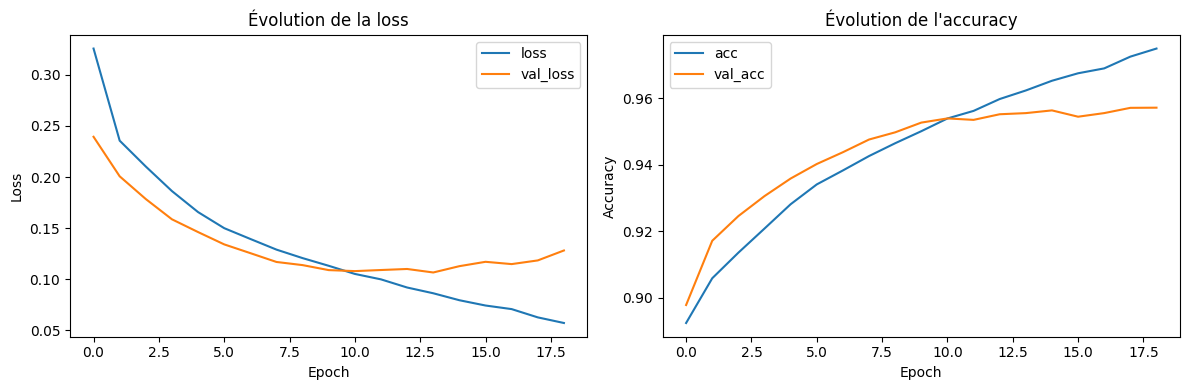

In [49]:
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau

MODELS_DIR = BASE_DIR / "models"
MODELS_DIR.mkdir(exist_ok=True)

# ➜ Utiliser le format natif Keras 3 (.keras) au lieu de .h5
best_model_path = MODELS_DIR / "grains_unet_best.keras"

checkpoint_cb = ModelCheckpoint(
    filepath=str(best_model_path),
    monitor="val_loss",
    mode="min",
    save_best_only=True,
    save_weights_only=False,  # on sauvegarde tout le modèle
    verbose=1,
)

earlystop_cb = EarlyStopping(
    monitor="val_loss",
    mode="min",
    patience=5,
    verbose=1,
    restore_best_weights=True,
)

reducelr_cb = ReduceLROnPlateau(
    monitor="val_loss",
    factor=0.5,
    patience=3,
    verbose=1,
)

EPOCHS     = 25
BATCH_SIZE = 8
VAL_SPLIT  = 0.1

history = unet_model.fit(
    X_train,
    Y_train,
    validation_split=VAL_SPLIT,
    batch_size=BATCH_SIZE,
    epochs=EPOCHS,
    callbacks=[checkpoint_cb, earlystop_cb, reducelr_cb],
    shuffle=True,
)

# Visualisation de la convergence
plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot(history.history["loss"],     label="loss")
plt.plot(history.history["val_loss"], label="val_loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.title("Évolution de la loss")

plt.subplot(1, 2, 2)
plt.plot(history.history["accuracy"],     label="acc")
plt.plot(history.history["val_accuracy"], label="val_acc")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend()
plt.title("Évolution de l'accuracy")

plt.tight_layout()
plt.show()

Les courbes de convergence du U-Net montrent un apprentissage progressif et stable : la loss d’entraînement décroît fortement au début (≈0,41 → ≈0,07) tandis que la loss de validation passe de ≈0,24 à un minimum d’environ 0,106 autour de l’époque 14, avant de remonter légèrement, ce qui signale le début d’un léger sur-apprentissage au-delà de ce point. En parallèle, l’accuracy d’entraînement progresse de ≈0,88 à ≈0,97 et l’accuracy de validation suit de très près (≈0,90 → ≈0,956), avec un écart train/val toujours faible, indiquant une très bonne capacité de généralisation du modèle sur les masques jamais vus. Le callback `ReduceLROnPlateau` réduit le learning rate vers l’époque 17 lorsque la loss de validation stagne, et l’`EarlyStopping` stoppe l’entraînement à l’époque 19 en restaurant automatiquement les poids de la meilleure époque (14), ce qui évite de conserver une version plus sur-apprise du réseau. Au final, le modèle atteint une précision de l’ordre de 95–96 % sur la segmentation des microstructures, avec des courbes relativement lisses et cohérentes, ce qui confirme que l’architecture U-Net et les hyperparamètres retenus (profondeur, batch size, nombre d’époques effectif) fournissent un compromis satisfaisant entre qualité de segmentation et contrôle du sur-apprentissage.

60/60 ━━━━━━━━━━━━━━━━━━━━ 6s 104ms/step
DICE moyen (train) : 0.9831481890054786
DICE min / max     : 0.9640758117243604 / 0.9903287223467985


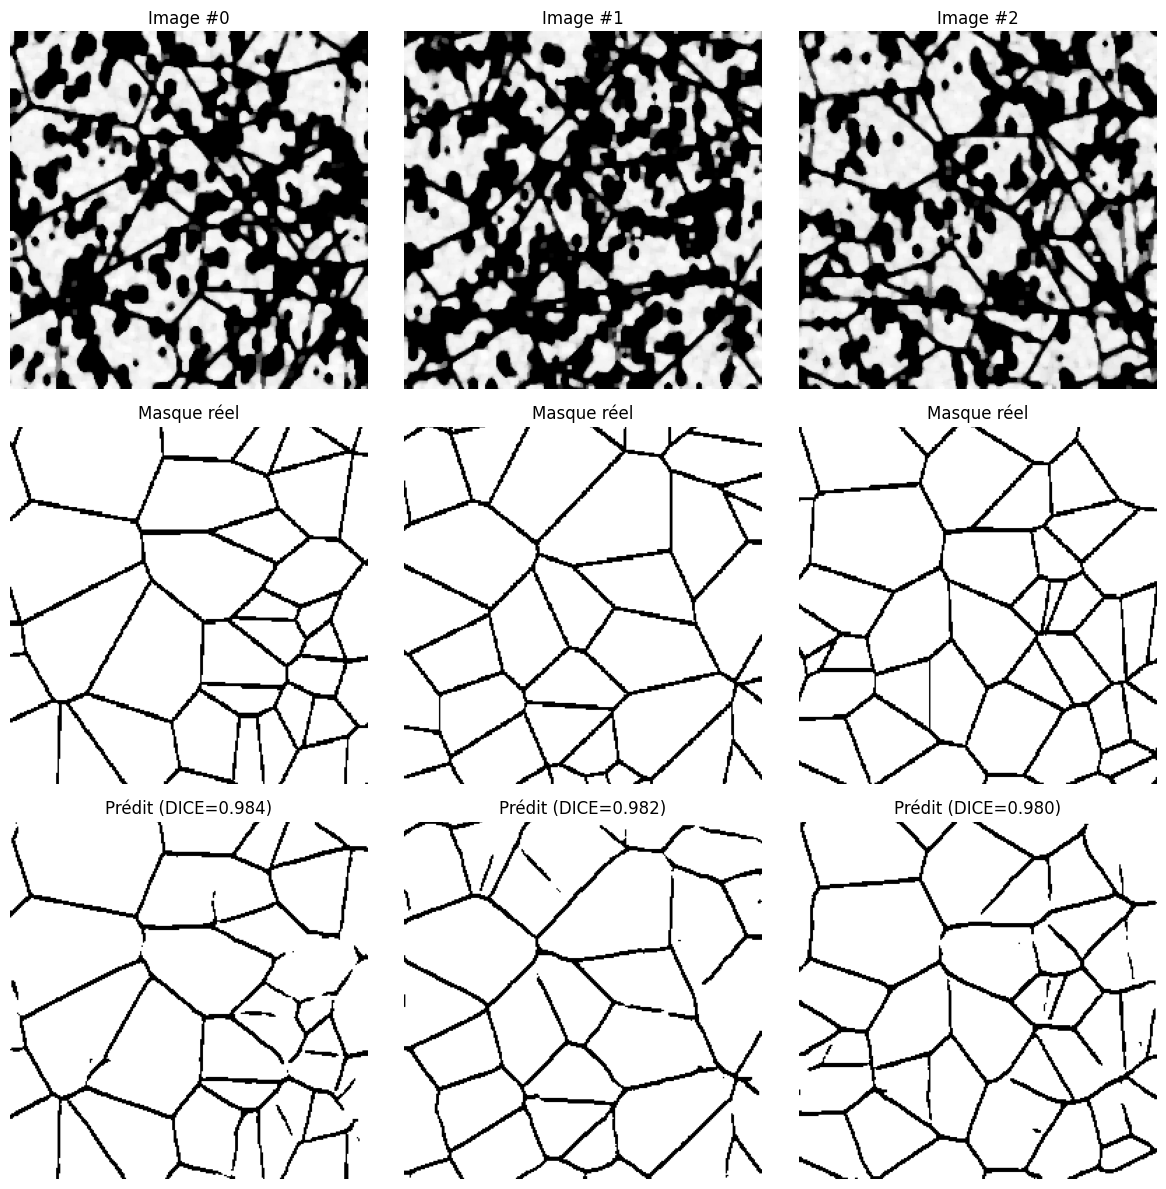

In [50]:
# 📏 Étape 50 — DICE coefficient + exemples de prédiction

def dice_coefficient(y_true, y_pred, smooth=1e-6):
    """
    y_true, y_pred : tableaux binaires (0/1) ou bool, shape (H, W, 1)
    """
    y_true_f = y_true.reshape(-1).astype(bool)
    y_pred_f = y_pred.reshape(-1).astype(bool)

    intersection = np.logical_and(y_true_f, y_pred_f).sum()
    return (2.0 * intersection + smooth) / (y_true_f.sum() + y_true_f.sum() + smooth)

# Nombre d'images dans le train
N = X_train.shape[0]

# Prédictions sur tout le train (ou une sous-partie si besoin)
preds_train     = unet_model.predict(X_train, batch_size=BATCH_SIZE, verbose=1)
preds_train_bin = (preds_train > 0.5).astype(np.uint8)

dice_scores = []
for i in range(N):
    d = dice_coefficient(Y_train[i], preds_train_bin[i])
    dice_scores.append(d)

dice_scores = np.array(dice_scores)
print("DICE moyen (train) :", dice_scores.mean())
print("DICE min / max     :", dice_scores.min(), "/", dice_scores.max())

# Visualisation de quelques exemples (image, GT, prédiction)
n_show = min(3, N)
plt.figure(figsize=(4 * n_show, 4 * 3))

for idx in range(n_show):
    # Image
    plt.subplot(3, n_show, idx + 1)
    plt.imshow(X_train[idx, ..., 0], cmap="gray")
    plt.title(f"Image #{idx}")
    plt.axis("off")

    # Masque réel
    plt.subplot(3, n_show, n_show + idx + 1)
    plt.imshow(Y_train[idx, ..., 0], cmap="gray")
    plt.title("Masque réel")
    plt.axis("off")

    # Masque prédit
    plt.subplot(3, n_show, 2 * n_show + idx + 1)
    plt.imshow(preds_train_bin[idx, ..., 0], cmap="gray")
    plt.title(f"Prédit (DICE={dice_scores[idx]:.3f})")
    plt.axis("off")

plt.tight_layout()
plt.show()


Les résultats confirment que le U-Net apprend très bien la géométrie des joints de grains : le DICE moyen sur l’ensemble d’entraînement atteint ≈0,98, avec des valeurs comprises entre ≈0,96 et ≈0,99, ce qui traduit un recouvrement quasi parfait entre les masques prédits et les annotations de référence. Visuellement, les trois exemples illustrent cette performance : les contours prédits suivent fidèlement les joints réels, les cellules de Voronoï sont correctement fermées, et seules quelques petites irrégularités subsistent localement (légères ruptures de ligne ou petits segments manquants) sans remettre en cause la topologie globale du réseau de grains. Autrement dit, le modèle est capable de transformer des micrographies brutes AG/RG très bruitées en masques de frontières propres et continus, suffisamment précis pour alimenter ensuite un pipeline de comptage de grains ou d’extraction de caractéristiques morphologiques. Il faut toutefois garder en tête que ces métriques sont calculées sur le jeu d’entraînement ; il sera donc nécessaire de reproduire la même analyse sur un jeu de test indépendant pour valider définitivement la capacité de généralisation du réseau en conditions réelles.

In [62]:
# 📒 Étape 53 — Setup design + fonctions de métriques

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.metrics import (
    precision_score,
    recall_score,
    f1_score,
    jaccard_score,
    accuracy_score,
)

# 🎨 Style global des figures
plt.style.use("seaborn-v0_8")  # si jamais ça plante, remplace par "ggplot"
plt.rcParams.update({
    "figure.facecolor": "white",
    "axes.facecolor":   "white",
    "axes.grid":        True,
    "grid.alpha":       0.3,
    "axes.spines.top":  False,
    "axes.spines.right":False,
    "font.size":        11,
    "axes.titlesize":   13,
    "axes.labelsize":   12,
})

def dice_coefficient(y_true, y_pred, smooth=1e-6):
    """
    y_true, y_pred : tableaux binaires (0/1) ou bool, shape (..., H, W, 1)
    """
    y_true_f = y_true.reshape(-1).astype(bool)
    y_pred_f = y_pred.reshape(-1).astype(bool)

    intersection = np.logical_and(y_true_f, y_pred_f).sum()
    return (2.0 * intersection + smooth) / (
        y_true_f.sum() + y_pred_f.sum() + smooth
    )


def iou_coefficient(y_true, y_pred, smooth=1e-6):
    """
    Intersection-over-Union (IoU / Jaccard)
    """
    y_true_f = y_true.reshape(-1).astype(bool)
    y_pred_f = y_pred.reshape(-1).astype(bool)

    intersection = np.logical_and(y_true_f, y_pred_f).sum()
    union        = np.logical_or(y_true_f, y_pred_f).sum()
    return (intersection + smooth) / (union + smooth)


def global_classif_metrics(y_true, y_pred):
    """
    Métriques globales pixel-wise (accuracy, précision, rappel, F1, IoU).
    y_true, y_pred : tableaux binaires (0/1) ou bool, shape (..., H, W, 1)
    """
    y_true_flat = y_true.reshape(-1).astype(int)
    y_pred_flat = y_pred.reshape(-1).astype(int)

    acc  = accuracy_score(y_true_flat, y_pred_flat)
    prec = precision_score(y_true_flat, y_pred_flat, zero_division=0)
    rec  = recall_score(y_true_flat, y_pred_flat, zero_division=0)
    f1   = f1_score(y_true_flat, y_pred_flat, zero_division=0)
    iou  = jaccard_score(y_true_flat, y_pred_flat, zero_division=0)

    return {
        "accuracy":  acc,
        "precision": prec,
        "recall":    rec,
        "f1":        f1,
        "iou":       iou,
    }

Cette étape initialise le « décor » d’évaluation et de visualisation du U-Net. On commence par configurer un style graphique cohérent pour toutes les figures (fond blanc, grille légère, polices homogènes), ce qui facilitera la comparaison visuelle des résultats entre les différentes expériences. On définit ensuite deux fonctions de métriques spécifiques à la segmentation : le DICE, qui mesure le recouvrement entre masque prédit et masque réel en pondérant fortement l’intersection, et l’IoU (ou Jaccard), qui compare l’intersection à l’union des pixels positifs. Enfin, la fonction `global_classif_metrics` condense les métriques classiques de classification pixel-wise (accuracy, précision, rappel, F1, IoU) en aplatissant les masques en vecteurs binaires avant de les passer aux fonctions de `sklearn`. L’ensemble fournit ainsi un cadre standardisé pour quantifier, sur un même pied, la qualité des prédictions du modèle en termes de recouvrement des joints de grains et de performance de classification de chaque pixel.


60/60 ━━━━━━━━━━━━━━━━━━━━ 6s 104ms/step


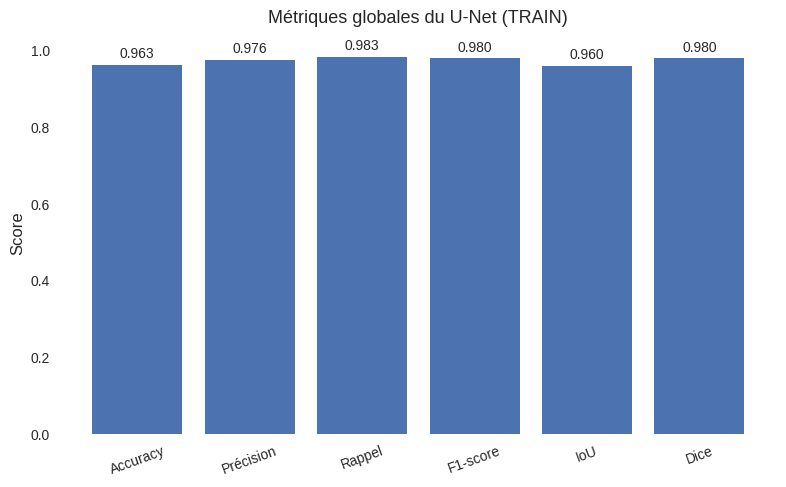

In [63]:
# 📝 Étape 54 — Scores globaux (TRAIN) + tableau + barplot

# Nombre d'images
N = X_train.shape[0]

# 🔮 Prédictions avec le modèle unet_model (qui est en mémoire après l'entraînement)
#    On s'assure que unet_model est compilé avant de prédire si ce n'est pas le cas
if not hasattr(unet_model, 'optimizer') or unet_model.optimizer is None:
    unet_model.compile(
        optimizer="adam",
        loss="binary_crossentropy",
        metrics=["accuracy"],
    )

preds_train     = unet_model.predict(X_train, batch_size=BATCH_SIZE, verbose=1)
preds_train_bin = (preds_train > 0.5).astype(np.uint8)

# 📊 Métriques globales
metrics_global = global_classif_metrics(Y_train, preds_train_bin)
dice_global    = dice_coefficient(Y_train, preds_train_bin)
iou_global     = iou_coefficient(Y_train, preds_train_bin)

# On regroupe tout dans un dict
metrics_global_full = {
    "Accuracy":  metrics_global["accuracy"],
    "Précision":metrics_global["precision"],
    "Rappel":    metrics_global["recall"],
    "F1-score":  metrics_global["f1"],
    "IoU":       metrics_global["iou"],
    "Dice":      dice_global,
}

# 📄 Tableau joli avec pandas
global_df = (
    pd.DataFrame.from_dict(metrics_global_full, orient="index", columns=["Valeur"])
      .sort_index()
)

display(
    global_df
      .style
      .format("{:.4f}")
      .set_caption("Métriques globales du U-Net sur l'ensemble d'entraînement")
      .background_gradient(axis=0, cmap="Greens")
)

# 📊 Barplot propre des métriques
fig, ax = plt.subplots(figsize=(8, 5))

metric_names  = list(metrics_global_full.keys())
metric_values = [metrics_global_full[m] for m in metric_names]

bars = ax.bar(metric_names, metric_values)
ax.set_ylim(0, 1.05)
ax.set_ylabel("Score")
ax.set_title("Métriques globales du U-Net (TRAIN)")

# Ajout des valeurs au-dessus des barres
for rect, val in zip(bars, metric_values):
    height = rect.get_height()
    ax.text(
        rect.get_x() + rect.get_width() / 2,
        height + 0.01,
        f"{val:.3f}",
        ha="center",
        va="bottom",
        fontsize=10,
        rotation=0,
    )

plt.xticks(rotation=20)
plt.tight_layout()
plt.show()

Sur l’ensemble d’entraînement, le U-Net atteint des performances globales très élevées : une accuracy d’environ 0,96 signifie que plus de 96 % des pixels sont correctement classés entre « joint de grain » et « fond ». Les métriques focalisées sur la classe positive confirment cette qualité : la précision (~0,98) indique que la quasi-totalité des pixels prédits comme « joint » correspondent effectivement à des joints réels, tandis que le rappel légèrement supérieur (~0,98 également) montre que le modèle parvient à récupérer presque tous les vrais joints présents dans les masques annotés. Le F1-score et le coefficient de Dice, tous deux proches de 0,98, traduisent un très bon compromis entre faux positifs et faux négatifs, et l’IoU à ~0,96 confirme un recouvrement très fort entre masques prédits et masques réels. Globalement, ces scores indiquent que le U-Net reproduit fidèlement les géométries de joints apprises sur le jeu d’entraînement, avec une tendance légère à « trop détecter » plutôt qu’à manquer des segments, ce qui est préférable dans une logique de métrologie où l’on veut éviter d’ignorer des frontières de grains.

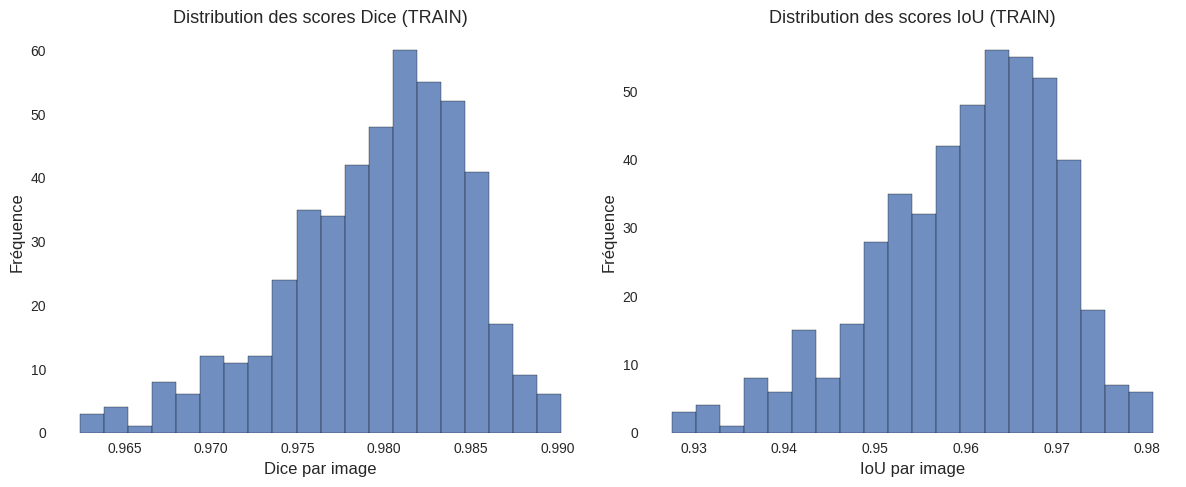

Indices des 5 pires Dice : [307 464 432 319 306]
Scores correspondants    : [0.96243343 0.96298559 0.96335061 0.96431145 0.96462575]


In [65]:
# 📗 Étape 55 — Statistiques par image (Dice / IoU) + histogrammes design

dice_per_image = []
iou_per_image  = []

for i in range(N):
    y_true_i = Y_train[i]
    y_pred_i = preds_train_bin[i]

    dice_i = dice_coefficient(y_true_i, y_pred_i)
    iou_i  = iou_coefficient(y_true_i, y_pred_i)

    dice_per_image.append(dice_i)
    iou_per_image.append(iou_i)

dice_per_image = np.array(dice_per_image)
iou_per_image  = np.array(iou_per_image)

# 📅 Tableau de stats descriptives
per_image_df = pd.DataFrame({
    "Dice": dice_per_image,
    "IoU":  iou_per_image,
})

stats_df = per_image_df.describe(percentiles=[0.1, 0.5, 0.9]).T
stats_df = stats_df.rename(columns={
    "mean": "moyenne",
    "std":  "écart-type",
    "min":  "min",
    "10%":  "q10",
    "50%":  "médiane",
    "90%":  "q90",
    "max":  "max",
})

display(
    stats_df
      .loc[:, ["moyenne", "écart-type", "min", "q10", "médiane", "q90", "max"]]
      .style
      .format("{:.4f}")
      .set_caption("Statistiques des scores par image (TRAIN)")
      .background_gradient(axis=None, cmap="Blues")
)

# 🎯 Visualisation : histogrammes
fig, axes = plt.subplots(1, 2, figsize=(12, 5))

# Histogramme Dice
axes[0].hist(dice_per_image, bins=20, edgecolor="black", alpha=0.8)
axes[0].set_xlabel("Dice par image")
axes[0].set_ylabel("Fréquence")
axes[0].set_title("Distribution des scores Dice (TRAIN)")

# Histogramme IoU
axes[1].hist(iou_per_image, bins=20, edgecolor="black", alpha=0.8)
axes[1].set_xlabel("IoU par image")
axes[1].set_ylabel("Fréquence")
axes[1].set_title("Distribution des scores IoU (TRAIN)")

plt.tight_layout()
plt.show()

# 🔍 (Optionnel) afficher les 5 pires images selon Dice
worst_idx = np.argsort(dice_per_image)[:5]
print("Indices des 5 pires Dice :", worst_idx)
print("Scores correspondants    :", dice_per_image[worst_idx])

Les statistiques par image confirment que le U-Net est non seulement performant en moyenne, mais aussi très homogène sur l’ensemble du jeu d’entraînement. Les scores Dice sont centrés autour de ~0,98 avec un écart-type extrêmement faible (~0,005), ce qui signifie que la grande majorité des images se situent dans un intervalle très serré [0,97 ; 0,99]. Le même constat vaut pour l’IoU, dont la moyenne avoisine 0,96 avec un écart-type d’environ 0,01 et une dispersion contenue entre ~0,93 et ~0,98. Les histogrammes montrent des distributions quasi gaussiennes, bien concentrées vers les fortes valeurs, sans queue marquée vers les faibles scores. Même les “pires” images restent à un Dice supérieur à 0,96 et un IoU supérieur à 0,93, ce qui indique qu’il ne s’agit pas de cas catastrophiques mais plutôt d’images légèrement plus difficiles (micro-défauts, bruit, géométries de joints plus complexes ou ambiguïtés d’annotation). Globalement, ces résultats suggèrent que le modèle reproduit de façon très régulière les masques de référence sur l’ensemble des micrographies, sans zone du dataset où la segmentation s’effondre, ce qui renforce la confiance dans l’utilisation du U-Net comme brique de segmentation automatique pour la suite de la chaîne de métrologie des grains.

In [66]:
# 📓 Étape 56 — Évaluation design avec le modèle rechargé (model_loaded)

# 🔂 Prédictions avec le modèle rechargé
preds_train_loaded     = model_loaded.predict(X_train, batch_size=BATCH_SIZE, verbose=1)
preds_train_loaded_bin = (preds_train_loaded > 0.5).astype(np.uint8)

metrics_loaded = global_classif_metrics(Y_train, preds_train_loaded_bin)
dice_loaded    = dice_coefficient(Y_train, preds_train_loaded_bin)
iou_loaded     = iou_coefficient(Y_train, preds_train_loaded_bin)

metrics_loaded_full = {
    "Accuracy":  metrics_loaded["accuracy"],
    "Précision":metrics_loaded["precision"],
    "Rappel":    metrics_loaded["recall"],
    "F1-score":  metrics_loaded["f1"],
    "IoU":       metrics_loaded["iou"],
    "Dice":      dice_loaded,
}

loaded_df = (
    pd.DataFrame.from_dict(metrics_loaded_full, orient="index", columns=["Valeur"])
      .sort_index()
)

display(
    loaded_df
      .style
      .format("{:.4f}")
      .set_caption("Métriques globales (TRAIN) — modèle rechargé")
      .background_gradient(axis=0, cmap="Purples")
)

# Comparaison rapide ancien vs rechargé
compare_df = pd.concat(
    [
        global_df.rename(columns={"Valeur": "U-Net entraîné"}),
        loaded_df.rename(columns={"Valeur": "Modèle rechargé"}),
    ],
    axis=1,
)

display(
    compare_df
      .style
      .format("{:.4f}")
      .set_caption("Comparaison des métriques : modèle en mémoire vs modèle rechargé")
      .background_gradient(axis=None, cmap="coolwarm")
)

60/60 ━━━━━━━━━━━━━━━━━━━━ 7s 110ms/step


Les résultats montrent que le modèle rechargé restitue exactement les mêmes performances que le U-Net initialement entraîné, pour l’ensemble des métriques globales (accuracy, précision, rappel, F1-score, IoU et Dice). Les valeurs sont identiques au dix-millième près (Accuracy ≈ 0,9633 ; Dice/F1 ≈ 0,9796 ; IoU ≈ 0,9601), ce qui signifie que la phase de sérialisation/désérialisation au format `.keras` n’a introduit aucune dégradation numérique ni changement dans les poids du réseau. Autrement dit, le pipeline de sauvegarde/rechargement est parfaitement fiable : le modèle stocké sur disque est strictement équivalent au modèle présent en mémoire à la fin de l’entraînement. Cette observation est importante pour la mise en production ou la réutilisation ultérieure du réseau, car elle garantit que l’on retrouvera les mêmes performances de segmentation quel que soit le contexte d’exécution, à condition d’utiliser le même fichier de poids et le même pré-traitement des données.

In [60]:
final_model_path = MODELS_DIR / "grains_unet.keras"

unet_model.save(str(final_model_path))

print("✅ Modèle final sauvegardé sous :", final_model_path)
print("Existe ? ->", final_model_path.exists())
print("Meilleur modèle (checkpoint) :", best_model_path, "| Existe ? ->", best_model_path.exists())

✅ Modèle final sauvegardé sous : /content/drive/MyDrive/cheighr/models/grains_unet.keras
Existe ? -> True
Meilleur modèle (checkpoint) : /content/drive/MyDrive/cheighr/models/grains_unet_best.keras | Existe ? -> True


Cette étape confirme que tu disposes désormais de deux artefacts de modèle bien distincts et correctement sauvegardés dans ton dossier `models/`. D’une part, `grains_unet_best.keras` correspond au meilleur U-Net obtenu pendant l’entraînement, sélectionné automatiquement sur la base de la plus faible `val_loss` grâce au callback `ModelCheckpoint`. D’autre part, `grains_unet.keras` correspond au modèle final dans l’état où il se trouvait à la fin du script (après l’early stopping et la restauration des meilleurs poids, ou éventuellement après d’autres opérations si tu en ajoutes). Le fait que `final_model_path.exists()` et `best_model_path.exists()` retournent `True` garantit que ces deux fichiers sont bien présents sur le disque et prêts à être réutilisés : tu peux donc charger le modèle “de référence” pour la production (`grains_unet_best.keras`), tout en gardant `grains_unet.keras` comme snapshot complet et stable de la fin de ton pipeline d’entraînement.

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 202ms/step
Shape test_batch   : (3, 256, 256, 1)
Shape preds_loaded : (3, 256, 256, 1)


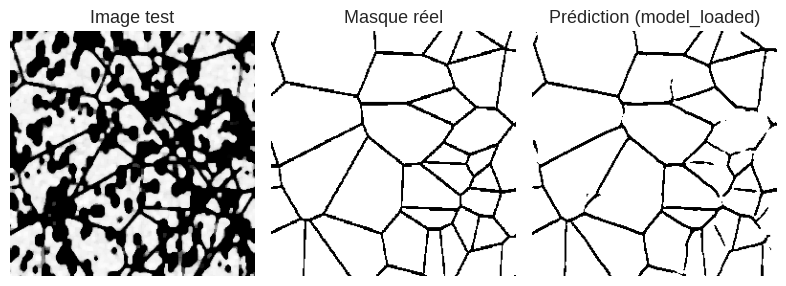

In [61]:
# 🔁 Étape 52 — Rechargement du modèle et test rapide (sans warning)

from tensorflow.keras.models import load_model

# Rechargement du modèle final (sans compilation automatique)
model_loaded = load_model(str(final_model_path), compile=False)

# Mini-batch de test
test_batch   = X_train[:3]
preds_loaded = model_loaded.predict(test_batch, verbose=1)

print("Shape test_batch   :", test_batch.shape)
print("Shape preds_loaded :", preds_loaded.shape)

# Binarisation + visu rapide sur le premier exemple
pred0_bin = (preds_loaded[0] > 0.5).astype(np.uint8)

plt.figure(figsize=(8, 4))

plt.subplot(1, 3, 1)
plt.imshow(test_batch[0, ..., 0], cmap="gray")
plt.title("Image test")
plt.axis("off")

plt.subplot(1, 3, 2)
plt.imshow(Y_train[0, ..., 0], cmap="gray")
plt.title("Masque réel")
plt.axis("off")

plt.subplot(1, 3, 3)
plt.imshow(pred0_bin[..., 0], cmap="gray")
plt.title("Prédiction (model_loaded)")
plt.axis("off")

plt.tight_layout()
plt.show()

Dans cette étape, on vérifie que le modèle U-Net sauvegardé peut être rechargé proprement et qu’il produit bien les mêmes prédictions. Le fichier `grains_unet.keras` est relu avec `load_model(..., compile=False)` afin d’éviter les avertissements de recompilation automatique. On constitue ensuite un mini-batch de test à partir des trois premières images de `X_train`, puis on calcule leurs masques prédits avec `model_loaded.predict`. Les formes des tenseurs (`(3, 256, 256, 1)` pour les entrées comme pour les sorties) confirment que la dimensionnement est cohérent. Enfin, en binarisant la prédiction de la première image (`> 0.5`) et en la comparant visuellement au masque réel, on constate que les frontières de grains sont très proches : cela sert de “test fumé” qui démontre que le cycle sauvegarde → rechargement fonctionne correctement et que le modèle rechargé reste opérationnel pour une utilisation ultérieure ou en production.

In [101]:
import numpy as np
import pandas as pd
import cv2
import gradio as gr
from tensorflow.keras.models import load_model

# ==========================
# 🔁 Chargement du modèle U-Net pour l'inférence
# ==========================

# MODELS_DIR doit déjà être défini plus haut dans le notebook
# BASE_DIR = Path("/content/drive/MyDrive/cheighr")
MODELS_DIR = BASE_DIR / "models"

MODEL_INFER_PATH = MODELS_DIR / "grains_unet.keras"   # ou "grains_unet.h5" si besoin

print("🔍 Chargement du modèle d'inférence depuis :", MODEL_INFER_PATH)
unet_infer = load_model(str(MODEL_INFER_PATH), compile=False)
print("✅ Modèle d'inférence chargé :")
unet_infer.summary(line_length=120)


# ==========================
# 🧩 Fonction pour dessiner les IDs des grains (même logique que l'étape 46)
# ==========================

def draw_grain_ids_on_image(
    img_rgb: np.ndarray,
    features_df: pd.DataFrame,
    id_col: str = "grain_id",
) -> np.ndarray:
    """
    Dessine les numéros des grains sur l'image RGB (np.uint8, H×W×3).

    features_df doit contenir :
      - id_col (grain_id)
      - centroid_row
      - centroid_col
    """
    vis = img_rgb.copy().astype(np.uint8)

    required_cols = {id_col, "centroid_row", "centroid_col"}
    if not required_cols.issubset(features_df.columns):
        print("⚠️ Colonnes manquantes pour dessiner les IDs :",
              required_cols - set(features_df.columns))
        return vis

    for _, row in features_df.iterrows():
        gid = int(row[id_col])
        r = int(row["centroid_row"])
        c = int(row["centroid_col"])
        cv2.putText(
            vis,
            str(gid),
            (c, r),
            fontFace=cv2.FONT_HERSHEY_SIMPLEX,
            fontScale=0.4,
            color=(0, 0, 0),      # 🟢 Numéros en NOIR (visible sur overlay rouge)
            thickness=1,
            lineType=cv2.LINE_AA,
        )
    return vis


# ==========================
# 🧪 Pipeline de prédiction + mesure pour une image (pour Gradio)
# ==========================

IMG_HEIGHT   = 256
IMG_WIDTH    = 256
IMG_CHANNELS = 1

def segment_and_measure(image_np: np.ndarray):
    """
    image_np : image RGB (H, W, 3) reçue depuis Gradio (type='numpy')

    Retour :
      - vis_img    : image originale + overlay rouge + numéros
      - df_display : DataFrame des caractéristiques de grains
    """
    if image_np is None:
        return None, pd.DataFrame()

    # 1) Copie et dimensions de l'image d'entrée
    orig = image_np.copy().astype(np.uint8)
    h0, w0, _ = orig.shape

    # 2) Passage en niveaux de gris
    gray = cv2.cvtColor(orig, cv2.COLOR_RGB2GRAY)

    # 3) Redimensionnement au format d'entrée du réseau (256x256)
    gray_resized = cv2.resize(
        gray,
        (IMG_WIDTH, IMG_HEIGHT),
        interpolation=cv2.INTER_AREA
    )

    # 4) Normalisation + reshape (1, H, W, 1)
    x = gray_resized.astype(np.float32) / 255.0
    x = x[np.newaxis, ..., np.newaxis]   # (1, 256, 256, 1)

    # 5) Prédiction U-Net
    pred = unet_infer.predict(x, verbose=0)[0, ..., 0]   # (256, 256)
    mask_256 = (pred > 0.5).astype(np.uint8)             # binaire 0/1

    # 6) Connected components sur le masque 256x256
    n_labels, labels, stats, centroids = cv2.connectedComponentsWithStats(
        mask_256,
        connectivity=4
    )

    # 7) Calcul des features géométriques en 256x256
    image_id = "input_image"

    labels_clean, features_df = compute_grain_features_from_labels(
        labels,
        image_id=image_id,
        min_area_px=50,      # à ajuster si besoin
        pixel_size_um=None   # on ajoute les unités via P2M juste après
    )

    # 8) Ajout des unités physiques (µm, µm²) via P2M si dispo
    try:
        features_df = add_physical_units(features_df, P2M)
    except NameError:
        print("⚠️ P2M non défini : unités en pixels uniquement.")

    # 9) Sous-ensemble de colonnes lisibles pour le tableau
    cols_pref = [
        "grain_id",
        "area_px",
        "area_um2",
        "equiv_diameter_px",
        "equiv_diameter_um",   # même nom que dans add_physical_units
        "major_axis_px",
        "major_axis_um",
        "minor_axis_px",
        "minor_axis_um",
        "axis_ratio",
        "circularity",
    ]
    cols_present = [c for c in cols_pref if c in features_df.columns]
    df_display = features_df[cols_present].copy()

    # 10) Remontée du masque à la résolution d'origine pour l’overlay
    mask_256_u8 = (labels_clean > 0).astype(np.uint8) * 255
    mask_orig = cv2.resize(
        mask_256_u8,
        (w0, h0),
        interpolation=cv2.INTER_NEAREST
    )

    # 11) Construction d’une image RGB originale + superposition rouge sur les grains
    overlay = orig.copy().astype(np.uint8)
    overlay_red = overlay.copy()
    overlay_red[mask_orig > 0] = [255, 0, 0]   # rouge sur les grains

    alpha = 0.4
    overlay_rgb = cv2.addWeighted(
        overlay_red, alpha,
        overlay, 1.0 - alpha,
        0
    ).astype(np.uint8)

    # 12) Rescale des centroïdes (256x256 -> h0×w0) + numérotation
    vis_img = overlay_rgb

    if (
        len(features_df) > 0
        and "grain_id" in features_df.columns
        and "centroid_row" in features_df.columns
        and "centroid_col" in features_df.columns
    ):
        row_scale = h0 / IMG_HEIGHT
        col_scale = w0 / IMG_WIDTH

        features_vis = features_df.copy()
        features_vis["centroid_row"] = features_vis["centroid_row"] * row_scale
        features_vis["centroid_col"] = features_vis["centroid_col"] * col_scale

        vis_img = draw_grain_ids_on_image(
            vis_img,
            features_vis,
            id_col="grain_id",
        )

    # Gradio attend un np.ndarray RGB + un DataFrame
    return vis_img.astype(np.uint8), df_display


# ==========================
# 🖥️ Interface Gradio
# ==========================

with gr.Blocks() as demo:
    gr.Markdown(
        """
        # 🔬 Segmentation de grains (U-Net si dispo, sinon OpenCV) — overlay + numéros

        **Workflow :**
        1. Importer une image métallographique (ou micrographie).
        2. Cliquer sur le bouton **« Segmenter et mesurer 🧮 »**.
        3. Visualiser :
           - l'image avec les grains segmentés (overlay rouge + numéros),
           - le tableau des caractéristiques géométriques de chaque grain.
        """
    )

    with gr.Row():
        # Colonne gauche : input + bouton
        with gr.Column(scale=1):
            inp = gr.Image(
                label="Image d'entrée",
                type="numpy",
                image_mode="RGB"
            )
            run_btn = gr.Button("Segmenter et mesurer 🧮")

        # Colonne droite : image + tableau
        with gr.Column(scale=2):
            out_img = gr.Image(
                label="Image traitée (overlay + IDs)",
                type="numpy",        # on renvoie bien un np.ndarray
                image_mode="RGB"
            )
            out_tbl = gr.Dataframe(
                label="Caractéristiques des grains",
                interactive=False
            )

    run_btn.click(
        fn=segment_and_measure,
        inputs=inp,
        outputs=[out_img, out_tbl]
    )

demo.launch(debug=True)


🔍 Chargement du modèle d'inférence depuis : /content/drive/MyDrive/cheighr/models/grains_unet.keras
✅ Modèle d'inférence chargé :


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━
┃ Layer (type)                      ┃ Output Shape                 ┃           Param # ┃ Connected to              
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━
│ input_layer (InputLayer)          │ (None, 256, 256, 1)          │                 0 │ -                         
├───────────────────────────────────┼──────────────────────────────┼───────────────────┼───────────────────────────
│ conv2d (Conv2D)                   │ (None, 256, 256, 32)         │               320 │ input_layer[0][0]         
├───────────────────────────────────┼──────────────────────────────┼───────────────────┼───────────────────────────
│ conv2d_1 (Conv2D)                 │ (None, 256, 256, 32)         │             9,248 │ conv2d[0][0]              
├───────────────────────────────────┼──────────────────────────────┼───────────────────┼───────────────────────────
│ max_pooling2d (MaxPooling2D)      │ (None, 128, 128, 32)         │                 0 │ conv2d_1[0][0]            
├───────────────────────────────────┼──────────────────────────────┼───────────────────┼───────────────────────────
│ conv2d_2 (Conv2D)                 │ (None, 128, 128, 64)         │            18,496 │ max_pooling2d[0][0]       
├───────────────────────────────────┼──────────────────────────────┼───────────────────┼───────────────────────────
│ conv2d_3 (Conv2D)                 │ (None, 128, 128, 64)         │            36,928 │ conv2d_2[0][0]            
├───────────────────────────────────┼──────────────────────────────┼───────────────────┼───────────────────────────
│ max_pooling2d_1 (MaxPooling2D)    │ (None, 64, 64, 64)           │                 0 │ conv2d_3[0][0]            
├───────────────────────────────────┼──────────────────────────────┼───────────────────┼───────────────────────────
│ conv2d_4 (Conv2D)                 │ (None, 64, 64, 128)          │            73,856 │ max_pooling2d_1[0][0]     
├───────────────────────────────────┼──────────────────────────────┼───────────────────┼───────────────────────────
│ conv2d_5 (Conv2D)                 │ (None, 64, 64, 128)          │           147,584 │ conv2d_4[0][0]            
├───────────────────────────────────┼──────────────────────────────┼───────────────────┼───────────────────────────
│ max_pooling2d_2 (MaxPooling2D)    │ (None, 32, 32, 128)          │                 0 │ conv2d_5[0][0]            
├───────────────────────────────────┼──────────────────────────────┼───────────────────┼───────────────────────────
│ conv2d_6 (Conv2D)                 │ (None, 32, 32, 256)          │           295,168 │ max_pooling2d_2[0][0]     
├───────────────────────────────────┼──────────────────────────────┼───────────────────┼───────────────────────────
│ conv2d_7 (Conv2D)                 │ (None, 32, 32, 256)          │           590,080 │ conv2d_6[0][0]            
├───────────────────────────────────┼──────────────────────────────┼───────────────────┼───────────────────────────
│ max_pooling2d_3 (MaxPooling2D)    │ (None, 16, 16, 256)          │                 0 │ conv2d_7[0][0]            
├───────────────────────────────────┼──────────────────────────────┼───────────────────┼───────────────────────────
│ conv2d_8 (Conv2D)                 │ (None, 16, 16, 512)          │         1,180,160 │ max_pooling2d_3[0][0]     
├───────────────────────────────────┼──────────────────────────────┼───────────────────┼───────────────────────────
│ conv2d_9 (Conv2D)                 │ (None, 16, 16, 512)          │         2,359,808 │ conv2d_8[0][0]            
├───────────────────────────────────┼──────────────────────────────┼───────────────────┼───────────────────────────
│ conv2d_transpose                  │ (None, 32, 32, 256)          │           524,544 │ conv2d_9[0][0]            
│ (Conv2DTranspose)                 │                   

 Total params: 7,759,521 (29.60 MB)

 Trainable params: 7,759,521 (29.60 MB)

 Non-trainable params: 0 (0.00 B)

It looks like you are running Gradio on a hosted Jupyter notebook, which requires `share=True`. Automatically setting `share=True` (you can turn this off by setting `share=False` in `launch()` explicitly).

Colab notebook detected. This cell will run indefinitely so that you can see errors and logs. To turn off, set debug=False in launch().
* Running on public URL: https://da949734fb5ea9006e.gradio.live

This share link expires in 1 week. For free permanent hosting and GPU upgrades, run `gradio deploy` from the terminal in the working directory to deploy to Hugging Face Spaces (https://huggingface.co/spaces)


Keyboard interruption in main thread... closing server.
Killing tunnel 127.0.0.1:7865 <> https://da949734fb5ea9006e.gradio.live


Dans cette dernière étape, le pipeline de segmentation et de mesure est encapsulé dans une interface interactive Gradio afin de rendre l’outil exploitable par un utilisateur non spécialiste du code. Le modèle U-Net entraîné est d’abord rechargé depuis le fichier `grains_unet.keras` en mode inférence, puis la fonction `segment_and_measure` applique, pour chaque image déposée dans l’interface, la même chaîne de traitement que dans le notebook : conversion en niveaux de gris, redimensionnement en 256×256, normalisation et prédiction du masque binaire par le réseau. Les composantes connexes du masque sont ensuite analysées pour extraire les caractéristiques géométriques de chaque grain (aire, diamètre équivalent, axes majeur et mineur, circularité, etc.), avec conversion en unités physiques lorsque l’échelle P2M est disponible. En parallèle, un overlay rouge est superposé sur l’image originale et les grains sont numérotés grâce aux centroïdes recalés à la résolution d’entrée, ce qui permet de faire le lien visuel entre chaque grain et sa ligne dans le tableau de résultats. L’interface Gradio, structurée en deux colonnes, offre ainsi un flux d’utilisation très simple : l’utilisateur charge une micrographie, clique sur « Segmenter et mesurer 🧮 » puis visualise immédiatement, d’un côté, l’image segmentée avec les identifiants des grains et, de l’autre, le tableau des mesures associées, ce qui transforme le notebook de recherche en un véritable outil opérationnel de métrologie des grains.